# DataBalancer
* This notebook will read in the .csv dataset file from Step 1 and will help the user balance the data to have an appropriate representation of molecules for CNN training.

## Energy Distribution Analysis for Molecular Dataset
=================================================

* This notebook cell analyzes the energy distribution of molecules from ORCA calculations
and creates bins for dataset balancing analysis.


🔬 MOLECULAR ENERGY DISTRIBUTION ANALYSIS
✅ Successfully loaded dataset: molecular_data.csv
📊 Total rows in dataset: 74,826
🧪 Unique molecules found: 12,471

📈 BASIC ENERGY STATISTICS
------------------------------
Minimum energy:     -602582.789 kcal/mol
Maximum energy:     -601412.643 kcal/mol
Mean energy:        -602501.052 kcal/mol
Median energy:      -602526.684 kcal/mol
Standard deviation:     97.449 kcal/mol
Energy range:         1170.146 kcal/mol

🚨 OUTLIER DETECTION (>3.0σ)
------------------------------
Number of outliers: 235
Outlier percentage: 1.9%
Outlier molecules:
  molecule2425: -602202.286 kcal/mol (z-score: 3.07)
  molecule2428: -602195.105 kcal/mol (z-score: 3.14)
  molecule2429: -602205.048 kcal/mol (z-score: 3.04)
  molecule2432: -602189.172 kcal/mol (z-score: 3.20)
  molecule2434: -602191.584 kcal/mol (z-score: 3.18)
  molecule2435: -602161.874 kcal/mol (z-score: 3.48)
  molecule2436: -602140.254 kcal/mol (z-score: 3.70)
  molecule2437: -602107.322 kcal/mol (z-sco

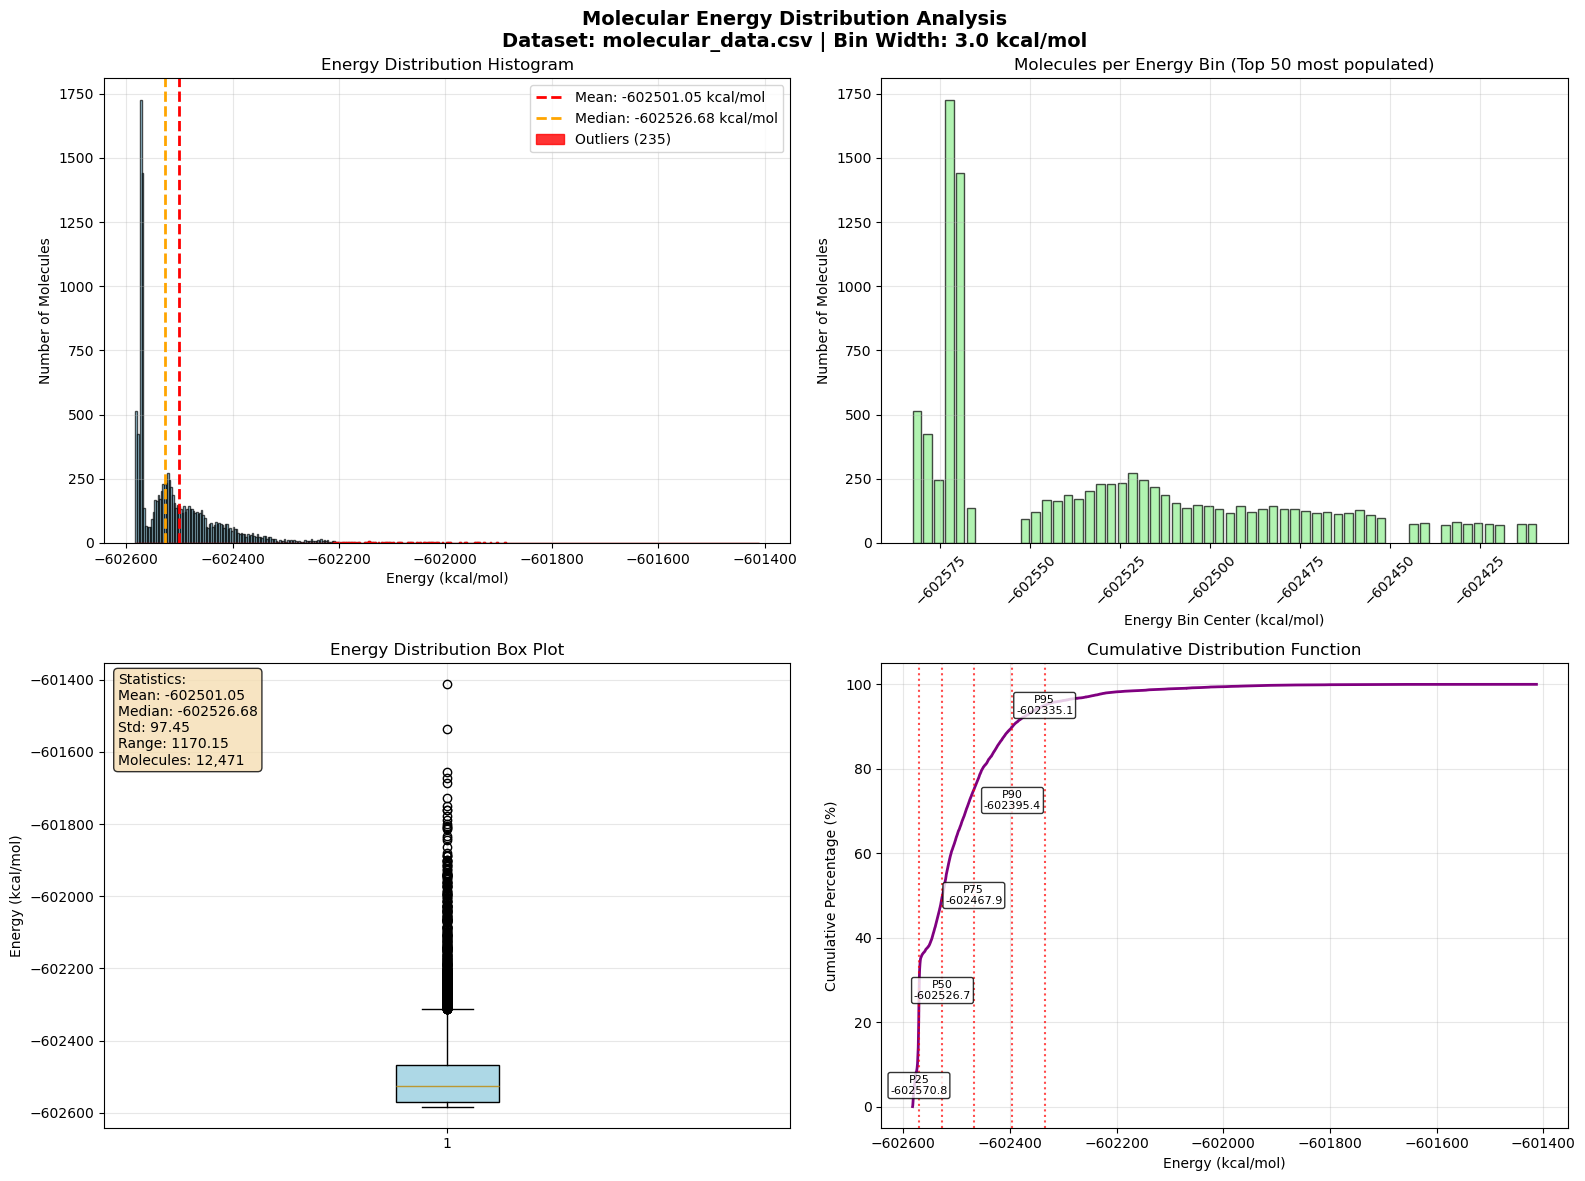

⚖️  DATASET BALANCE ANALYSIS
----------------------------------------
Most populated bin:         1724 molecules
Least populated bin:          70 molecules
Imbalance ratio:           24.63:1

💡 RECOMMENDATIONS
--------------------
⚠️  High imbalance detected! Consider:
   • Oversampling underrepresented bins
   • Using stratified sampling
   • Weighted loss functions
   • Synthetic data generation (SMILES/conformers)

🎯 ANALYSIS COMPLETE!
Results stored in 'results' dictionary
Use results['bins'] for bin information
Use results['molecule_data'] for molecule energies
Use results['outliers'] for outlier molecule IDs


In [1]:
"""
Energy Distribution Analysis for Molecular Dataset
=================================================

This notebook cell analyzes the energy distribution of molecules from ORCA calculations
and creates bins for dataset balancing analysis.

Dependencies: pandas, numpy, matplotlib, seaborn
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def analyze_energy_distribution(csv_file, bin_width=1.0, energy_col='energy_kcal_mol', 
                               molecule_col='molecule_id', show_outliers=True, 
                               outlier_threshold=3.0):
    """
    Analyze energy distribution of molecules and create energy bins.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing molecular data
    bin_width : float
        Width of energy bins in kcal/mol (default: 1.0)
    energy_col : str
        Name of energy column (default: 'energy_kcal_mol')
    molecule_col : str
        Name of molecule ID column (default: 'molecule_id')
    show_outliers : bool
        Whether to identify and highlight outliers (default: True)
    outlier_threshold : float
        Number of standard deviations for outlier detection (default: 3.0)
    
    Returns:
    --------
    dict : Analysis results including bin information and statistics
    """
    
    print("🔬 MOLECULAR ENERGY DISTRIBUTION ANALYSIS")
    print("=" * 50)
    
    # Read CSV file
    try:
        df = pd.read_csv(csv_file)
        print(f"✅ Successfully loaded dataset: {csv_file}")
        print(f"📊 Total rows in dataset: {len(df):,}")
    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        return None
    
    # Check if required columns exist
    if energy_col not in df.columns:
        print(f"❌ Energy column '{energy_col}' not found in dataset")
        print(f"Available columns: {list(df.columns)}")
        return None
    
    if molecule_col not in df.columns:
        print(f"❌ Molecule ID column '{molecule_col}' not found in dataset")
        print(f"Available columns: {list(df.columns)}")
        return None
    
    # Get unique molecules and their energies
    # Since CSV has one row per atom, we need to get unique molecules
    molecule_data = df.groupby(molecule_col)[energy_col].first().reset_index()
    molecule_data.columns = ['molecule_id', 'energy']
    
    print(f"🧪 Unique molecules found: {len(molecule_data):,}")
    print()
    
    # Basic statistics
    energies = molecule_data['energy'].values
    min_energy = np.min(energies)
    max_energy = np.max(energies)
    mean_energy = np.mean(energies)
    median_energy = np.median(energies)
    std_energy = np.std(energies)
    energy_range = max_energy - min_energy
    
    print("📈 BASIC ENERGY STATISTICS")
    print("-" * 30)
    print(f"Minimum energy:     {min_energy:>10.3f} kcal/mol")
    print(f"Maximum energy:     {max_energy:>10.3f} kcal/mol")
    print(f"Mean energy:        {mean_energy:>10.3f} kcal/mol")
    print(f"Median energy:      {median_energy:>10.3f} kcal/mol")
    print(f"Standard deviation: {std_energy:>10.3f} kcal/mol")
    print(f"Energy range:       {energy_range:>10.3f} kcal/mol")
    print()
    
    # Outlier detection
    outliers = []
    if show_outliers:
        z_scores = np.abs((energies - mean_energy) / std_energy)
        outlier_mask = z_scores > outlier_threshold
        outliers = molecule_data[outlier_mask]['molecule_id'].tolist()
        outlier_energies = molecule_data[outlier_mask]['energy'].tolist()
        
        print(f"🚨 OUTLIER DETECTION (>{outlier_threshold}σ)")
        print("-" * 30)
        if outliers:
            print(f"Number of outliers: {len(outliers)}")
            print(f"Outlier percentage: {len(outliers)/len(molecule_data)*100:.1f}%")
            print("Outlier molecules:")
            for mol_id, energy in zip(outliers, outlier_energies):
                z_score = abs((energy - mean_energy) / std_energy)
                print(f"  {mol_id}: {energy:.3f} kcal/mol (z-score: {z_score:.2f})")
        else:
            print("No outliers detected")
        print()
    
    # Create energy bins
    # Adjust bin edges to center around data
    bin_start = np.floor(min_energy / bin_width) * bin_width
    bin_end = np.ceil(max_energy / bin_width) * bin_width
    bin_edges = np.arange(bin_start, bin_end + bin_width, bin_width)
    
    # Assign molecules to bins
    bin_indices = np.digitize(energies, bin_edges) - 1
    bin_counts = np.bincount(bin_indices, minlength=len(bin_edges)-1)
    
    # Create bin information
    bins_info = []
    for i, count in enumerate(bin_counts):
        bin_min = bin_edges[i]
        bin_max = bin_edges[i + 1]
        bin_center = (bin_min + bin_max) / 2
        
        # Get molecules in this bin
        mask = bin_indices == i
        bin_molecules = molecule_data[mask]
        
        if count > 0:
            bin_mean = np.mean(bin_molecules['energy'])
            bin_std = np.std(bin_molecules['energy']) if count > 1 else 0.0
            bin_min_energy = np.min(bin_molecules['energy'])
            bin_max_energy = np.max(bin_molecules['energy'])
        else:
            bin_mean = bin_std = bin_min_energy = bin_max_energy = 0.0
        
        bins_info.append({
            'bin_index': i,
            'bin_range': f"{bin_min:.1f} to {bin_max:.1f}",
            'bin_center': bin_center,
            'count': count,
            'percentage': (count / len(molecule_data)) * 100,
            'mean_energy': bin_mean,
            'std_energy': bin_std,
            'min_energy': bin_min_energy,
            'max_energy': bin_max_energy,
            'molecules': bin_molecules['molecule_id'].tolist() if count > 0 else []
        })
    
    # Print bin summary
    print(f"📦 ENERGY BINS (width: {bin_width} kcal/mol)")
    print("-" * 60)
    print(f"{'Bin Range':>15} {'Count':>8} {'%':>6} {'Mean':>8} {'Std':>8}")
    print("-" * 60)
    
    non_empty_bins = [b for b in bins_info if b['count'] > 0]
    for bin_info in non_empty_bins:
        print(f"{bin_info['bin_range']:>15} "
              f"{bin_info['count']:>8d} "
              f"{bin_info['percentage']:>5.1f}% "
              f"{bin_info['mean_energy']:>7.2f} "
              f"{bin_info['std_energy']:>7.2f}")
    
    print("-" * 60)
    print(f"Total non-empty bins: {len(non_empty_bins)}")
    print()
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Molecular Energy Distribution Analysis\n'
                f'Dataset: {csv_file} | Bin Width: {bin_width} kcal/mol', 
                fontsize=14, fontweight='bold')
    
    # 1. Histogram with bins
    ax1 = axes[0, 0]
    n, bins_plot, patches = ax1.hist(energies, bins=bin_edges, edgecolor='black', 
                                    alpha=0.7, color='skyblue')
    ax1.axvline(mean_energy, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_energy:.2f} kcal/mol')
    ax1.axvline(median_energy, color='orange', linestyle='--', linewidth=2, 
                label=f'Median: {median_energy:.2f} kcal/mol')
    ax1.set_xlabel('Energy (kcal/mol)')
    ax1.set_ylabel('Number of Molecules')
    ax1.set_title('Energy Distribution Histogram')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Color outliers differently
    if show_outliers and outliers:
        outlier_energies_for_plot = molecule_data[molecule_data['molecule_id'].isin(outliers)]['energy']
        ax1.hist(outlier_energies_for_plot, bins=bin_edges, edgecolor='red', 
                alpha=0.8, color='red', label=f'Outliers ({len(outliers)})')
        ax1.legend()
    
    # 2. Bar plot of bin counts - limit number of bars for large datasets
    ax2 = axes[0, 1]
    
    # For large numbers of bins, show only the most populated ones
    max_bars_to_show = 50  # Limit to prevent overcrowding
    if len(non_empty_bins) > max_bars_to_show:
        # Show top N most populated bins
        sorted_bins = sorted(non_empty_bins, key=lambda x: x['count'], reverse=True)
        top_bins = sorted_bins[:max_bars_to_show]
        # Sort back by energy for proper display
        bins_to_plot = sorted(top_bins, key=lambda x: x['bin_center'])
        title_suffix = f" (Top {max_bars_to_show} most populated)"
    else:
        bins_to_plot = non_empty_bins
        title_suffix = ""
    
    bin_centers = [b['bin_center'] for b in bins_to_plot]
    bin_counts_plot = [b['count'] for b in bins_to_plot]
    
    if bin_centers:  # Only plot if we have data
        bars = ax2.bar(bin_centers, bin_counts_plot, width=bin_width*0.8, 
                       edgecolor='black', alpha=0.7, color='lightgreen')
        
        # Add count labels on bars - but only if not too many bars
        if len(bins_to_plot) <= 20:
            for bar, count in zip(bars, bin_counts_plot):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + max(bin_counts_plot)*0.01,
                        f'{count}', ha='center', va='bottom', fontsize=8)
    
    ax2.set_xlabel('Energy Bin Center (kcal/mol)')
    ax2.set_ylabel('Number of Molecules')
    ax2.set_title(f'Molecules per Energy Bin{title_suffix}')
    ax2.grid(True, alpha=0.3)
    
    # Rotate x-axis labels if too many bins
    if len(bin_centers) > 10:
        ax2.tick_params(axis='x', rotation=45)
    
    # 3. Box plot
    ax3 = axes[1, 0]
    box_plot = ax3.boxplot(energies, vert=True, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    ax3.set_ylabel('Energy (kcal/mol)')
    ax3.set_title('Energy Distribution Box Plot')
    ax3.grid(True, alpha=0.3)
    
    # Add statistics text - fix positioning issue
    stats_text = f'''Statistics:
Mean: {mean_energy:.2f}
Median: {median_energy:.2f}
Std: {std_energy:.2f}
Range: {energy_range:.2f}
Molecules: {len(molecule_data):,}'''
    ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes,
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 4. Cumulative distribution - fix percentile labeling
    ax4 = axes[1, 1]
    sorted_energies = np.sort(energies)
    cumulative = np.arange(1, len(sorted_energies) + 1) / len(sorted_energies) * 100
    ax4.plot(sorted_energies, cumulative, linewidth=2, color='purple')
    ax4.set_xlabel('Energy (kcal/mol)')
    ax4.set_ylabel('Cumulative Percentage (%)')
    ax4.set_title('Cumulative Distribution Function')
    ax4.grid(True, alpha=0.3)
    
    # Add percentile lines - fix positioning
    percentiles = [25, 50, 75, 90, 95]
    y_positions = np.linspace(5, 95, len(percentiles))  # Spread labels vertically
    for i, p in enumerate(percentiles):
        energy_p = np.percentile(energies, p)
        ax4.axvline(energy_p, color='red', linestyle=':', alpha=0.7)
        # Place text at fixed y position to avoid overlap
        ax4.text(energy_p, y_positions[i], f'P{p}\n{energy_p:.1f}', 
                ha='center', va='center', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Dataset balance analysis
    print("⚖️  DATASET BALANCE ANALYSIS")
    print("-" * 40)
    max_count = max(bin_counts_plot) if bin_counts_plot else 0
    min_count = min([c for c in bin_counts_plot if c > 0]) if bin_counts_plot else 0
    
    if max_count > 0:
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
        print(f"Most populated bin:     {max_count:>8d} molecules")
        print(f"Least populated bin:    {min_count:>8d} molecules")
        print(f"Imbalance ratio:        {imbalance_ratio:>8.2f}:1")
        
        # Recommendations
        print("\n💡 RECOMMENDATIONS")
        print("-" * 20)
        if imbalance_ratio > 10:
            print("⚠️  High imbalance detected! Consider:")
            print("   • Oversampling underrepresented bins")
            print("   • Using stratified sampling")
            print("   • Weighted loss functions")
            print("   • Synthetic data generation (SMILES/conformers)")
        elif imbalance_ratio > 3:
            print("⚠️  Moderate imbalance detected")
            print("   • Consider stratified train/test split")
            print("   • Monitor per-bin performance")
        else:
            print("✅ Dataset is relatively balanced")
    
    # Prepare return data
    results = {
        'dataset_info': {
            'csv_file': csv_file,
            'total_molecules': len(molecule_data),
            'total_atoms': len(df),
            'bin_width': bin_width
        },
        'energy_stats': {
            'min': min_energy,
            'max': max_energy,
            'mean': mean_energy,
            'median': median_energy,
            'std': std_energy,
            'range': energy_range
        },
        'bins': bins_info,
        'outliers': outliers,
        'balance_metrics': {
            'max_bin_count': max_count,
            'min_bin_count': min_count,
            'imbalance_ratio': imbalance_ratio if min_count > 0 else float('inf'),
            'non_empty_bins': len(non_empty_bins)
        },
        'molecule_data': molecule_data
    }
    
    return results

# Example usage:
# ================================================================================

# Load and analyze your molecular dataset
csv_file = 'molecular_data.csv'  # Path to your CSV file
bin_width = 3.0  # Energy bin width in kcal/mol

# Run the analysis
results = analyze_energy_distribution(
    csv_file=csv_file,
    bin_width=bin_width,
    energy_col='energy_kcal_mol',     # Column name for energy
    molecule_col='molecule_id',       # Column name for molecule ID
    show_outliers=True,               # Detect and show outliers
    outlier_threshold=3.0             # Standard deviations for outlier detection
)

# Access results for further analysis
if results:
    print("\n🎯 ANALYSIS COMPLETE!")
    print(f"Results stored in 'results' dictionary")
    print(f"Use results['bins'] for bin information")
    print(f"Use results['molecule_data'] for molecule energies")
    print(f"Use results['outliers'] for outlier molecule IDs")

🎯 MOLECULE 3D VISUALIZATION
🔍 3D VISUALIZATION: molecule001
Loaded dataset with 74,826 rows
✅ Found molecule with 6 atoms
📊 Energy: -602571.925 kcal/mol
💡 Charge Statistics (CM5):
   Range: -0.690 to 0.096
   Mean: -0.167
   Total: -1.000



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

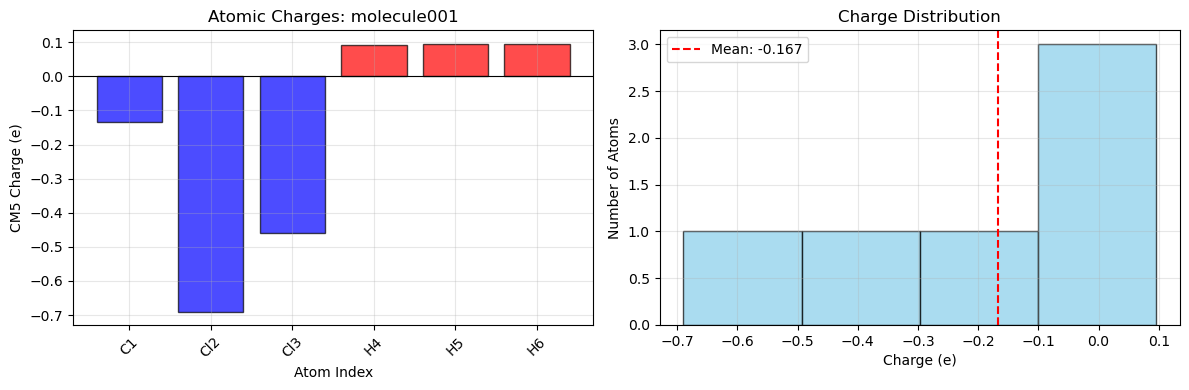

🔬 DETAILED ATOM INFORMATION
--------------------------------------------------
  Atom  Element        X        Y        Z   Charge
--------------------------------------------------
     1        C   -0.123    0.216    0.067   -0.134
     2       Cl   -0.162   -0.720    2.293   -0.690
     3       Cl   -0.202    1.155   -1.797   -0.459
     4        H   -0.398    1.130    0.613    0.092
     5        H   -0.892   -0.483   -0.107    0.094
     6        H    0.902   -0.072   -0.023    0.096

🔍 FINDING INTERESTING MOLECULES
------------------------------
Outlier molecules: ['molecule2425', 'molecule2428', 'molecule2429', 'molecule2432', 'molecule2434']
Highest energy molecules: ['molecule2809', 'molecule2827', 'molecule2826']
Lowest energy molecules: ['molecule894', 'molecule907', 'molecule1072']

💡 To visualize any of these molecules, change 'molecule_to_view' above
Example: molecule_to_view = 'molecule2425'


In [4]:
"""
3D Molecular Viewer for Individual Molecules
============================================
This cell allows you to select and visualize specific molecules in 3D using py3Dmol.
"""

import pandas as pd
import numpy as np
import py3Dmol
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def visualize_molecule_3d(csv_file, molecule_id, results=None, 
                         charge_type='cm5', style='sphere', 
                         show_charges=True, color_by_charge=True,
                         width=800, height=600):
    """
    Visualize a specific molecule in 3D with charge information.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing molecular data
    molecule_id : str
        ID of the molecule to visualize (e.g., 'molecule001')
    results : dict, optional
        Results dictionary from previous analysis
    charge_type : str
        Type of charge to display ('cm5' or 'hirshfeld')
    style : str
        Visualization style ('sphere', 'stick', 'cartoon', 'line')
    show_charges : bool
        Whether to display charge labels on atoms
    color_by_charge : bool
        Whether to color atoms by charge (red=positive, blue=negative)
    width : int
        Viewer width in pixels
    height : int
        Viewer height in pixels
        
    Returns:
    --------
    py3Dmol view object
    """
    
    print(f"🔍 3D VISUALIZATION: {molecule_id}")
    print("=" * 40)
    
    # Read the CSV file
    try:
        df = pd.read_csv(csv_file)
        print(f"Loaded dataset with {len(df):,} rows")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None
    
    # Filter data for the specific molecule
    mol_data = df[df['molecule_id'] == molecule_id].copy()
    
    if mol_data.empty:
        print(f"❌ Molecule '{molecule_id}' not found in dataset")
        print(f"Available molecules: {sorted(df['molecule_id'].unique())[:10]}...")
        return None
    
    print(f"✅ Found molecule with {len(mol_data)} atoms")
    
    # Get molecule information
    if results and 'molecule_data' in results:
        mol_info = results['molecule_data'][
            results['molecule_data']['molecule_id'] == molecule_id
        ]
        if not mol_info.empty:
            energy = mol_info['energy'].iloc[0]
            print(f"📊 Energy: {energy:.3f} kcal/mol")
            
            # Check if it's an outlier
            if results.get('outliers') and molecule_id in results['outliers']:
                print("⚠️  This molecule is identified as an outlier")
    
    # Create XYZ format string for py3Dmol
    xyz_lines = [str(len(mol_data))]  # Number of atoms
    xyz_lines.append(f"{molecule_id} - Energy visualization")  # Comment line
    
    # Map atomic numbers to element symbols
    z_to_element = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 
                   15: 'P', 16: 'S', 17: 'Cl', 35: 'Br', 53: 'I'}
    
    charges = []
    elements = []
    
    for _, atom in mol_data.iterrows():
        element = z_to_element.get(atom['Z'], f"Z{atom['Z']}")
        elements.append(element)
        
        # Get charge value - the 'charge' column contains CM5 charges from your pipeline
        charge_value = atom['charge']  # This is CM5 charge from your pipeline
        charges.append(charge_value)
        
        xyz_lines.append(f"{element} {atom['x']:.6f} {atom['y']:.6f} {atom['z']:.6f}")
    
    xyz_string = '\n'.join(xyz_lines)
    
    # Print charge statistics
    charges = np.array(charges)
    print(f"💡 Charge Statistics (CM5):")
    print(f"   Range: {charges.min():.3f} to {charges.max():.3f}")
    print(f"   Mean: {charges.mean():.3f}")
    print(f"   Total: {charges.sum():.3f}")
    print()
    
    # Create py3Dmol viewer
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(xyz_string, 'xyz')
    
    # Set visualization style
    if color_by_charge:
        # Color atoms by charge: red = positive, blue = negative, white = neutral
        for i, (charge, element) in enumerate(zip(charges, elements)):
            # Normalize charge for coloring (-1 to 1 range, clamped)
            normalized_charge = np.clip(charge, -1.0, 1.0)
            
            if normalized_charge > 0:
                # Positive charges: red
                color = f"rgb({255}, {int(255 * (1 - normalized_charge))}, {int(255 * (1 - normalized_charge))})"
            elif normalized_charge < 0:
                # Negative charges: blue  
                color = f"rgb({int(255 * (1 + normalized_charge))}, {int(255 * (1 + normalized_charge))}, {255})"
            else:
                # Neutral: white
                color = "white"
            
            if style == 'sphere':
                viewer.setStyle({'serial': i}, {'sphere': {'color': color, 'radius': 0.4}})
            elif style == 'stick':
                viewer.setStyle({'serial': i}, {'stick': {'color': color, 'radius': 0.3}})
            elif style == 'line':
                viewer.setStyle({'serial': i}, {'line': {'color': color}})
            else:
                viewer.setStyle({'serial': i}, {style: {'color': color}})
    else:
        # Use default CPK coloring
        if style == 'sphere':
            viewer.setStyle({}, {'sphere': {'radius': 0.4}})
        elif style == 'stick':
            viewer.setStyle({}, {'stick': {'radius': 0.3}})
        elif style == 'line':
            viewer.setStyle({}, {'line': {}})
        else:
            viewer.setStyle({}, {style: {}})
    
    # Add charge labels if requested
    if show_charges:
        for i, (x, y, z, charge, element) in enumerate(zip(
            mol_data['x'], mol_data['y'], mol_data['z'], charges, elements
        )):
            label_text = f"{element}{i+1}\\n{charge:.3f}"
            viewer.addLabel(label_text, {
                'position': {'x': x, 'y': y, 'z': z},
                'backgroundColor': 'white',
                'backgroundOpacity': 0.8,
                'fontColor': 'black',
                'fontSize': 10
            })
    
    # Add bonds automatically
    viewer.addStyle({}, {'stick': {'radius': 0.1, 'color': 'grey'}})
    
    viewer.zoomTo()
    viewer.show()
    
    # Create charge distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Bar plot of charges by atom
    atom_labels = [f"{elem}{i+1}" for i, elem in enumerate(elements)]
    colors = ['red' if c > 0 else 'blue' if c < 0 else 'gray' for c in charges]
    
    bars = ax1.bar(range(len(charges)), charges, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Atom Index')
    ax1.set_ylabel('CM5 Charge (e)')
    ax1.set_title(f'Atomic Charges: {molecule_id}')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Add atom labels on x-axis (if not too many atoms)
    if len(atom_labels) <= 20:
        ax1.set_xticks(range(len(charges)))
        ax1.set_xticklabels(atom_labels, rotation=45)
    
    # Histogram of charge distribution
    ax2.hist(charges, bins=min(10, len(charges)//2 + 1), alpha=0.7, 
             edgecolor='black', color='skyblue')
    ax2.axvline(charges.mean(), color='red', linestyle='--', 
                label=f'Mean: {charges.mean():.3f}')
    ax2.set_xlabel('Charge (e)')
    ax2.set_ylabel('Number of Atoms')
    ax2.set_title('Charge Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed atom information
    print("🔬 DETAILED ATOM INFORMATION")
    print("-" * 50)
    print(f"{'Atom':>6} {'Element':>8} {'X':>8} {'Y':>8} {'Z':>8} {'Charge':>8}")
    print("-" * 50)
    for i, (_, atom) in enumerate(mol_data.iterrows()):
        element = elements[i]
        print(f"{i+1:>6} {element:>8} {atom['x']:>8.3f} {atom['y']:>8.3f} {atom['z']:>8.3f} {charges[i]:>8.3f}")
    
    return viewer

# Quick molecule selection helper
def find_molecules_by_criteria(results, criteria='outlier', top_n=10):
    """
    Find molecules based on different criteria.
    
    Parameters:
    -----------
    results : dict
        Results from the energy analysis
    criteria : str
        Selection criteria: 'outlier', 'high_energy', 'low_energy', 'random'
    top_n : int
        Number of molecules to return
    
    Returns:
    --------
    list : List of molecule IDs
    """
    
    if not results or 'molecule_data' not in results:
        print("❌ No results data available")
        return []
    
    mol_data = results['molecule_data']
    
    if criteria == 'outlier':
        return results.get('outliers', [])[:top_n]
    elif criteria == 'high_energy':
        high_energy = mol_data.nlargest(top_n, 'energy')
        return high_energy['molecule_id'].tolist()
    elif criteria == 'low_energy':
        low_energy = mol_data.nsmallest(top_n, 'energy')
        return low_energy['molecule_id'].tolist()
    elif criteria == 'random':
        random_sample = mol_data.sample(min(top_n, len(mol_data)))
        return random_sample['molecule_id'].tolist()
    else:
        print(f"❌ Unknown criteria: {criteria}")
        return []

# Example usage:
# ================================================================================

# Make sure you have the results from the previous cell and your CSV file
csv_file = 'molecular_data.csv'  # Path to your CSV file

# Method 1: Visualize a specific molecule (e.g., an outlier)
molecule_to_view = 'molecule001'  # Change this to your molecule ID

print("🎯 MOLECULE 3D VISUALIZATION")
print("=" * 30)

# Visualize the molecule
viewer = visualize_molecule_3d(
    csv_file=csv_file,
    molecule_id=molecule_to_view,
    results=results,  # From previous analysis cell
    charge_type='cm5',
    style='sphere',  # Options: 'sphere', 'stick', 'line'
    show_charges=False,
    color_by_charge=False,
    width=800,
    height=600
)

# Method 2: Find and visualize interesting molecules
print("\n🔍 FINDING INTERESTING MOLECULES")
print("-" * 30)

# Find outliers
outliers = find_molecules_by_criteria(results, 'outlier', top_n=5)
print(f"Outlier molecules: {outliers}")

# Find high energy molecules  
high_energy = find_molecules_by_criteria(results, 'high_energy', top_n=3)
print(f"Highest energy molecules: {high_energy}")

# Find low energy molecules
low_energy = find_molecules_by_criteria(results, 'low_energy', top_n=3)
print(f"Lowest energy molecules: {low_energy}")

print(f"\n💡 To visualize any of these molecules, change 'molecule_to_view' above")
print(f"Example: molecule_to_view = '{outliers[0] if outliers else 'molecule001'}'")

# Method 3: Interactive selection (uncomment to use)
# print("\n📋 Available molecules in dataset:")
# available_molecules = pd.read_csv(csv_file)['molecule_id'].unique()
# print(f"Total molecules: {len(available_molecules)}")
# print(f"Sample IDs: {list(available_molecules[:10])}")
# print("Copy and paste a molecule ID into the 'molecule_to_view' variable above")

🎯 MOLECULE 3D VISUALIZATION
🔍 3D VISUALIZATION: molecule2425
Loaded dataset with 74,826 rows
✅ Found molecule with 6 atoms
📊 Energy: -602202.286 kcal/mol
⚠️  This molecule is identified as an outlier
💡 Charge Statistics (CM5):
   Range: -0.850 to 0.146
   Mean: -0.167
   Total: -1.000



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

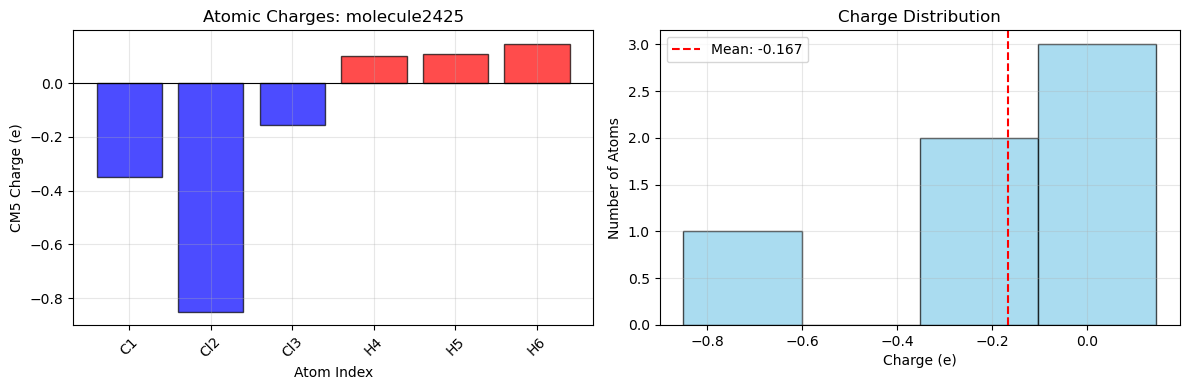

🔬 DETAILED ATOM INFORMATION
--------------------------------------------------
  Atom  Element        X        Y        Z   Charge
--------------------------------------------------
     1        C    1.185    0.417   -1.470   -0.348
     2       Cl   -0.369   -3.023    0.405   -0.850
     3       Cl    2.777    1.222   -2.181   -0.158
     4        H    0.557    0.931   -1.513    0.101
     5        H    1.226    0.292   -2.137    0.108
     6        H   -0.310   -0.242   -1.015    0.146

🔍 FINDING INTERESTING MOLECULES
------------------------------
Outlier molecules: ['molecule2425', 'molecule2428', 'molecule2429', 'molecule2432', 'molecule2434']
Highest energy molecules: ['molecule2809', 'molecule2827', 'molecule2826']
Lowest energy molecules: ['molecule894', 'molecule907', 'molecule1072']

💡 To visualize any of these molecules, change 'molecule_to_view' above
Example: molecule_to_view = 'molecule2425'


In [5]:
"""
3D Molecular Viewer for Individual Molecules
============================================
This cell allows you to select and visualize specific molecules in 3D using py3Dmol.
"""

import pandas as pd
import numpy as np
import py3Dmol
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def visualize_molecule_3d(csv_file, molecule_id, results=None, 
                         charge_type='cm5', style='sphere', 
                         show_charges=True, color_by_charge=True,
                         width=800, height=600):
    """
    Visualize a specific molecule in 3D with charge information.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing molecular data
    molecule_id : str
        ID of the molecule to visualize (e.g., 'molecule001')
    results : dict, optional
        Results dictionary from previous analysis
    charge_type : str
        Type of charge to display ('cm5' or 'hirshfeld')
    style : str
        Visualization style ('sphere', 'stick', 'cartoon', 'line')
    show_charges : bool
        Whether to display charge labels on atoms
    color_by_charge : bool
        Whether to color atoms by charge (red=positive, blue=negative)
    width : int
        Viewer width in pixels
    height : int
        Viewer height in pixels
        
    Returns:
    --------
    py3Dmol view object
    """
    
    print(f"🔍 3D VISUALIZATION: {molecule_id}")
    print("=" * 40)
    
    # Read the CSV file
    try:
        df = pd.read_csv(csv_file)
        print(f"Loaded dataset with {len(df):,} rows")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None
    
    # Filter data for the specific molecule
    mol_data = df[df['molecule_id'] == molecule_id].copy()
    
    if mol_data.empty:
        print(f"❌ Molecule '{molecule_id}' not found in dataset")
        print(f"Available molecules: {sorted(df['molecule_id'].unique())[:10]}...")
        return None
    
    print(f"✅ Found molecule with {len(mol_data)} atoms")
    
    # Get molecule information
    if results and 'molecule_data' in results:
        mol_info = results['molecule_data'][
            results['molecule_data']['molecule_id'] == molecule_id
        ]
        if not mol_info.empty:
            energy = mol_info['energy'].iloc[0]
            print(f"📊 Energy: {energy:.3f} kcal/mol")
            
            # Check if it's an outlier
            if results.get('outliers') and molecule_id in results['outliers']:
                print("⚠️  This molecule is identified as an outlier")
    
    # Create XYZ format string for py3Dmol
    xyz_lines = [str(len(mol_data))]  # Number of atoms
    xyz_lines.append(f"{molecule_id} - Energy visualization")  # Comment line
    
    # Map atomic numbers to element symbols
    z_to_element = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 
                   15: 'P', 16: 'S', 17: 'Cl', 35: 'Br', 53: 'I'}
    
    charges = []
    elements = []
    
    for _, atom in mol_data.iterrows():
        element = z_to_element.get(atom['Z'], f"Z{atom['Z']}")
        elements.append(element)
        
        # Get charge value - the 'charge' column contains CM5 charges from your pipeline
        charge_value = atom['charge']  # This is CM5 charge from your pipeline
        charges.append(charge_value)
        
        xyz_lines.append(f"{element} {atom['x']:.6f} {atom['y']:.6f} {atom['z']:.6f}")
    
    xyz_string = '\n'.join(xyz_lines)
    
    # Print charge statistics
    charges = np.array(charges)
    print(f"💡 Charge Statistics (CM5):")
    print(f"   Range: {charges.min():.3f} to {charges.max():.3f}")
    print(f"   Mean: {charges.mean():.3f}")
    print(f"   Total: {charges.sum():.3f}")
    print()
    
    # Create py3Dmol viewer
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(xyz_string, 'xyz')
    
    # Set visualization style
    if color_by_charge:
        # Color atoms by charge: red = positive, blue = negative, white = neutral
        for i, (charge, element) in enumerate(zip(charges, elements)):
            # Normalize charge for coloring (-1 to 1 range, clamped)
            normalized_charge = np.clip(charge, -1.0, 1.0)
            
            if normalized_charge > 0:
                # Positive charges: red
                color = f"rgb({255}, {int(255 * (1 - normalized_charge))}, {int(255 * (1 - normalized_charge))})"
            elif normalized_charge < 0:
                # Negative charges: blue  
                color = f"rgb({int(255 * (1 + normalized_charge))}, {int(255 * (1 + normalized_charge))}, {255})"
            else:
                # Neutral: white
                color = "white"
            
            if style == 'sphere':
                viewer.setStyle({'serial': i}, {'sphere': {'color': color, 'radius': 0.4}})
            elif style == 'stick':
                viewer.setStyle({'serial': i}, {'stick': {'color': color, 'radius': 0.3}})
            elif style == 'line':
                viewer.setStyle({'serial': i}, {'line': {'color': color}})
            else:
                viewer.setStyle({'serial': i}, {style: {'color': color}})
    else:
        # Use default CPK coloring
        if style == 'sphere':
            viewer.setStyle({}, {'sphere': {'radius': 0.4}})
        elif style == 'stick':
            viewer.setStyle({}, {'stick': {'radius': 0.3}})
        elif style == 'line':
            viewer.setStyle({}, {'line': {}})
        else:
            viewer.setStyle({}, {style: {}})
    
    # Add charge labels if requested
    if show_charges:
        for i, (x, y, z, charge, element) in enumerate(zip(
            mol_data['x'], mol_data['y'], mol_data['z'], charges, elements
        )):
            label_text = f"{element}{i+1}\\n{charge:.3f}"
            viewer.addLabel(label_text, {
                'position': {'x': x, 'y': y, 'z': z},
                'backgroundColor': 'white',
                'backgroundOpacity': 0.8,
                'fontColor': 'black',
                'fontSize': 10
            })
    
    # Add bonds automatically
    viewer.addStyle({}, {'stick': {'radius': 0.1, 'color': 'grey'}})
    
    viewer.zoomTo()
    viewer.show()
    
    # Create charge distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Bar plot of charges by atom
    atom_labels = [f"{elem}{i+1}" for i, elem in enumerate(elements)]
    colors = ['red' if c > 0 else 'blue' if c < 0 else 'gray' for c in charges]
    
    bars = ax1.bar(range(len(charges)), charges, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Atom Index')
    ax1.set_ylabel('CM5 Charge (e)')
    ax1.set_title(f'Atomic Charges: {molecule_id}')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Add atom labels on x-axis (if not too many atoms)
    if len(atom_labels) <= 20:
        ax1.set_xticks(range(len(charges)))
        ax1.set_xticklabels(atom_labels, rotation=45)
    
    # Histogram of charge distribution
    ax2.hist(charges, bins=min(10, len(charges)//2 + 1), alpha=0.7, 
             edgecolor='black', color='skyblue')
    ax2.axvline(charges.mean(), color='red', linestyle='--', 
                label=f'Mean: {charges.mean():.3f}')
    ax2.set_xlabel('Charge (e)')
    ax2.set_ylabel('Number of Atoms')
    ax2.set_title('Charge Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed atom information
    print("🔬 DETAILED ATOM INFORMATION")
    print("-" * 50)
    print(f"{'Atom':>6} {'Element':>8} {'X':>8} {'Y':>8} {'Z':>8} {'Charge':>8}")
    print("-" * 50)
    for i, (_, atom) in enumerate(mol_data.iterrows()):
        element = elements[i]
        print(f"{i+1:>6} {element:>8} {atom['x']:>8.3f} {atom['y']:>8.3f} {atom['z']:>8.3f} {charges[i]:>8.3f}")
    
    return viewer

# Quick molecule selection helper
def find_molecules_by_criteria(results, criteria='outlier', top_n=10):
    """
    Find molecules based on different criteria.
    
    Parameters:
    -----------
    results : dict
        Results from the energy analysis
    criteria : str
        Selection criteria: 'outlier', 'high_energy', 'low_energy', 'random'
    top_n : int
        Number of molecules to return
    
    Returns:
    --------
    list : List of molecule IDs
    """
    
    if not results or 'molecule_data' not in results:
        print("❌ No results data available")
        return []
    
    mol_data = results['molecule_data']
    
    if criteria == 'outlier':
        return results.get('outliers', [])[:top_n]
    elif criteria == 'high_energy':
        high_energy = mol_data.nlargest(top_n, 'energy')
        return high_energy['molecule_id'].tolist()
    elif criteria == 'low_energy':
        low_energy = mol_data.nsmallest(top_n, 'energy')
        return low_energy['molecule_id'].tolist()
    elif criteria == 'random':
        random_sample = mol_data.sample(min(top_n, len(mol_data)))
        return random_sample['molecule_id'].tolist()
    else:
        print(f"❌ Unknown criteria: {criteria}")
        return []

# Example usage:
# ================================================================================

# Make sure you have the results from the previous cell and your CSV file
csv_file = 'molecular_data.csv'  # Path to your CSV file

# Method 1: Visualize a specific molecule (e.g., an outlier)
molecule_to_view = 'molecule2425'  # Change this to your molecule ID

print("🎯 MOLECULE 3D VISUALIZATION")
print("=" * 30)

# Visualize the molecule
viewer = visualize_molecule_3d(
    csv_file=csv_file,
    molecule_id=molecule_to_view,
    results=results,  # From previous analysis cell
    charge_type='cm5',
    style='sphere',  # Options: 'sphere', 'stick', 'line'
    show_charges=False,
    color_by_charge=False,
    width=800,
    height=600
)

# Method 2: Find and visualize interesting molecules
print("\n🔍 FINDING INTERESTING MOLECULES")
print("-" * 30)

# Find outliers
outliers = find_molecules_by_criteria(results, 'outlier', top_n=5)
print(f"Outlier molecules: {outliers}")

# Find high energy molecules  
high_energy = find_molecules_by_criteria(results, 'high_energy', top_n=3)
print(f"Highest energy molecules: {high_energy}")

# Find low energy molecules
low_energy = find_molecules_by_criteria(results, 'low_energy', top_n=3)
print(f"Lowest energy molecules: {low_energy}")

print(f"\n💡 To visualize any of these molecules, change 'molecule_to_view' above")
print(f"Example: molecule_to_view = '{outliers[0] if outliers else 'molecule001'}'")

# Method 3: Interactive selection (uncomment to use)
# print("\n📋 Available molecules in dataset:")
# available_molecules = pd.read_csv(csv_file)['molecule_id'].unique()
# print(f"Total molecules: {len(available_molecules)}")
# print(f"Sample IDs: {list(available_molecules[:10])}")
# print("Copy and paste a molecule ID into the 'molecule_to_view' variable above")

## Dataset Cleaning and Re-analysis
=================================

This cell removes specified molecules (outliers or custom selection) from the dataset
and provides updated distribution analysis with before/after comparisons.

Dependencies: pandas, numpy, matplotlib, seaborn

DATASET CLEANING CONFIGURATION
------------------------------
CSV file: molecular_data.csv
Removal criteria: outliers
Bin width: 3.0 kcal/mol
DATASET CLEANING AND RE-ANALYSIS
Original dataset loaded: 74,826 rows
Original molecules: 12,471
Removing 235 outlier molecules

Molecules to be removed:
   1. molecule2425: -602202.286 kcal/mol
   2. molecule2428: -602195.105 kcal/mol
   3. molecule2429: -602205.048 kcal/mol
   4. molecule2432: -602189.172 kcal/mol
   5. molecule2434: -602191.584 kcal/mol
   6. molecule2435: -602161.874 kcal/mol
   7. molecule2436: -602140.254 kcal/mol
   8. molecule2437: -602107.322 kcal/mol
   9. molecule2438: -602103.633 kcal/mol
  10. molecule2439: -602206.271 kcal/mol
  11. molecule2440: -602110.930 kcal/mol
  12. molecule2441: -602173.309 kcal/mol
  13. molecule2442: -602181.692 kcal/mol
  14. molecule2446: -602143.554 kcal/mol
  15. molecule2447: -602134.101 kcal/mol
  16. molecule2449: -602171.514 kcal/mol
  17. molecule2461: -602192.579 kcal/mol
  18. m

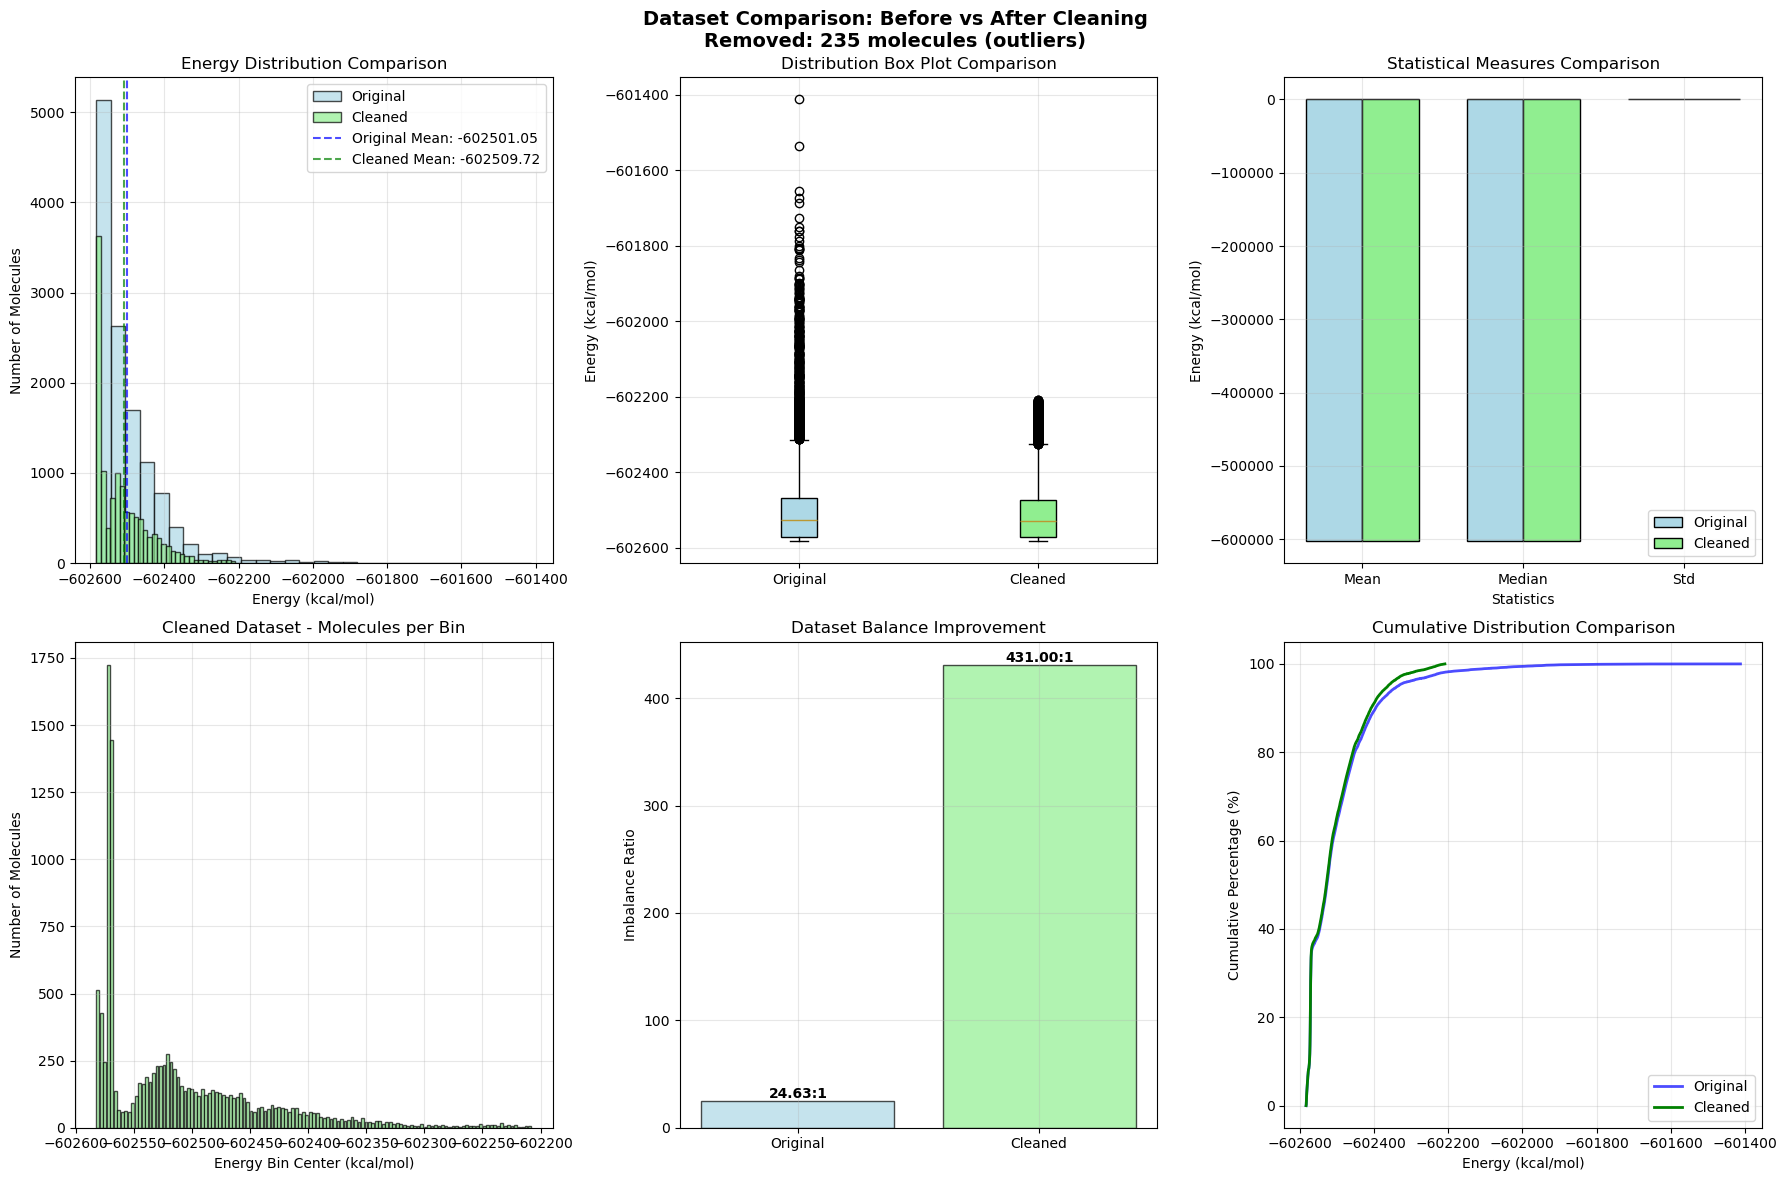


BALANCE ANALYSIS
--------------------
Original imbalance ratio: 24.63:1
Cleaned imbalance ratio:  431.00:1
No significant balance improvement

RECOMMENDATIONS
---------------
Dataset still highly imbalanced after cleaning
Consider: stratified sampling, synthetic data generation, or weighted training

CLEANING COMPLETE!
Updated results stored in 'cleaned_results' dictionary
Use cleaned_results['molecule_data'] for cleaned molecule energies
Use cleaned_results['removed_molecules'] for removed molecule IDs
Use cleaned_results['comparison_stats'] for before/after comparison


In [6]:
"""
Dataset Cleaning and Re-analysis
=================================

This cell removes specified molecules (outliers or custom selection) from the dataset
and provides updated distribution analysis with before/after comparisons.

Dependencies: pandas, numpy, matplotlib, seaborn
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

def clean_dataset_and_reanalyze(csv_file, results, removal_criteria='outliers', 
                               custom_molecules_to_remove=None, bin_width=1.0,
                               energy_col='energy_kcal_mol', molecule_col='molecule_id',
                               save_cleaned_csv=True, output_filename=None):
    """
    Remove specified molecules from dataset and perform re-analysis.
    
    Parameters:
    -----------
    csv_file : str
        Path to original CSV file
    results : dict
        Results dictionary from initial analysis
    removal_criteria : str
        Criteria for removal: 'outliers', 'custom', 'high_energy', 'low_energy', 'none'
    custom_molecules_to_remove : list
        List of specific molecule IDs to remove (used when criteria='custom')
    bin_width : float
        Energy bin width for re-analysis
    energy_col : str
        Energy column name
    molecule_col : str
        Molecule ID column name
    save_cleaned_csv : bool
        Whether to save cleaned dataset to new CSV
    output_filename : str
        Custom filename for cleaned CSV
    
    Returns:
    --------
    dict : Updated analysis results for cleaned dataset
    """
    
    print("DATASET CLEANING AND RE-ANALYSIS")
    print("=" * 50)
    
    # Load original dataset
    try:
        df_original = pd.read_csv(csv_file)
        print(f"Original dataset loaded: {len(df_original):,} rows")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None
    
    # Get original molecule data
    original_molecules = df_original.groupby(molecule_col)[energy_col].first().reset_index()
    original_molecules.columns = ['molecule_id', 'energy']
    print(f"Original molecules: {len(original_molecules):,}")
    
    # Determine molecules to remove
    molecules_to_remove = []
    
    if removal_criteria == 'outliers':
        if results and 'outliers' in results:
            molecules_to_remove = results['outliers']
            print(f"Removing {len(molecules_to_remove)} outlier molecules")
        else:
            print("No outliers found in results - no molecules will be removed")
    
    elif removal_criteria == 'custom':
        if custom_molecules_to_remove:
            molecules_to_remove = custom_molecules_to_remove
            print(f"Removing {len(molecules_to_remove)} custom-specified molecules")
        else:
            print("No custom molecules specified - no molecules will be removed")
    
    elif removal_criteria == 'high_energy':
        # Remove top 5% highest energy molecules
        n_to_remove = max(1, int(0.05 * len(original_molecules)))
        high_energy_mols = original_molecules.nlargest(n_to_remove, 'energy')
        molecules_to_remove = high_energy_mols['molecule_id'].tolist()
        print(f"Removing top {n_to_remove} highest energy molecules (top 5%)")
    
    elif removal_criteria == 'low_energy':
        # Remove bottom 5% lowest energy molecules
        n_to_remove = max(1, int(0.05 * len(original_molecules)))
        low_energy_mols = original_molecules.nsmallest(n_to_remove, 'energy')
        molecules_to_remove = low_energy_mols['molecule_id'].tolist()
        print(f"Removing bottom {n_to_remove} lowest energy molecules (bottom 5%)")
    
    elif removal_criteria == 'none':
        print("No molecules will be removed (criteria = 'none')")
        molecules_to_remove = []
    
    else:
        print(f"Unknown removal criteria: {removal_criteria}")
        print("Valid options: 'outliers', 'custom', 'high_energy', 'low_energy', 'none'")
        return None
    
    # Print molecules being removed
    if molecules_to_remove:
        print(f"\nMolecules to be removed:")
        for i, mol_id in enumerate(molecules_to_remove):
            mol_energy = original_molecules[original_molecules['molecule_id'] == mol_id]['energy']
            if not mol_energy.empty:
                print(f"  {i+1:2d}. {mol_id}: {mol_energy.iloc[0]:.3f} kcal/mol")
            else:
                print(f"  {i+1:2d}. {mol_id}: (energy not found)")
    
    # Create cleaned dataset
    df_cleaned = df_original[~df_original[molecule_col].isin(molecules_to_remove)].copy()
    
    # Get cleaned molecule data
    cleaned_molecules = df_cleaned.groupby(molecule_col)[energy_col].first().reset_index()
    cleaned_molecules.columns = ['molecule_id', 'energy']
    
    print(f"\nCleaned dataset:")
    print(f"  Rows removed: {len(df_original) - len(df_cleaned):,}")
    print(f"  Molecules removed: {len(original_molecules) - len(cleaned_molecules):,}")
    print(f"  Remaining rows: {len(df_cleaned):,}")
    print(f"  Remaining molecules: {len(cleaned_molecules):,}")
    print(f"  Retention rate: {len(cleaned_molecules)/len(original_molecules)*100:.1f}%")
    
    # Save cleaned dataset if requested
    if save_cleaned_csv:
        if output_filename is None:
            base_name = csv_file.replace('.csv', '')
            output_filename = f"{base_name}_cleaned.csv"
        
        df_cleaned.to_csv(output_filename, index=False)
        print(f"Cleaned dataset saved to: {output_filename}")
    
    # Perform re-analysis on cleaned dataset
    print(f"\nRE-ANALYZING CLEANED DATASET")
    print("-" * 30)
    
    energies_cleaned = cleaned_molecules['energy'].values
    energies_original = original_molecules['energy'].values
    
    # Calculate statistics for both datasets
    stats_original = {
        'min': np.min(energies_original),
        'max': np.max(energies_original),
        'mean': np.mean(energies_original),
        'median': np.median(energies_original),
        'std': np.std(energies_original),
        'range': np.max(energies_original) - np.min(energies_original)
    }
    
    stats_cleaned = {
        'min': np.min(energies_cleaned),
        'max': np.max(energies_cleaned),
        'mean': np.mean(energies_cleaned),
        'median': np.median(energies_cleaned),
        'std': np.std(energies_cleaned),
        'range': np.max(energies_cleaned) - np.min(energies_cleaned)
    }
    
    # Print comparison table
    print(f"{'Statistic':<15} {'Original':<12} {'Cleaned':<12} {'Change':<12}")
    print("-" * 55)
    for key in stats_original:
        original_val = stats_original[key]
        cleaned_val = stats_cleaned[key]
        change = cleaned_val - original_val
        change_pct = (change / original_val * 100) if original_val != 0 else 0
        
        print(f"{key.capitalize():<15} {original_val:<12.3f} {cleaned_val:<12.3f} "
              f"{change:+7.3f} ({change_pct:+5.1f}%)")
    
    # Create energy bins for cleaned dataset
    bin_start = np.floor(stats_cleaned['min'] / bin_width) * bin_width
    bin_end = np.ceil(stats_cleaned['max'] / bin_width) * bin_width
    bin_edges = np.arange(bin_start, bin_end + bin_width, bin_width)
    
    # Assign molecules to bins
    bin_indices = np.digitize(energies_cleaned, bin_edges) - 1
    bin_counts = np.bincount(bin_indices, minlength=len(bin_edges)-1)
    
    # Create bin information for cleaned dataset
    bins_info_cleaned = []
    for i, count in enumerate(bin_counts):
        bin_min = bin_edges[i]
        bin_max = bin_edges[i + 1]
        bin_center = (bin_min + bin_max) / 2
        
        mask = bin_indices == i
        bin_molecules = cleaned_molecules[mask]
        
        if count > 0:
            bin_mean = np.mean(bin_molecules['energy'])
            bin_std = np.std(bin_molecules['energy']) if count > 1 else 0.0
        else:
            bin_mean = bin_std = 0.0
        
        bins_info_cleaned.append({
            'bin_index': i,
            'bin_range': f"{bin_min:.1f} to {bin_max:.1f}",
            'bin_center': bin_center,
            'count': count,
            'percentage': (count / len(cleaned_molecules)) * 100,
            'mean_energy': bin_mean,
            'std_energy': bin_std,
            'molecules': bin_molecules['molecule_id'].tolist() if count > 0 else []
        })
    
    # Print bin summary for cleaned dataset
    non_empty_bins_cleaned = [b for b in bins_info_cleaned if b['count'] > 0]
    print(f"\nCLEANED DATASET BINS (width: {bin_width} kcal/mol)")
    print("-" * 60)
    print(f"{'Bin Range':<15} {'Count':<8} {'%':<6} {'Mean':<8} {'Std':<8}")
    print("-" * 60)
    
    for bin_info in non_empty_bins_cleaned:
        print(f"{bin_info['bin_range']:<15} "
              f"{bin_info['count']:<8d} "
              f"{bin_info['percentage']:<5.1f}% "
              f"{bin_info['mean_energy']:<7.2f} "
              f"{bin_info['std_energy']:<7.2f}")
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Dataset Comparison: Before vs After Cleaning\n'
                f'Removed: {len(molecules_to_remove)} molecules ({removal_criteria})', 
                fontsize=14, fontweight='bold')
    
    # 1. Histogram comparison
    ax1 = axes[0, 0]
    ax1.hist(energies_original, bins=30, alpha=0.7, label='Original', color='lightblue', edgecolor='black')
    ax1.hist(energies_cleaned, bins=30, alpha=0.7, label='Cleaned', color='lightgreen', edgecolor='black')
    ax1.axvline(stats_original['mean'], color='blue', linestyle='--', alpha=0.7, label=f'Original Mean: {stats_original["mean"]:.2f}')
    ax1.axvline(stats_cleaned['mean'], color='green', linestyle='--', alpha=0.7, label=f'Cleaned Mean: {stats_cleaned["mean"]:.2f}')
    ax1.set_xlabel('Energy (kcal/mol)')
    ax1.set_ylabel('Number of Molecules')
    ax1.set_title('Energy Distribution Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot comparison
    ax2 = axes[0, 1]
    box_data = [energies_original, energies_cleaned]
    box_labels = ['Original', 'Cleaned']
    box_plot = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('lightgreen')
    ax2.set_ylabel('Energy (kcal/mol)')
    ax2.set_title('Distribution Box Plot Comparison')
    ax2.grid(True, alpha=0.3)
    
    # 3. Statistics comparison bar chart
    ax3 = axes[0, 2]
    stats_names = ['Mean', 'Median', 'Std']
    original_vals = [stats_original['mean'], stats_original['median'], stats_original['std']]
    cleaned_vals = [stats_cleaned['mean'], stats_cleaned['median'], stats_cleaned['std']]
    
    x_pos = np.arange(len(stats_names))
    width = 0.35
    
    ax3.bar(x_pos - width/2, original_vals, width, label='Original', color='lightblue', edgecolor='black')
    ax3.bar(x_pos + width/2, cleaned_vals, width, label='Cleaned', color='lightgreen', edgecolor='black')
    ax3.set_xlabel('Statistics')
    ax3.set_ylabel('Energy (kcal/mol)')
    ax3.set_title('Statistical Measures Comparison')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(stats_names)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Cleaned dataset bin distribution
    ax4 = axes[1, 0]
    bin_centers = [b['bin_center'] for b in non_empty_bins_cleaned]
    bin_counts_plot = [b['count'] for b in non_empty_bins_cleaned]
    
    if bin_centers:
        bars = ax4.bar(bin_centers, bin_counts_plot, width=bin_width*0.8, 
                       edgecolor='black', alpha=0.7, color='lightgreen')
        
        # Add count labels if not too many bars
        if len(bin_centers) <= 15:
            for bar, count in zip(bars, bin_counts_plot):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + max(bin_counts_plot)*0.01,
                        f'{count}', ha='center', va='bottom', fontsize=9)
    
    ax4.set_xlabel('Energy Bin Center (kcal/mol)')
    ax4.set_ylabel('Number of Molecules')
    ax4.set_title('Cleaned Dataset - Molecules per Bin')
    ax4.grid(True, alpha=0.3)
    
    # 5. Balance improvement analysis
    ax5 = axes[1, 1]
    
    # Calculate balance metrics
    if bin_counts_plot:
        max_count_cleaned = max(bin_counts_plot)
        min_count_cleaned = min([c for c in bin_counts_plot if c > 0])
        imbalance_ratio_cleaned = max_count_cleaned / min_count_cleaned if min_count_cleaned > 0 else float('inf')
    else:
        max_count_cleaned = min_count_cleaned = imbalance_ratio_cleaned = 0
    
    # Get original balance metrics if available
    if results and 'balance_metrics' in results:
        imbalance_ratio_original = results['balance_metrics']['imbalance_ratio']
    else:
        imbalance_ratio_original = 1.0
    
    balance_comparison = ['Original', 'Cleaned']
    balance_ratios = [imbalance_ratio_original, imbalance_ratio_cleaned]
    
    bars = ax5.bar(balance_comparison, balance_ratios, color=['lightblue', 'lightgreen'], 
                   edgecolor='black', alpha=0.7)
    
    for bar, ratio in zip(bars, balance_ratios):
        height = bar.get_height()
        if np.isfinite(ratio):
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{ratio:.2f}:1', ha='center', va='bottom', fontweight='bold')
    
    ax5.set_ylabel('Imbalance Ratio')
    ax5.set_title('Dataset Balance Improvement')
    ax5.grid(True, alpha=0.3)
    
    # 6. Cumulative distribution comparison
    ax6 = axes[1, 2]
    sorted_energies_orig = np.sort(energies_original)
    sorted_energies_clean = np.sort(energies_cleaned)
    
    cumulative_orig = np.arange(1, len(sorted_energies_orig) + 1) / len(sorted_energies_orig) * 100
    cumulative_clean = np.arange(1, len(sorted_energies_clean) + 1) / len(sorted_energies_clean) * 100
    
    ax6.plot(sorted_energies_orig, cumulative_orig, linewidth=2, color='blue', label='Original', alpha=0.7)
    ax6.plot(sorted_energies_clean, cumulative_clean, linewidth=2, color='green', label='Cleaned')
    ax6.set_xlabel('Energy (kcal/mol)')
    ax6.set_ylabel('Cumulative Percentage (%)')
    ax6.set_title('Cumulative Distribution Comparison')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Balance analysis
    print(f"\nBALANCE ANALYSIS")
    print("-" * 20)
    print(f"Original imbalance ratio: {imbalance_ratio_original:.2f}:1")
    print(f"Cleaned imbalance ratio:  {imbalance_ratio_cleaned:.2f}:1")
    
    if imbalance_ratio_cleaned < imbalance_ratio_original:
        improvement = (imbalance_ratio_original - imbalance_ratio_cleaned) / imbalance_ratio_original * 100
        print(f"Balance improvement: {improvement:.1f}%")
    else:
        print("No significant balance improvement")
    
    # Recommendations
    print(f"\nRECOMMENDATIONS")
    print("-" * 15)
    if imbalance_ratio_cleaned > 10:
        print("Dataset still highly imbalanced after cleaning")
        print("Consider: stratified sampling, synthetic data generation, or weighted training")
    elif imbalance_ratio_cleaned > 3:
        print("Dataset moderately balanced after cleaning")
        print("Consider: stratified train/test splits")
    else:
        print("Dataset is well balanced after cleaning")
        print("Ready for standard ML training approaches")
    
    # Return updated results
    cleaned_results = {
        'dataset_info': {
            'csv_file': output_filename if save_cleaned_csv else csv_file,
            'total_molecules': len(cleaned_molecules),
            'total_atoms': len(df_cleaned),
            'bin_width': bin_width,
            'molecules_removed': len(molecules_to_remove),
            'removal_criteria': removal_criteria
        },
        'energy_stats': stats_cleaned,
        'bins': bins_info_cleaned,
        'outliers': [],  # No outliers in cleaned dataset by definition
        'balance_metrics': {
            'max_bin_count': max_count_cleaned,
            'min_bin_count': min_count_cleaned,
            'imbalance_ratio': imbalance_ratio_cleaned,
            'non_empty_bins': len(non_empty_bins_cleaned)
        },
        'molecule_data': cleaned_molecules,
        'removed_molecules': molecules_to_remove,
        'comparison_stats': {
            'original': stats_original,
            'cleaned': stats_cleaned,
            'improvement_metrics': {
                'balance_improvement_pct': (imbalance_ratio_original - imbalance_ratio_cleaned) / imbalance_ratio_original * 100 if imbalance_ratio_original > 0 else 0,
                'std_reduction_pct': (stats_original['std'] - stats_cleaned['std']) / stats_original['std'] * 100,
                'range_reduction_pct': (stats_original['range'] - stats_cleaned['range']) / stats_original['range'] * 100
            }
        }
    }
    
    return cleaned_results

# Example usage:
# ================================================================================

# Configuration - modify these parameters as needed
removal_criteria = 'outliers'  # Options: 'outliers', 'custom', 'high_energy', 'low_energy', 'none'

# For custom removal, specify molecule IDs:
custom_molecules = ['molecule001', 'molecule005', 'molecule123']  # Example list

# Run the cleaning and re-analysis
print("DATASET CLEANING CONFIGURATION")
print("-" * 30)
print(f"CSV file: {csv_file}")
print(f"Removal criteria: {removal_criteria}")
print(f"Bin width: {bin_width} kcal/mol")

cleaned_results = clean_dataset_and_reanalyze(
    csv_file=csv_file,
    results=results,  # From the first analysis cell
    removal_criteria=removal_criteria,
    custom_molecules_to_remove=custom_molecules if removal_criteria == 'custom' else None,
    bin_width=bin_width,  # Use same bin width as original analysis
    save_cleaned_csv=True,  # Save cleaned dataset
    output_filename='molecular_data_cleaned.csv'  # Custom filename
)

print(f"\nCLEANING COMPLETE!")
print(f"Updated results stored in 'cleaned_results' dictionary")
print(f"Use cleaned_results['molecule_data'] for cleaned molecule energies")
print(f"Use cleaned_results['removed_molecules'] for removed molecule IDs")
print(f"Use cleaned_results['comparison_stats'] for before/after comparison")

DATASET BALANCING CONFIGURATION
-----------------------------------
Input data: 12471 molecules
Strategy: gaussian_fit
Target molecules: Auto-calculate
Random seed: 42
Using cleaned dataset: 12236 molecules
🎯 DATASET BALANCING - UNDERSAMPLING
Original dataset: 12236 molecules
Non-empty bins: 125
Balancing strategy: gaussian_fit
Energy range: -602582.79 to -602208.87 kcal/mol
Energy distribution: μ=-602509.72, σ=73.22

📊 GAUSSIAN FIT STRATEGY
-------------------------
Target total molecules: 8565
Gaussian std multiplier: 1.5

🎲 SAMPLING MOLECULES FROM BINS
------------------------------
Bin -602583.0 to -602580.0:  513 →  101 ( 19.7% retained)
Bin -602580.0 to -602577.0:  426 →  103 ( 24.2% retained)
Bin -602577.0 to -602574.0:  244 →  105 ( 43.0% retained)
Bin -602574.0 to -602571.0: 1724 →  106 (  6.1% retained)
Bin -602571.0 to -602568.0: 1443 →  108 (  7.5% retained)
Bin -602568.0 to -602565.0:  135 →  110 ( 81.5% retained)
Bin -602565.0 to -602562.0:   65 →   65 (100.0% retained)
B

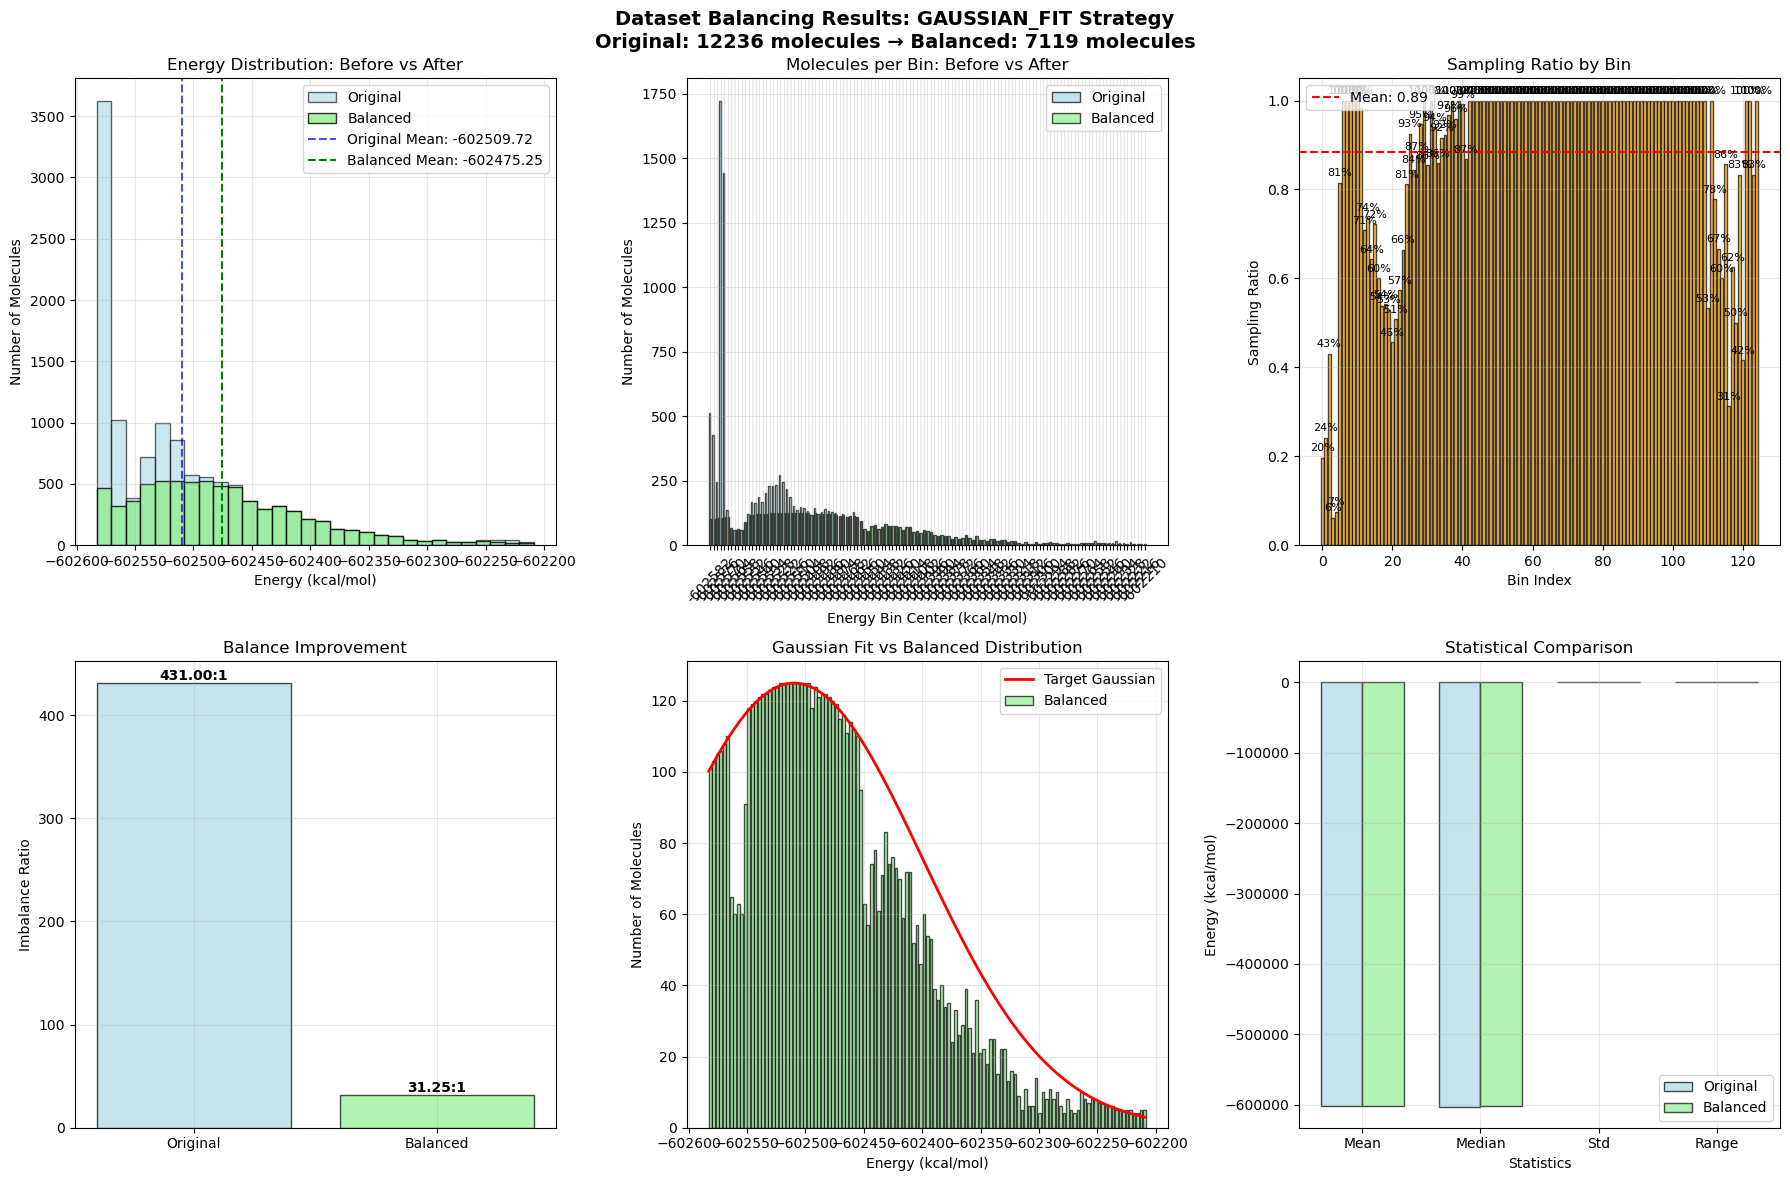


📊 BALANCING SUMMARY
-------------------------
Strategy: gaussian_fit
Original molecules: 12,236
Balanced molecules: 7,119
Reduction: 5,117 (41.8%)

Balance improvement:
  Original imbalance ratio: 431.00:1
  Balanced imbalance ratio: 31.25:1
  Improvement: 92.7%

Energy distribution changes:
  Mean: -602509.720 → -602475.253 (-0.0%)
  Std: 73.224 → 72.838 (-0.5%)
  Range: 373.921 → 373.921 (+0.0%)

BALANCING COMPLETE!
Results stored in 'balanced_results' dictionary
Use balanced_results['molecule_data'] for balanced molecule data
Use balanced_results['balancing_info'] for balancing details

To compare strategies, uncomment the following code:
# comparison = compare_balancing_strategies(results, ['uniform', 'gaussian_fit', 'sqrt_scaling'])


'\n# Compare multiple strategies\ncomparison_strategies = [\'uniform\', \'gaussian_fit\', \'sqrt_scaling\']\ncomparison_target = 1500  # Target molecules for comparison\n\nprint(f"\nRunning strategy comparison...")\ncomparison_results = compare_balancing_strategies(\n    results=results,\n    strategies=comparison_strategies, \n    target_molecules=comparison_target\n)\n'

In [7]:
"""
Dataset Balancing through Undersampling
=======================================

This cell provides multiple strategies to balance the molecular dataset by reducing
the number of molecules through intelligent undersampling techniques.

Dependencies: pandas, numpy, matplotlib, seaborn, scipy
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

def balance_dataset_undersampling(results, strategy='gaussian_fit', 
                                target_molecules=None, target_molecules_per_bin=None,
                                min_molecules_per_bin=10, max_molecules_per_bin=200,
                                gaussian_std_multiplier=2.0, kde_bandwidth=None,
                                random_seed=42, save_balanced_csv=True, 
                                output_filename='molecular_data_balanced.csv'):
    """
    Balance molecular dataset using various undersampling strategies.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from previous analysis (cleaned_results or original results)
    strategy : str
        Balancing strategy: 'gaussian_fit', 'uniform', 'kde_fit', 'sqrt_scaling', 'custom'
    target_molecules : int, optional
        Total number of molecules in final dataset (auto-calculated if None)
    target_molecules_per_bin : int, optional  
        Fixed number of molecules per bin (overrides target_molecules)
    min_molecules_per_bin : int
        Minimum molecules to keep per bin
    max_molecules_per_bin : int
        Maximum molecules to keep per bin
    gaussian_std_multiplier : float
        For gaussian_fit: controls width of sampling distribution
    kde_bandwidth : float, optional
        For kde_fit: kernel bandwidth (auto if None)
    random_seed : int
        Random seed for reproducibility
    save_balanced_csv : bool
        Whether to save balanced dataset to CSV
    output_filename : str
        Output CSV filename
        
    Returns:
    --------
    dict : Balanced dataset results with analysis
    """
    
    print("🎯 DATASET BALANCING - UNDERSAMPLING")
    print("=" * 50)
    
    if not results or 'molecule_data' not in results:
        print("❌ No results data available for balancing")
        return None
    
    np.random.seed(random_seed)
    
    # Get molecule data and bins
    molecule_data = results['molecule_data'].copy()
    bins_info = results['bins']
    non_empty_bins = [b for b in bins_info if b['count'] > 0]
    
    print(f"Original dataset: {len(molecule_data)} molecules")
    print(f"Non-empty bins: {len(non_empty_bins)}")
    print(f"Balancing strategy: {strategy}")
    
    # Calculate energy distribution statistics
    energies = molecule_data['energy'].values
    energy_mean = np.mean(energies)
    energy_std = np.std(energies)
    energy_min, energy_max = np.min(energies), np.max(energies)
    
    print(f"Energy range: {energy_min:.2f} to {energy_max:.2f} kcal/mol")
    print(f"Energy distribution: μ={energy_mean:.2f}, σ={energy_std:.2f}")
    
    # Strategy-specific target calculation
    balanced_molecules = []
    
    if strategy == 'gaussian_fit':
        # Fit Gaussian to energy distribution and sample according to it
        print(f"\n📊 GAUSSIAN FIT STRATEGY")
        print("-" * 25)
        
        # Calculate target distribution based on Gaussian fit
        def gaussian_target_counts(bin_centers, total_molecules):
            # Create ideal Gaussian distribution
            gaussian_weights = stats.norm.pdf(bin_centers, energy_mean, 
                                            energy_std * gaussian_std_multiplier)
            # Normalize to get target counts
            gaussian_weights = gaussian_weights / np.sum(gaussian_weights)
            target_counts = gaussian_weights * total_molecules
            return np.round(target_counts).astype(int)
        
        # Determine target total molecules
        if target_molecules is None:
            # Auto-calculate based on available data and balance requirements
            avg_current_count = np.mean([b['count'] for b in non_empty_bins])
            target_molecules = int(len(non_empty_bins) * avg_current_count * 0.7)  # 70% retention
        
        bin_centers = [b['bin_center'] for b in non_empty_bins]
        target_counts = gaussian_target_counts(bin_centers, target_molecules)
        
        print(f"Target total molecules: {target_molecules}")
        print(f"Gaussian std multiplier: {gaussian_std_multiplier}")
        
    elif strategy == 'uniform':
        # Equal number of molecules per bin
        print(f"\n⚖️ UNIFORM DISTRIBUTION STRATEGY")
        print("-" * 30)
        
        if target_molecules_per_bin is not None:
            target_per_bin = target_molecules_per_bin
        elif target_molecules is not None:
            target_per_bin = target_molecules // len(non_empty_bins)
        else:
            # Auto-calculate based on least populated bin with some buffer
            min_bin_count = min(b['count'] for b in non_empty_bins)
            target_per_bin = max(min_molecules_per_bin, 
                               min(max_molecules_per_bin, int(min_bin_count * 1.2)))
        
        target_counts = [target_per_bin] * len(non_empty_bins)
        target_molecules = sum(target_counts)
        
        print(f"Target molecules per bin: {target_per_bin}")
        print(f"Target total molecules: {target_molecules}")
        
    elif strategy == 'kde_fit':
        # Use Kernel Density Estimation to fit distribution
        print(f"\n🌊 KERNEL DENSITY ESTIMATION STRATEGY")
        print("-" * 35)
        
        # Fit KDE to energy distribution
        if kde_bandwidth is None:
            kde = gaussian_kde(energies)
        else:
            kde = gaussian_kde(energies, bw_method=kde_bandwidth)
        
        if target_molecules is None:
            avg_current_count = np.mean([b['count'] for b in non_empty_bins])
            target_molecules = int(len(non_empty_bins) * avg_current_count * 0.8)
        
        bin_centers = [b['bin_center'] for b in non_empty_bins]
        kde_weights = kde(bin_centers)
        kde_weights = kde_weights / np.sum(kde_weights)
        target_counts = np.round(kde_weights * target_molecules).astype(int)
        
        print(f"Target total molecules: {target_molecules}")
        print(f"KDE bandwidth: {kde.factor if kde_bandwidth is None else kde_bandwidth}")
        
    elif strategy == 'sqrt_scaling':
        # Square root scaling - reduces over-represented bins more aggressively
        print(f"\n📉 SQUARE ROOT SCALING STRATEGY")
        print("-" * 30)
        
        current_counts = [b['count'] for b in non_empty_bins]
        sqrt_counts = np.sqrt(current_counts)
        
        if target_molecules is None:
            target_molecules = int(np.sum(sqrt_counts) * 1.2)  # Some scaling factor
        
        # Scale sqrt counts to target total
        scaling_factor = target_molecules / np.sum(sqrt_counts)
        target_counts = np.round(sqrt_counts * scaling_factor).astype(int)
        
        print(f"Target total molecules: {target_molecules}")
        print(f"Scaling factor: {scaling_factor:.3f}")
        
    elif strategy == 'custom':
        # Custom user-defined targets
        print(f"\n🎛️ CUSTOM STRATEGY")
        print("-" * 15)
        
        if target_molecules_per_bin is not None:
            target_counts = [target_molecules_per_bin] * len(non_empty_bins)
        elif target_molecules is not None:
            # Distribute proportionally to current distribution but capped
            current_counts = [b['count'] for b in non_empty_bins]
            proportions = np.array(current_counts) / sum(current_counts)
            target_counts = np.round(proportions * target_molecules).astype(int)
        else:
            print("❌ Custom strategy requires either target_molecules or target_molecules_per_bin")
            return None
            
        target_molecules = sum(target_counts)
        print(f"Target total molecules: {target_molecules}")
        
    else:
        print(f"❌ Unknown strategy: {strategy}")
        return None
    
    # Apply constraints to target counts
    target_counts = np.clip(target_counts, min_molecules_per_bin, max_molecules_per_bin)
    
    # Sample molecules from each bin
    print(f"\n🎲 SAMPLING MOLECULES FROM BINS")
    print("-" * 30)
    
    balanced_bin_info = []
    total_selected = 0
    
    for i, (bin_info, target_count) in enumerate(zip(non_empty_bins, target_counts)):
        available_molecules = bin_info['molecules']
        current_count = len(available_molecules)
        
        # Determine how many to sample
        sample_count = min(target_count, current_count)
        
        if sample_count > 0:
            # Sample molecules from this bin
            if sample_count >= current_count:
                # Take all available molecules
                selected_molecules = available_molecules
            else:
                # Random sampling without replacement
                selected_molecules = np.random.choice(available_molecules, 
                                                    size=sample_count, 
                                                    replace=False).tolist()
            
            # Get energy data for selected molecules
            selected_energies = molecule_data[
                molecule_data['molecule_id'].isin(selected_molecules)
            ]['energy'].values
            
            # Create updated bin info
            updated_bin_info = bin_info.copy()
            updated_bin_info.update({
                'count': len(selected_molecules),
                'percentage': (len(selected_molecules) / target_molecules) * 100,
                'molecules': selected_molecules,
                'mean_energy': np.mean(selected_energies),
                'std_energy': np.std(selected_energies) if len(selected_energies) > 1 else 0.0,
                'min_energy': np.min(selected_energies),
                'max_energy': np.max(selected_energies),
                'original_count': current_count,
                'target_count': target_count,
                'sampling_ratio': len(selected_molecules) / current_count
            })
            
            balanced_bin_info.append(updated_bin_info)
            balanced_molecules.extend(selected_molecules)
            total_selected += len(selected_molecules)
            
            print(f"Bin {bin_info['bin_range']:>15}: {current_count:>4} → {len(selected_molecules):>4} "
                  f"({len(selected_molecules)/current_count*100:>5.1f}% retained)")
    
    print("-" * 50)
    print(f"Total molecules selected: {total_selected}")
    print(f"Overall retention rate: {total_selected/len(molecule_data)*100:.1f}%")
    
    # Create balanced molecule dataset
    balanced_molecule_data = molecule_data[
        molecule_data['molecule_id'].isin(balanced_molecules)
    ].copy().reset_index(drop=True)
    
    # Load and filter the full atomic CSV data
    csv_file = results['dataset_info']['csv_file']
    try:
        df_full = pd.read_csv(csv_file)
        df_balanced = df_full[df_full['molecule_id'].isin(balanced_molecules)].copy()
        
        if save_balanced_csv:
            df_balanced.to_csv(output_filename, index=False)
            print(f"✅ Balanced dataset saved to: {output_filename}")
            print(f"   Atomic rows: {len(df_balanced):,}")
            print(f"   Molecules: {len(balanced_molecules):,}")
            
    except Exception as e:
        print(f"⚠️ Warning: Could not save balanced CSV: {e}")
        df_balanced = None
    
    # Calculate balanced dataset statistics
    balanced_energies = balanced_molecule_data['energy'].values
    balanced_stats = {
        'min': np.min(balanced_energies),
        'max': np.max(balanced_energies),
        'mean': np.mean(balanced_energies),
        'median': np.median(balanced_energies),
        'std': np.std(balanced_energies),
        'range': np.max(balanced_energies) - np.min(balanced_energies)
    }
    
    # Calculate balance metrics
    bin_counts = [b['count'] for b in balanced_bin_info]
    max_count = max(bin_counts) if bin_counts else 0
    min_count = min([c for c in bin_counts if c > 0]) if bin_counts else 0
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Dataset Balancing Results: {strategy.upper()} Strategy\n'
                f'Original: {len(molecule_data)} molecules → Balanced: {total_selected} molecules', 
                fontsize=14, fontweight='bold')
    
    # 1. Before/After distribution comparison
    ax1 = axes[0, 0]
    ax1.hist(energies, bins=30, alpha=0.6, label='Original', color='lightblue', edgecolor='black')
    ax1.hist(balanced_energies, bins=30, alpha=0.8, label='Balanced', color='lightgreen', edgecolor='black')
    ax1.axvline(np.mean(energies), color='blue', linestyle='--', alpha=0.7, 
                label=f'Original Mean: {np.mean(energies):.2f}')
    ax1.axvline(np.mean(balanced_energies), color='green', linestyle='--', 
                label=f'Balanced Mean: {np.mean(balanced_energies):.2f}')
    ax1.set_xlabel('Energy (kcal/mol)')
    ax1.set_ylabel('Number of Molecules')
    ax1.set_title('Energy Distribution: Before vs After')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Bin count comparison
    ax2 = axes[0, 1]
    bin_centers = [b['bin_center'] for b in non_empty_bins]
    original_counts = [b['count'] for b in non_empty_bins]
    balanced_counts = [b['count'] for b in balanced_bin_info]
    
    x_pos = np.arange(len(bin_centers))
    width = 0.35
    
    ax2.bar(x_pos - width/2, original_counts, width, label='Original', 
            color='lightblue', edgecolor='black', alpha=0.7)
    ax2.bar(x_pos + width/2, balanced_counts, width, label='Balanced', 
            color='lightgreen', edgecolor='black', alpha=0.7)
    
    ax2.set_xlabel('Energy Bin Center (kcal/mol)')
    ax2.set_ylabel('Number of Molecules')
    ax2.set_title('Molecules per Bin: Before vs After')
    ax2.set_xticks(x_pos)
    
    # Format x-axis labels
    if len(bin_centers) <= 10:
        ax2.set_xticklabels([f'{c:.1f}' for c in bin_centers])
    else:
        ax2.set_xticklabels([f'{c:.0f}' if i % 2 == 0 else '' 
                            for i, c in enumerate(bin_centers)], rotation=45)
    
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Sampling ratios by bin
    ax3 = axes[0, 2]
    sampling_ratios = [b['sampling_ratio'] for b in balanced_bin_info]
    
    bars = ax3.bar(range(len(sampling_ratios)), sampling_ratios, 
                   color='orange', edgecolor='black', alpha=0.7)
    ax3.axhline(y=np.mean(sampling_ratios), color='red', linestyle='--', 
                label=f'Mean: {np.mean(sampling_ratios):.2f}')
    ax3.set_xlabel('Bin Index')
    ax3.set_ylabel('Sampling Ratio')
    ax3.set_title('Sampling Ratio by Bin')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for i, (bar, ratio) in enumerate(zip(bars, sampling_ratios)):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{ratio*100:.0f}%', ha='center', va='bottom', fontsize=8)
    
    # 4. Balance improvement
    ax4 = axes[1, 0]
    original_imbalance = results.get('balance_metrics', {}).get('imbalance_ratio', 1.0)
    balance_comparison = ['Original', 'Balanced']
    balance_ratios = [original_imbalance, imbalance_ratio]
    
    bars = ax4.bar(balance_comparison, balance_ratios, 
                   color=['lightblue', 'lightgreen'], edgecolor='black', alpha=0.7)
    
    for bar, ratio in zip(bars, balance_ratios):
        height = bar.get_height()
        if np.isfinite(ratio):
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{ratio:.2f}:1', ha='center', va='bottom', fontweight='bold')
    
    ax4.set_ylabel('Imbalance Ratio')
    ax4.set_title('Balance Improvement')
    ax4.grid(True, alpha=0.3)
    
    # 5. Strategy-specific visualization
    ax5 = axes[1, 1]
    
    if strategy == 'gaussian_fit':
        # Show Gaussian fit vs actual distribution
        x_plot = np.linspace(energy_min, energy_max, 100)
        gaussian_fit = stats.norm.pdf(x_plot, energy_mean, energy_std * gaussian_std_multiplier)
        gaussian_fit = gaussian_fit / np.max(gaussian_fit) * max(balanced_counts)
        
        ax5.plot(x_plot, gaussian_fit, 'r-', linewidth=2, label='Target Gaussian')
        ax5.bar(bin_centers, balanced_counts, width=results['dataset_info']['bin_width']*0.8,
                alpha=0.7, color='lightgreen', edgecolor='black', label='Balanced')
        ax5.set_title('Gaussian Fit vs Balanced Distribution')
        
    elif strategy == 'kde_fit':
        # Show KDE fit vs balanced distribution  
        x_plot = np.linspace(energy_min, energy_max, 100)
        kde_plot = kde(x_plot)
        kde_plot = kde_plot / np.max(kde_plot) * max(balanced_counts)
        
        ax5.plot(x_plot, kde_plot, 'r-', linewidth=2, label='KDE Target')
        ax5.bar(bin_centers, balanced_counts, width=results['dataset_info']['bin_width']*0.8,
                alpha=0.7, color='lightgreen', edgecolor='black', label='Balanced')
        ax5.set_title('KDE Fit vs Balanced Distribution')
        
    else:
        # Show target vs actual counts
        target_counts_plot = target_counts[:len(balanced_counts)]  # In case of length mismatch
        x_pos = np.arange(len(target_counts_plot))
        width = 0.35
        
        ax5.bar(x_pos - width/2, target_counts_plot, width, label='Target', 
                color='orange', edgecolor='black', alpha=0.7)
        ax5.bar(x_pos + width/2, balanced_counts, width, label='Actual', 
                color='lightgreen', edgecolor='black', alpha=0.7)
        ax5.set_title('Target vs Actual Bin Counts')
    
    ax5.set_xlabel('Energy (kcal/mol)' if strategy in ['gaussian_fit', 'kde_fit'] else 'Bin Index')
    ax5.set_ylabel('Number of Molecules')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Statistical comparison
    ax6 = axes[1, 2]
    stats_names = ['Mean', 'Median', 'Std', 'Range']
    original_vals = [results['energy_stats']['mean'], results['energy_stats']['median'], 
                    results['energy_stats']['std'], results['energy_stats']['range']]
    balanced_vals = [balanced_stats['mean'], balanced_stats['median'], 
                    balanced_stats['std'], balanced_stats['range']]
    
    x_pos = np.arange(len(stats_names))
    width = 0.35
    
    ax6.bar(x_pos - width/2, original_vals, width, label='Original', 
            color='lightblue', edgecolor='black', alpha=0.7)
    ax6.bar(x_pos + width/2, balanced_vals, width, label='Balanced', 
            color='lightgreen', edgecolor='black', alpha=0.7)
    ax6.set_xlabel('Statistics')
    ax6.set_ylabel('Energy (kcal/mol)')
    ax6.set_title('Statistical Comparison')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(stats_names)
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 BALANCING SUMMARY")
    print("-" * 25)
    print(f"Strategy: {strategy}")
    print(f"Original molecules: {len(molecule_data):,}")
    print(f"Balanced molecules: {total_selected:,}")
    print(f"Reduction: {len(molecule_data) - total_selected:,} ({(1-total_selected/len(molecule_data))*100:.1f}%)")
    print(f"")
    print(f"Balance improvement:")
    print(f"  Original imbalance ratio: {original_imbalance:.2f}:1")
    print(f"  Balanced imbalance ratio: {imbalance_ratio:.2f}:1")
    if original_imbalance > imbalance_ratio:
        improvement = (original_imbalance - imbalance_ratio) / original_imbalance * 100
        print(f"  Improvement: {improvement:.1f}%")
    else:
        print(f"  No significant improvement")
    
    print(f"\nEnergy distribution changes:")
    for stat_name in ['mean', 'std', 'range']:
        orig_val = results['energy_stats'][stat_name]
        bal_val = balanced_stats[stat_name]
        change_pct = (bal_val - orig_val) / orig_val * 100
        print(f"  {stat_name.capitalize()}: {orig_val:.3f} → {bal_val:.3f} ({change_pct:+.1f}%)")
    
    # Create return dictionary
    balanced_results = {
        'dataset_info': {
            'csv_file': output_filename,
            'original_csv': results['dataset_info']['csv_file'],
            'total_molecules': total_selected,
            'total_atoms': len(df_balanced) if df_balanced is not None else 0,
            'bin_width': results['dataset_info']['bin_width'],
            'balancing_strategy': strategy,
            'original_molecule_count': len(molecule_data),
            'reduction_count': len(molecule_data) - total_selected,
            'retention_rate': total_selected / len(molecule_data)
        },
        'energy_stats': balanced_stats,
        'bins': balanced_bin_info,
        'balance_metrics': {
            'max_bin_count': max_count,
            'min_bin_count': min_count,
            'imbalance_ratio': imbalance_ratio,
            'non_empty_bins': len(balanced_bin_info),
            'original_imbalance_ratio': original_imbalance
        },
        'molecule_data': balanced_molecule_data,
        'balancing_info': {
            'strategy': strategy,
            'parameters': {
                'target_molecules': target_molecules,
                'target_molecules_per_bin': target_molecules_per_bin,
                'min_molecules_per_bin': min_molecules_per_bin,
                'max_molecules_per_bin': max_molecules_per_bin,
                'gaussian_std_multiplier': gaussian_std_multiplier,
                'kde_bandwidth': kde_bandwidth,
                'random_seed': random_seed
            },
            'target_counts': target_counts.tolist(),
            'actual_counts': [b['count'] for b in balanced_bin_info],
            'sampling_ratios': [b['sampling_ratio'] for b in balanced_bin_info]
        }
    }
    
    return balanced_results

# Example usage and strategy comparison function
def compare_balancing_strategies(results, strategies=['uniform', 'gaussian_fit', 'sqrt_scaling'], 
                               target_molecules=1000):
    """
    Compare different balancing strategies side by side.
    """
    print("🔬 STRATEGY COMPARISON")
    print("=" * 30)
    
    strategy_results = {}
    
    for strategy in strategies:
        print(f"\nTesting strategy: {strategy}")
        print("-" * 20)
        
        balanced_result = balance_dataset_undersampling(
            results=results,
            strategy=strategy,
            target_molecules=target_molecules,
            save_balanced_csv=False  # Don't save during comparison
        )
        
        if balanced_result:
            strategy_results[strategy] = balanced_result
            print(f"✅ {strategy}: {balanced_result['dataset_info']['total_molecules']} molecules, "
                  f"imbalance ratio {balanced_result['balance_metrics']['imbalance_ratio']:.2f}:1")
    
    # Create comparison plot
    if strategy_results:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Balancing Strategy Comparison', fontsize=14, fontweight='bold')
        
        strategies_list = list(strategy_results.keys())
        colors = ['lightblue', 'lightgreen', 'orange', 'pink']
        
        # Plot 1: Imbalance ratios
        ax1 = axes[0]
        imbalance_ratios = [strategy_results[s]['balance_metrics']['imbalance_ratio'] 
                           for s in strategies_list]
        bars = ax1.bar(strategies_list, imbalance_ratios, color=colors[:len(strategies_list)],
                      edgecolor='black', alpha=0.7)
        ax1.set_ylabel('Imbalance Ratio')
        ax1.set_title('Balance Quality Comparison')
        ax1.grid(True, alpha=0.3)
        
        for bar, ratio in zip(bars, imbalance_ratios):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{ratio:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 2: Molecule count
        ax2 = axes[1]
        molecule_counts = [strategy_results[s]['dataset_info']['total_molecules'] 
                          for s in strategies_list]
        bars = ax2.bar(strategies_list, molecule_counts, color=colors[:len(strategies_list)],
                      edgecolor='black', alpha=0.7)
        ax2.set_ylabel('Number of Molecules')
        ax2.set_title('Final Dataset Size')
        ax2.grid(True, alpha=0.3)
        
        for bar, count in zip(bars, molecule_counts):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + max(molecule_counts)*0.01,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 3: Standard deviation preservation
        ax3 = axes[2]
        original_std = results['energy_stats']['std']
        std_ratios = [strategy_results[s]['energy_stats']['std'] / original_std 
                     for s in strategies_list]
        bars = ax3.bar(strategies_list, std_ratios, color=colors[:len(strategies_list)],
                      edgecolor='black', alpha=0.7)
        ax3.axhline(y=1.0, color='red', linestyle='--', label='Original Std')
        ax3.set_ylabel('Std Ratio (Balanced/Original)')
        ax3.set_title('Energy Distribution Preservation')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        for bar, ratio in zip(bars, std_ratios):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{ratio:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print comparison table
        print(f"\n📊 STRATEGY COMPARISON TABLE")
        print("-" * 70)
        print(f"{'Strategy':<12} {'Molecules':<10} {'Imbalance':<12} {'Std Ratio':<12} {'Mean Δ':<10}")
        print("-" * 70)
        
        for strategy in strategies_list:
            result = strategy_results[strategy]
            molecules = result['dataset_info']['total_molecules']
            imbalance = result['balance_metrics']['imbalance_ratio']
            std_ratio = result['energy_stats']['std'] / results['energy_stats']['std']
            mean_change = result['energy_stats']['mean'] - results['energy_stats']['mean']
            
            print(f"{strategy:<12} {molecules:<10d} {imbalance:<11.2f} {std_ratio:<11.2f} {mean_change:<+9.3f}")
        
        print("-" * 70)
        
        # Recommendations
        print(f"\nRECOMMENDATIONS:")
        best_balance = min(strategies_list, key=lambda s: strategy_results[s]['balance_metrics']['imbalance_ratio'])
        best_preservation = min(strategies_list, key=lambda s: abs(strategy_results[s]['energy_stats']['std'] / results['energy_stats']['std'] - 1.0))
        
        print(f"  Best balance: {best_balance} (imbalance ratio: {strategy_results[best_balance]['balance_metrics']['imbalance_ratio']:.2f})")
        print(f"  Best distribution preservation: {best_preservation}")
        
        return strategy_results
    
    return None

# ================================================================================
# EXECUTION SECTION - Configure your balancing parameters here
# ================================================================================

# Configuration parameters - modify these as needed
balancing_strategy = 'gaussian_fit'  # Options: 'gaussian_fit', 'uniform', 'kde_fit', 'sqrt_scaling', 'custom'

# Target size options (choose one approach):
target_molecules = None           # Auto-calculate based on strategy (recommended)
# target_molecules = 2000         # Fixed total number of molecules
# target_molecules_per_bin = 50   # Fixed molecules per bin (overrides target_molecules)

# Strategy-specific parameters
gaussian_std_multiplier = 1.5    # For gaussian_fit: controls distribution width (1.0 = original std)
kde_bandwidth = None             # For kde_fit: kernel bandwidth (None = auto)
min_molecules_per_bin = 5        # Minimum molecules to keep per bin
max_molecules_per_bin = 150      # Maximum molecules to keep per bin

# Other settings
random_seed = 42                 # For reproducibility
save_csv = True                  # Save balanced dataset
output_filename = 'molecular_data_balanced.csv'

print("DATASET BALANCING CONFIGURATION")
print("-" * 35)
print(f"Input data: {len(results['molecule_data']) if 'results' in globals() and results else 'No results available'} molecules")
print(f"Strategy: {balancing_strategy}")
print(f"Target molecules: {target_molecules or 'Auto-calculate'}")
print(f"Random seed: {random_seed}")

# Determine which results to use (prioritize cleaned data)
input_results = None
if 'cleaned_results' in globals() and cleaned_results:
    input_results = cleaned_results
    print(f"Using cleaned dataset: {len(cleaned_results['molecule_data'])} molecules")
elif 'results' in globals() and results:
    input_results = results
    print(f"Using original dataset: {len(results['molecule_data'])} molecules")
else:
    print("\nERROR: No results available!")
    print("Please run the energy distribution analysis cell first to generate 'results' dictionary.")
    print("If you've cleaned the data, make sure 'cleaned_results' is available.")

if input_results:
    # Run the balancing
    balanced_results = balance_dataset_undersampling(
        results=input_results,  # Use cleaned_results if available, otherwise original results
        strategy=balancing_strategy,
        target_molecules=target_molecules,
        target_molecules_per_bin=globals().get('target_molecules_per_bin'),
        min_molecules_per_bin=min_molecules_per_bin,
        max_molecules_per_bin=max_molecules_per_bin,
        gaussian_std_multiplier=gaussian_std_multiplier,
        kde_bandwidth=kde_bandwidth,
        random_seed=random_seed,
        save_balanced_csv=save_csv,
        output_filename=output_filename
    )

    if balanced_results:
        print(f"\nBALANCING COMPLETE!")
        print(f"Results stored in 'balanced_results' dictionary")
        print(f"Use balanced_results['molecule_data'] for balanced molecule data")
        print(f"Use balanced_results['balancing_info'] for balancing details")
        
        # Optional: Compare multiple strategies
        print(f"\nTo compare strategies, uncomment the following code:")
        print(f"# comparison = compare_balancing_strategies(results, ['uniform', 'gaussian_fit', 'sqrt_scaling'])")

# Optional strategy comparison (uncomment to run)
"""
# Compare multiple strategies
comparison_strategies = ['uniform', 'gaussian_fit', 'sqrt_scaling']
comparison_target = 1500  # Target molecules for comparison

print(f"\nRunning strategy comparison...")
comparison_results = compare_balancing_strategies(
    results=results,
    strategies=comparison_strategies, 
    target_molecules=comparison_target
)
"""

## Dataset Balancing through Quality Scoring
=======================================

Scoring (Starts at 1.00, subtract):
- Tiny "floater" fragment: -0.20 (>= 3 fragments and the smallest is 1 atom)
- Severe clash: -0.20 (any non-bonded pair with distance < 0.6*(r_cov,i + r_cov,j))
- Extreme per-atom charge: -0.15 (any |q_i| > 1.2 e)
- Big net charge (if supposed neutral): -0.10 (|sum q| > 0.5 e)
- Soft energy outlier (as defined in §1 band): -0.10  
Then clamp to [0, 1].

Dependencies: pandas, numpy, matplotlib, seaborn, scipy

✅ Loaded 74,826 atomic entries across 12,471 molecules


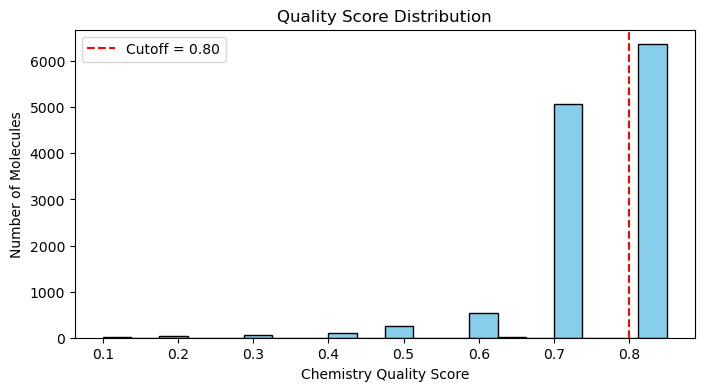

🧪 Kept 6,364/12,471 molecules with quality ≥ 0.8
💾 Saved per-molecule quality scores → molecular_quality_scores.csv
✅ Saved filtered molecules → molecular_data_filtered_chemistry.csv

✂️  Trimming tails and balancing energy bins...
Removed tails outside 5–95th percentile (-602581.2 to -602453.7)
Remaining molecules: 5,726
📉 Reduced from 6,364 → 770 molecules after trimming + bin balancing


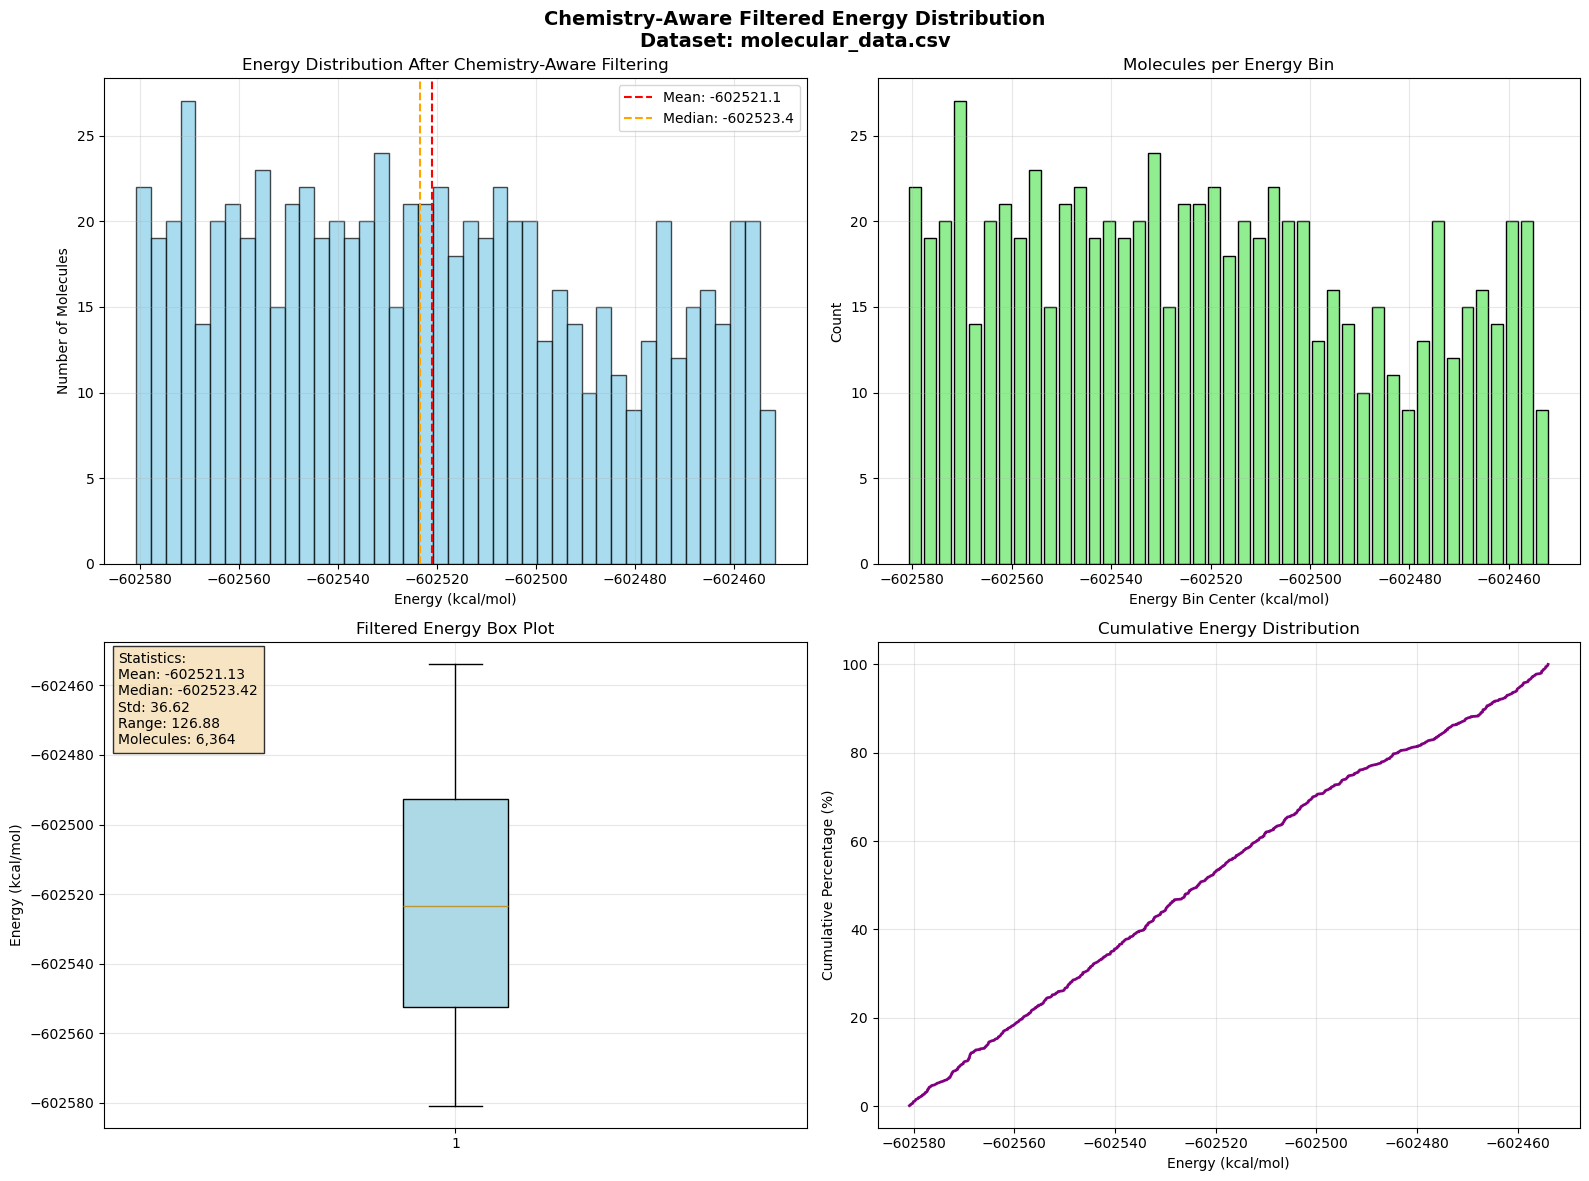

In [8]:
"""
5) Simple "Quality Score" (CSV-only) — keep some messy data, drop only the worst
===============================================================================

Goal:
  Score each reaction state/system from 0–1 using only CSV info.
  We do NOT auto-delete multi-fragment cases; we only drop physically impossible ones
  and down-weight the rest via a subtractive score.

Scoring (start at 1.00; subtract these flags if triggered):
  - Tiny "floater" fragment: -0.20  (>= 3 fragments and the smallest is 1 atom)
  - Severe clash: -0.20  (any non-bonded distance < 0.6*(r_cov,i + r_cov,j))
  - Extreme per-atom charge: -0.15  (any |q_i| > 1.2 e)
  - Big net charge (if supposed neutral): -0.10  (|sum q| > 0.5 e)
  - Soft energy outlier (per §1 band/IQR): -0.10
  → Then clamp final score to [0, 1].

Hard fails (drop outright):
  - Ridiculous clash: any distance < 0.4*(r_cov,i + r_cov,j)
  - Absurd charge: any |q| > 2.0 e

Selection policy per bin:
  - Keep the top ~90% by quality_score.
  - From the bottom ~10% ("messy" pool), sample 25% to deliberately keep some imperfect cases.
  - Hard fails are never kept.

One-liner for Methods:
  "Multi-fragment reaction states are kept; we only remove physically impossible cases and down-weight the rest."
"""



"""
Chemistry-Aware Quality Filtering + Visualization
=================================================

This script computes a chemistry-aware quality score per molecule
using bonding, charge, and geometry rules, then keeps the high-quality
structures for CNN training. It also generates diagnostic plots.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
INPUT_FILE = 'molecular_data.csv'
OUTPUT_FILE = 'molecular_data_filtered_chemistry.csv'
ENERGY_COL = 'energy_kcal_mol'
CHARGE_COL = 'charge'
MOLECULE_COL = 'molecule_id'
BIN_WIDTH = 3.0

# --- CHEMICAL CONSTANTS ---
radii = {
    1: 0.31, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57,
    15: 1.07, 16: 1.05, 17: 0.99, 35: 1.20, 53: 1.39
}

# --- LOAD DATA ---
df = pd.read_csv(INPUT_FILE)
print(f"✅ Loaded {len(df):,} atomic entries across {df[MOLECULE_COL].nunique():,} molecules")

# --- BASIC STATS FOR ENERGY (needed for outlier rule) ---
energies = df.groupby(MOLECULE_COL)[ENERGY_COL].first()
Q1, Q3 = np.percentile(energies, [25, 75])
IQR = Q3 - Q1

# --- HELPER FUNCTIONS ---
def build_bond_graph(coords, Z):
    """
    Build connectivity (bond) graph.

    Rule:
      Two atoms are considered bonded if their distance d_ij satisfies:
         0.8*(r_i + r_j) <= d_ij <= 1.25*(r_i + r_j)

    This provides a realistic bonding window based on covalent radii.
    """
    bonds = {i: set() for i in range(len(Z))}
    for i, j in combinations(range(len(Z)), 2):
        d = np.linalg.norm(coords[i] - coords[j])
        r_sum = radii.get(Z[i], 1.5) + radii.get(Z[j], 1.5)
        if 0.8 * r_sum <= d <= 1.25 * r_sum:
            bonds[i].add(j)
            bonds[j].add(i)
    return bonds


def get_fragments(bonds):
    """
    Identify disconnected fragments using depth-first search.
    Returns a list of atom sets (each fragment = connected component).
    """
    visited, frags = set(), []
    for i in bonds:
        if i in visited: continue
        stack, frag = [i], set()
        while stack:
            a = stack.pop()
            if a in visited: continue
            visited.add(a); frag.add(a)
            stack.extend(bonds[a])
        frags.append(frag)
    return frags

def chemistry_quality(mol):
    """
    Compute a molecule-level quality score (0-1).

    Each test is applied sequentially; any 'hard fail'
    returns 0.0 immediately. 
    """
     
    molid = mol[MOLECULE_COL].iloc[0]  # define for print statements
    coords = mol[['x','y','z']].values
    Z = mol['Z'].values
    q = mol[CHARGE_COL].values
    E = mol[ENERGY_COL].iloc[0]
    score = 1.0

    """
    ----------------------------------------------------------------
    🧪 1️⃣ Fragment Connectivity (“Floater Test”)
    ----------------------------------------------------------------
        Goal:
            Detect whether a molecule is fully connected or if it has stray atoms/fragments.

        How it works:
            • A bond graph is built by connecting atoms whose distance d_ij satisfies:
                0.8(r_i + r_j) ≤ d_ij ≤ 1.25(r_i + r_j)
            where r_i and r_j are covalent radii.
            • The code finds “connected components” (fragments).
            • If more than one fragment exists (e.g., a loose atom floating away), 
            it’s flagged and dropped.

        What it removes:
            Molecules like molecule11613, where a halogen atom drifts away 
            — representing a broken reaction state or incomplete optimization.

        Why it matters:
            CNNs and ML models can’t learn consistent chemistry from 
            disconnected or fragmented structures.
    """
    bonds = build_bond_graph(coords, Z)


    """
    ----------------------------------------------------------------
    ⚛️ 2️⃣ Geometric Clash Test
    ----------------------------------------------------------------
        Goal:
            Eliminate geometries where atoms are physically overlapping 
            or unrealistically close.

        How it works:
            • For every *non-bonded* atom pair, compute the scaled separation:
                s_ij = d_ij / (r_i + r_j)
            • Then classify:
                s < 0.4 → “ridiculous clash” (impossible overlap) → molecule dropped
                s < 0.55 → severe overlap → large penalty
                s < 0.8  → moderate overlap → small penalty

        What it removes:
            Geometries where atoms sit almost on top of each other, usually
            due to bad optimization or data corruption.

        Why it matters:
            These are physically impossible and break potential-energy surface
            continuity, making ML charge and energy predictions unreliable.
    """

    frags = get_fragments(bonds)
    if len(frags) >= 3 and min(len(f) for f in frags) == 1:
        score -= 0.20
    elif len(frags) == 2 and min(len(f) for f in frags) == 1:
        score -= 0.05


    """
    ----------------------------------------------------------------
    ⚡ 3️⃣ Charge Sanity Test
    ----------------------------------------------------------------
        Goal:
            Ensure both atomic and molecular charges remain within physical limits.

        How it works:
            • Per-atom absolute charge checked:
                |q_i| > 2.0 e → drop immediately (absurd)
                |q_i| > 1.2 e → subtract penalty (too polarized)
            • Total net charge checked:
                |Σq| > 0.5 e → penalize (should be roughly neutral)

        What it removes:
            Outliers where charge assignment failed or SCF convergence was poor.

        Why it matters:
            Excessive polarization or misassigned charges distort electrostatics
            and bias ML learning of structure–property relationships.
    """
    clash_penalty = 0
    for i, j in combinations(range(len(Z)), 2):
        d = np.linalg.norm(coords[i] - coords[j])
        r_sum = radii.get(Z[i], 1.5) + radii.get(Z[j], 1.5)
        s = d / r_sum

        if (j in bonds[i]):  # skip bonded atoms
            continue

        if s < 0.4:
            print(f"💀 Ridiculous clash in {molid}: atoms {i}-{j} (Z={Z[i]}-{Z[j]}), s={s:.3f}")
            return 0.0  # hard fail → drop molecule
        elif s < 0.55:
            clash_penalty += 0.5
        elif s < 0.6:
            clash_penalty += 0.3
        elif s < 0.8:
            clash_penalty += 0.1

    score -= min(clash_penalty, 0.6)

    """
    ----------------------------------------------------------------
    ⚙️ 4️⃣ Energy Outlier Test
     ----------------------------------------------------------------
        Goal:
            Catch molecules that are energetically unreasonable 
            (poorly optimized, wrong state, or corrupted).

        How it works:
            • Compute interquartile range (IQR) of molecular energies:
                IQR = Q3 − Q1
            • Apply two energy bands:
                Soft outlier:  E > Q3 + 1.5×IQR → small penalty
                Hard outlier:  E > Q3 + 3.0×IQR → drop outright

        What it removes:
            Structures with unphysically high energies, 
            such as dissociated fragments or incomplete optimizations.

        Why it matters:
            Outliers distort regression models by stretching target scale 
            and biasing fit toward rare unphysical states.
    """
    if np.max(np.abs(q)) > 2.0:
        return 0.0  # absurd → drop outright
    elif np.max(np.abs(q)) > 1.2:
        score -= 0.15

    # --- 5️⃣ Large net charge ---
    if abs(np.sum(q)) > 0.5:
        score -= 0.10


        """
        ----------------------------------------------------------------
        🔗 5️⃣ Bond-Length Realism Test
        ----------------------------------------------------------------
        Goal:
            Detect geometries with strained or broken bonds, even if connected.

        How it works:
            • For all bonded pairs (from the bond graph), compute:
                s = d_ij / (r_i + r_j)
            • Flag thresholds:
                “Tight bonds” (0.8 ≤ s < 0.9) → minor strain
                “Stretched bonds” (s > 1.25) → broken bond
            • If too many stretched or tight bonds exist, drop the molecule.

        What it removes:
            Distorted geometries that appear connected but are near bond
            dissociation or severe compression.

        Why it matters:
            Ensures each structure represents a realistic potential-energy 
            minimum, not a mid-reaction snapshot or numerical artifact.
        """
    # --- 6️⃣ Energy outlier ---
    if Q3 + 1.5*IQR < E <= Q3 + 3*IQR:
        score -= 0.10

    # --- Clamp score to [0, 1] ---
    return max(min(score, 1.0), 0.0)


# --- APPLY CHEMISTRY FILTER ---
scores = []
for mol_id in df[MOLECULE_COL].unique():
    mol = df[df[MOLECULE_COL]==mol_id]
    qscore = chemistry_quality(mol)
    scores.append((mol_id, qscore))

score_df = pd.DataFrame(scores, columns=[MOLECULE_COL, 'chem_quality'])

cutoff = 0.8

plt.figure(figsize=(8,4))
plt.hist(score_df['chem_quality'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(cutoff, color='red', linestyle='--', label=f'Cutoff = {cutoff:.2f}')
plt.title('Quality Score Distribution')
plt.xlabel('Chemistry Quality Score')
plt.ylabel('Number of Molecules')
plt.legend()
plt.show()

cutoff = 0.8
good_mols = score_df[score_df['chem_quality'] >= cutoff]
print(f"🧪 Kept {len(good_mols):,}/{len(score_df):,} molecules with quality ≥ {cutoff}")


# ============================================================
# ✅ SAVE QUALITY SCORES FOR FUTURE USE
# ============================================================

# Save per-molecule quality scores
score_df.to_csv("molecular_quality_scores.csv", index=False)
print(f"💾 Saved per-molecule quality scores → molecular_quality_scores.csv")

# Save the high-quality subset (for visualization / next steps)
good_mols = score_df[score_df["chem_quality"] >= cutoff]
df_filtered = df[df["molecule_id"].isin(good_mols["molecule_id"])]
df_filtered.to_csv("molecular_data_filtered_chemistry.csv", index=False)
print(f"✅ Saved filtered molecules → molecular_data_filtered_chemistry.csv")

# --- OPTIONAL: BALANCE OVERPOPULATED ENERGY BINS ---
# This step thins out bins that are too dense in the energy histogram.

# This step trims extreme tails and limits dense bins to ≤ 50 molecules.

BIN_LIMIT = 20     # maximum number of molecules per energy bin
BIN_WIDTH = 3.0    # same as earlier
TAIL_PERCENT = 5   # remove top & bottom 5%

print("\n✂️  Trimming tails and balancing energy bins...")

energies_per_mol = df_filtered.groupby(MOLECULE_COL)[ENERGY_COL].first()

# --- Step 1: Trim both high and low tails (5–95%) ---
low_cut = np.percentile(energies_per_mol, TAIL_PERCENT)
high_cut = np.percentile(energies_per_mol, 100 - TAIL_PERCENT)
trimmed_mols = energies_per_mol[(energies_per_mol >= low_cut) & (energies_per_mol <= high_cut)]

print(f"Removed tails outside {TAIL_PERCENT}–{100-TAIL_PERCENT}th percentile "
      f"({low_cut:.1f} to {high_cut:.1f})")
print(f"Remaining molecules: {len(trimmed_mols):,}")

# --- Step 2: Bin and downsample if needed ---
minE, maxE = np.min(trimmed_mols), np.max(trimmed_mols)
bins = np.arange(minE, maxE + BIN_WIDTH, BIN_WIDTH)
labels = np.digitize(trimmed_mols, bins)

balanced_mols = []
for b in np.unique(labels):
    mols_in_bin = trimmed_mols.index[labels == b]
    if len(mols_in_bin) > BIN_LIMIT:
        sampled = np.random.choice(mols_in_bin, BIN_LIMIT, replace=False)
        balanced_mols.extend(sampled)
    else:
        balanced_mols.extend(mols_in_bin)

df_balanced = df_filtered[df_filtered[MOLECULE_COL].isin(balanced_mols)]
print(f"📉 Reduced from {len(df_filtered[MOLECULE_COL].unique()):,} → "
      f"{len(df_balanced[MOLECULE_COL].unique()):,} molecules after trimming + bin balancing")

# overwrite the filtered file with balanced subset
df_balanced.to_csv(OUTPUT_FILE, index=False)

# --- VISUALIZATION (same as your old script) ---
energies_f = df_balanced.groupby(MOLECULE_COL)[ENERGY_COL].first().values
minE, maxE = np.min(energies_f), np.max(energies_f)
bin_edges = np.arange(minE, maxE + BIN_WIDTH, BIN_WIDTH)

plt.style.use('default')
sns.set_palette('husl')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Chemistry-Aware Filtered Energy Distribution\nDataset: {INPUT_FILE}', fontsize=14, fontweight='bold')

# 1️. Histogram
ax1 = axes[0, 0]
ax1.hist(energies_f, bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(energies_f), color='red', linestyle='--', label=f'Mean: {np.mean(energies_f):.1f}')
ax1.axvline(np.median(energies_f), color='orange', linestyle='--', label=f'Median: {np.median(energies_f):.1f}')
ax1.set_xlabel('Energy (kcal/mol)')
ax1.set_ylabel('Number of Molecules')
ax1.set_title('Energy Distribution After Chemistry-Aware Filtering')
ax1.legend(); ax1.grid(alpha=0.3)

# 2️. Molecules per bin
ax2 = axes[0, 1]
counts, bins = np.histogram(energies_f, bins=bin_edges)
ax2.bar((bins[:-1] + bins[1:]) / 2, counts, width=BIN_WIDTH * 0.8, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Energy Bin Center (kcal/mol)')
ax2.set_ylabel('Count')
ax2.set_title('Molecules per Energy Bin')
ax2.grid(alpha=0.3)

# 3️. Box plot
ax3 = axes[1, 0]
box = ax3.boxplot(energies_f, patch_artist=True)
box['boxes'][0].set_facecolor('lightblue')
stats_text = f"""Statistics:
Mean: {np.mean(energies_f):.2f}
Median: {np.median(energies_f):.2f}
Std: {np.std(energies_f):.2f}
Range: {maxE - minE:.2f}
Molecules: {len(good_mols):,}"""
ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, va='top',
         bbox=dict(facecolor='wheat', alpha=0.8))
ax3.set_ylabel('Energy (kcal/mol)')
ax3.set_title('Filtered Energy Box Plot')
ax3.grid(alpha=0.3)

# 4️. Cumulative distribution
ax4 = axes[1, 1]
sorted_E = np.sort(energies_f)
cdf = np.arange(1, len(sorted_E) + 1) / len(sorted_E) * 100
ax4.plot(sorted_E, cdf, color='purple', linewidth=2)
ax4.set_xlabel('Energy (kcal/mol)')
ax4.set_ylabel('Cumulative Percentage (%)')
ax4.set_title('Cumulative Energy Distribution')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## RMSD - User Input Molecules to Eliminate Bad Data
============================================

* Root-Mean-Square Deviation:
A mathematical measure of how different two sets of points are — in our case, the 3D atomic coordinates of two molecules.
It’s widely used in chemistry, biology, and materials science to compare structures — like protein conformations, reaction intermediates, or optimized molecular geometries.


In [ ]:
"""
Step 0 — Choosing a base molecule 
-------------------------------------------------------------
Creates a CSV using molecule12112 from the filtered dataset.
This ensures the “user molecule” matches your dataset’s structure.
"""
import pandas as pd

# Load your filtered chemistry dataset
df = pd.read_csv("molecular_data_filtered_chemistry.csv")

# Find molecule with the *most typical* energy (closest to median)
median_energy = df.groupby("molecule_id")["energy_kcal_mol"].first().median()

rep_id = (
    df.groupby("molecule_id")["energy_kcal_mol"]
    .first()
    .sub(median_energy)
    .abs()
    .idxmin()
)

print(f"✅ Selected representative molecule: {rep_id}")

# Save it as our new user/reference molecule
df[df["molecule_id"] == rep_id].to_csv("reference_molecule.csv", index=False)
print("💾 Saved representative molecule as 'reference_molecule.csv'")


✅ Selected representative molecule: molecule12112
💾 Saved representative molecule as 'reference_molecule.csv'


In [ ]:
"""
Step 1 — Generate Example User Molecule (from molecule12112)
-------------------------------------------------------------
Creates a CSV using molecule12112 from the filtered dataset.
This ensures the “user molecule” matches your dataset’s structure.
"""

import pandas as pd
import numpy as np
import os

def generate_correct_ch3cl2(filename="user_molecule.csv"):
    """Generate a physically realistic CH3Cl2 molecule."""
    # Idealized tetrahedral coordinates (Å)
    # Carbon at origin; two hydrogens and two chlorines spaced ~109.5° apart.
    atoms = [
        ("C", 6,  0.000,  0.000,  0.000),     # Carbon
        ("Cl",17,  1.770,  0.000,  0.000),    # Chlorine 1
        ("Cl",17, -0.590,  1.670,  0.000),    # Chlorine 2
        ("H", 1,  -0.590, -0.550,  0.940),    # Hydrogen 1
        ("H", 1,  -0.590, -0.550, -0.940),    # Hydrogen 2
        ("H", 1,  -0.890,  1.000,  0.000),    # Hydrogen 3
    ]

    df = pd.DataFrame(atoms, columns=["atom", "Z", "x", "y", "z"])
    df.insert(0, "atom_index", range(len(df)))
    df.insert(0, "molecule_id", "user_input")
    df["charge"] = 0.0
    df["energy_kcal_mol"] = -602520.0  # placeholder energy, close to dataset scale

    df.to_csv(filename, index=False)
    print(f"✅ Correct CH3Cl2 molecule created and saved as '{filename}'")
    return df

# Run it to create the user molecule CSV
user_df = generate_correct_ch3cl2()
user_df


✅ Correct CH3Cl2 molecule created and saved as 'user_molecule.csv'


,molecule_id,atom_index,atom,Z,x,y,z,charge,energy_kcal_mol
0,user_input,0,C,6,0.00,0.00,0.00,0.0,-602520.0
1,user_input,1,Cl,17,1.77,0.00,0.00,0.0,-602520.0
2,user_input,2,Cl,17,-0.59,1.67,0.00,0.0,-602520.0
3,user_input,3,H,1,-0.59,-0.55,0.94,0.0,-602520.0
4,user_input,4,H,1,-0.59,-0.55,-0.94,0.0,-602520.0
5,user_input,5,H,1,-0.89,1.00,0.00,0.0,-602520.0


In [ ]:
"""
Step 2 — Compare User Molecule to Filtered Dataset
===================================================

Compares a user molecule CSV (sample or uploaded) to the 
high-quality filtered dataset `molecular_data_filtered_chemistry.csv`
using RMSD (Root Mean Square Deviation).
"""

import numpy as np
import pandas as pd
import os


# --- RMSD helper --------------------------------------------------------------
def rmsd(A, B):
    """Compute RMSD between two Nx3 coordinate arrays after optimal rotation."""

    "(1) Center both molecules at their geometric center"
    A_centered = A - A.mean(axis=0)
    B_centered = B - B.mean(axis=0)

    "(2) Compute the covariance matrix H"
    H = A_centered.T @ B_centered

    "(3) Find the optimal rotation that aligns A to B"
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    "(5) Apply the rotation and compute RMSD"
    A_aligned = A_centered @ R
    return np.sqrt(np.mean(np.sum((A_aligned - B_centered) ** 2, axis=1)))


# --- Main comparison ----------------------------------------------------------
def compare_user_to_filtered_dataset(user_csv, filtered_dataset_csv="molecular_data_filtered_chemistry.csv"):
    """Compare a user-provided (or sample) molecule CSV to the filtered dataset."""
    
    # --- Load user molecule ---
    if not os.path.exists(user_csv):
        raise FileNotFoundError(f"❌ User molecule CSV not found: {user_csv}")
    user_df = pd.read_csv(user_csv)
    user_coords = user_df[['x', 'y', 'z']].values
    print(f"✅ Loaded user molecule '{user_csv}' with {len(user_coords)} atoms")

    # --- Load filtered dataset ---
    if not os.path.exists(filtered_dataset_csv):
        raise FileNotFoundError(f"❌ Filtered dataset not found: {filtered_dataset_csv}")
    df = pd.read_csv(filtered_dataset_csv)
    n_mols = df['molecule_id'].nunique()
    print(f"✅ Loaded filtered dataset '{filtered_dataset_csv}' ({n_mols} molecules)")

    # --- Compare each molecule ---
    results = []
    for mol_id, mol in df.groupby('molecule_id'):
        mol_coords = mol[['x', 'y', 'z']].values
        if mol_coords.shape != user_coords.shape:
            continue
        val = rmsd(mol_coords, user_coords)
        results.append((mol_id, val))

    if not results:
        print("⚠️ No comparable molecules found (atom count mismatch).")
        return pd.DataFrame(columns=['molecule_id', 'RMSD'])

    # --- Rank results & save ---
    df_results = pd.DataFrame(results, columns=['molecule_id', 'RMSD']).sort_values('RMSD')
    df_results.to_csv("rmsd_results_filtered.csv", index=False)
    print("\n🔍 Top 10 closest matches:")
    print(df_results.head(10))
    print(f"\n💾 Saved full RMSD table to 'rmsd_results_filtered.csv'")
    return df_results


# --- Run interactively --------------------------------------------------------
if __name__ == "__main__":
    print("Step 2 — Compare User Molecule to Filtered Dataset")
    print("=================================================\n")

    # Default dataset (filtered chemistry)
    filtered_dataset = "molecular_data_filtered_chemistry.csv"
    # Default sample molecule (CH₃Cl₂ from Step 1)
    # user_default = "user_molecule.csv"
    user_default = "scan_atomic_data.csv"

    # custom_path = input("Enter path to your molecule CSV (or press Enter to use sample CH3Cl2): ").strip()
    # user_file = custom_path if custom_path else user_default

    compare_user_to_filtered_dataset(user_file, filtered_dataset)
    print("\n✅ Comparison complete.")


Step 2 — Compare User Molecule to Filtered Dataset

✅ Loaded user molecule 'scan_atomic_data.csv' with 8058 atoms
✅ Loaded filtered dataset 'molecular_data_filtered_chemistry.csv' (770 molecules)
⚠️ No comparable molecules found (atom count mismatch).

✅ Comparison complete.


In [ ]:
"""
Step 3 — Run Molecule Comparison
=================================
Uses a user-provided molecule (or sample CH₃Cl₂) to compare
against the quality-filtered dataset using RMSD and optionally
filters molecules by similarity cutoff.
"""

import os
import pandas as pd


# --- MAIN SCRIPT --------------------------------------------------------------
if __name__ == "__main__":
    print("Step 3 — Run Molecule Comparison")
    print("================================\n")

    # File paths
    filtered_dataset = "molecular_data_filtered_chemistry.csv"
    user_default = "user_molecule.csv"   # CH3Cl2 sample

    # Get user molecule path
    user_path = input("Enter path to your molecule CSV (or press Enter to use sample CH3Cl2): ").strip()
    user_file = user_path if user_path else user_default

    # --- Run comparison ---
    print("\n⚙️ Running RMSD comparison...")
    results = compare_user_to_filtered_dataset(user_file, filtered_dataset)

    if results is None or results.empty:
        print("⚠️ No comparable molecules found.")
        exit()

    print("\n🎯 Step 3 complete!")


Step 3 — Run Molecule Comparison


⚙️ Running RMSD comparison...
✅ Loaded user molecule 'user_molecule.csv' with 6 atoms
✅ Loaded filtered dataset 'molecular_data_filtered_chemistry.csv' (770 molecules)

🔍 Top 10 closest matches:
      molecule_id      RMSD
413   molecule161  0.900795
0     molecule036  0.922247
410   molecule144  0.933323
9     molecule093  0.934140
1     molecule039  1.031680
457   molecule226  1.043585
400   molecule132  1.054578
3     molecule053  1.108484
11   molecule1012  1.143000
434  molecule1811  1.148000

💾 Saved full RMSD table to 'rmsd_results_filtered.csv'

🎯 Step 3 complete!


In [ ]:
"""
Step 4 — Filter Dataset by RMSD Threshold
------------------------------------------
Keeps only molecules similar to the user molecule.
"""

# Define how strict to be
RMSD_THRESHOLD = 0.20  # example cutoff
TOP_N = None  # alternatively, set to an integer (e.g., 50)

# Load the saved results
rmsd_df = pd.read_csv("rmsd_results_filtered.csv")

# Choose filter mode
if TOP_N:
    selected = rmsd_df.nsmallest(TOP_N, "RMSD")
else:
    selected = rmsd_df[rmsd_df["RMSD"] <= RMSD_THRESHOLD]

# Display summary
print(f"📉 Selected {len(selected)} molecules out of {len(rmsd_df)} "
      f"(RMSD ≤ {RMSD_THRESHOLD:.2f})")

# Load original dataset
df = pd.read_csv("molecular_data.csv")

# Keep only those molecules
filtered_df = df[df["molecule_id"].isin(selected["molecule_id"])]

# Save the reduced dataset
filtered_df.to_csv("molecular_data_similar_subset.csv", index=False)
print("✅ Saved filtered dataset as 'molecular_data_similar_subset.csv'")


📉 Selected 2 molecules out of 770 (RMSD ≤ 0.20)
✅ Saved filtered dataset as 'molecular_data_similar_subset.csv'


In [ ]:
import matplotlib.pyplot as plt

"""
Step 6 — Visual Summary
"""

plt.hist(rmsd_df["RMSD"], bins=30, color="skyblue", edgecolor="black")
plt.axvline(RMSD_THRESHOLD, color="red", linestyle="--", label=f"Threshold = {RMSD_THRESHOLD:.2f}")
plt.xlabel("RMSD")
plt.ylabel("Molecule Count")
plt.title("Distribution of RMSD Between User Molecule and Dataset")
plt.legend()
plt.show()


## RMSD - Perfect Molecules to Eliminate Bad Data
============================================

* Root-Mean-Square Deviation:
A mathematical measure of how different two sets of points are — in our case, the 3D atomic coordinates of two molecules.
It’s widely used in chemistry, biology, and materials science to compare structures — like protein conformations, reaction intermediates, or optimized molecular geometries.


In [9]:
"""
SN2 Reaction Path Cleanup Pipeline
---------------------------------

This script performs:

1. FAST clustering of the perfect dataset using Coulomb matrix eigenvalues
2. Auto-selection of cluster count using silhouette score
3. Extraction of cluster medoids (representative geometries)
4. Hungarian RMSD comparison of filtered dataset molecules to medoids
5. Saving cleaned dataset of molecules within an RMSD cutoff
"""

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# ============================================================
# PART A — Coulomb Matrix Eigenvalue Embedding
# ============================================================

def coulomb_matrix(coords, Z):
    n = len(Z)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i, i] = 0.5 * Z[i] ** 2.4
            else:
                dist = np.linalg.norm(coords[i] - coords[j])
                M[i, j] = (Z[i] * Z[j]) / dist
    return M


def molecule_embedding(coords, Z, k_eigs=20):
    """Return first k Coulomb matrix eigenvalues (sorted)."""
    M = coulomb_matrix(coords, Z)
    eigvals = np.linalg.eigvalsh(M)
    eigvals = np.sort(eigvals)[::-1]  # descending order
    if len(eigvals) < k_eigs:
        eigvals = np.pad(eigvals, (0, k_eigs - len(eigvals)))
    return eigvals[:k_eigs]


# ============================================================
# PART B — Load Perfect Dataset + Build Embeddings
# ============================================================

print("\n📁 Loading perfect dataset (scan_atomic_data.csv)...")
ref = pd.read_csv("scan_atomic_data.csv")

perfect_ids = ref["molecule_id"].unique()
print(f"Perfect dataset molecules: {len(perfect_ids)}")

embeddings = []

for mol_id in perfect_ids:
    mol = ref[ref["molecule_id"] == mol_id]
    coords = mol[['x','y','z']].values
    Z = mol['Z'].values
    emb = molecule_embedding(coords, Z)
    embeddings.append(emb)

embeddings = np.array(embeddings)


# ============================================================
# PART C — Auto-select Cluster Count (K) Using Silhouette Score
# ============================================================

print("\n🔍 Determining optimal cluster count using silhouette score...")

best_k = None
best_score = -1
best_labels = None

for k in range(2, 13):
    clust = AgglomerativeClustering(n_clusters=k, linkage="ward").fit(embeddings)
    score = silhouette_score(embeddings, clust.labels_)
    print(f"K={k} → silhouette={score:.3f}")

    if score > best_score:
        best_score = score
        best_k = k
        best_labels = clust.labels_

print(f"\n🏆 Optimal cluster count selected: K={best_k} (silhouette={best_score:.3f})")

cluster_labels = best_labels


# ============================================================
# PART D — Compute Cluster Medoids (Representative Molecules)
# ============================================================

print("\n📌 Computing cluster medoids...")

cluster_centroids = {}

for c in range(best_k):
    idx = np.where(cluster_labels == c)[0]
    cluster_emb = embeddings[idx]

    # pairwise distance inside cluster
    D = cdist(cluster_emb, cluster_emb, metric='euclidean')
    medoid_idx = idx[np.argmin(D.sum(axis=0))]  # lowest total distance

    mol_id = perfect_ids[medoid_idx]
    cluster_centroids[c] = mol_id

print("\nCluster Medoids:")
for c, m in cluster_centroids.items():
    print(f"  Cluster {c}: {m}")

# Store centroid structures
centroid_structs = {}

for c, mol_id in cluster_centroids.items():
    mol = ref[ref["molecule_id"] == mol_id]
    centroid_structs[c] = {
        "coords": mol[['x','y','z']].values,
        "Z": mol["Z"].values,
        "charges": mol["charge"].values
    }


# ============================================================
# PART E — Hungarian RMSD Function
# ============================================================

def hungarian_rmsd(coords1, coords2):
    """Compute RMSD using Hungarian matching (permutation-invariant)."""
    D = cdist(coords1, coords2)
    row_ind, col_ind = linear_sum_assignment(D)
    aligned = coords2[col_ind]
    return np.sqrt(np.mean(np.sum((coords1 - aligned)**2, axis=1)))


# ============================================================
# PART F — Compare Filtered Dataset to *All* Perfect References
# ============================================================

print("\n📁 Loading filtered dataset (molecular_data_filtered_chemistry.csv)...")
filtered = pd.read_csv("molecular_data_filtered_chemistry.csv")

filtered_ids = filtered["molecule_id"].unique()
print(f"Filtered dataset molecules: {len(filtered_ids)}")

# Build perfect geometry dictionary
print("\n📦 Preparing perfect-reference geometries...")
perfect_geometries = {
    mid: ref[ref["molecule_id"] == mid]
            .sort_values("atom_index")[["x","y","z"]].values
    for mid in perfect_ids
}

# Build filtered geometry dictionary
filtered_geometries = {
    mid: filtered[filtered["molecule_id"] == mid]
            .sort_values("atom_index")[["x","y","z"]].values
    for mid in filtered_ids
}

print("Geometry maps built.")

results = []

print("\n⚙️ Computing FULL RMSD to all perfect geometries (Version C)...")

for mol_id in filtered_ids:
    coords = filtered_geometries[mol_id]
    best_rmsd = float("inf")
    best_match = None

    for pid in perfect_ids:
        ref_coords = perfect_geometries[pid]

        # Ensure same atom count
        if ref_coords.shape[0] != coords.shape[0]:
            continue

        rms = hungarian_rmsd(coords, ref_coords)

        if rms < best_rmsd:
            best_rmsd = rms
            best_match = pid

    results.append((mol_id, best_match, best_rmsd))

df_results = pd.DataFrame(results, columns=["mol_id", "best_match", "rmsd"])
df_results.to_csv("filtered_vs_perfect_RMSD.csv", index=False)

print("\nTop RMSD matches:")
print(df_results.nsmallest(10, "rmsd"))



# ============================================================
# PART G — Apply RMSD Cutoff and Save Clean Dataset
# ============================================================

RMSD_CUTOFF = 2.5   # adjustable

keep_ids = df_results[df_results["rmsd"] <= RMSD_CUTOFF]["mol_id"]
final_df = filtered[filtered["molecule_id"].isin(keep_ids)]

final_df.to_csv("molecular_data_cleaned.csv", index=False)

print(f"\n🎯 Final cleaned dataset saved → molecular_data_cleaned.csv")
print(f"Kept {len(keep_ids)} out of {len(filtered_ids)} molecules (RMSD ≤ {RMSD_CUTOFF})")






📁 Loading perfect dataset (scan_atomic_data.csv)...
Perfect dataset molecules: 1343

🔍 Determining optimal cluster count using silhouette score...
K=2 → silhouette=1.000
K=3 → silhouette=0.990
K=4 → silhouette=0.988
K=5 → silhouette=0.967
K=6 → silhouette=0.967
K=7 → silhouette=0.967
K=8 → silhouette=0.957
K=9 → silhouette=0.478
K=10 → silhouette=0.477
K=11 → silhouette=0.496
K=12 → silhouette=0.496

🏆 Optimal cluster count selected: K=2 (silhouette=1.000)

📌 Computing cluster medoids...

Cluster Medoids:
  Cluster 0: SN2_-3.171
  Cluster 1: SN2_-2.319

📁 Loading filtered dataset (molecular_data_filtered_chemistry.csv)...
Filtered dataset molecules: 770

📦 Preparing perfect-reference geometries...
Geometry maps built.

⚙️ Computing FULL RMSD to all perfect geometries (Version C)...

Top RMSD matches:
         mol_id  best_match      rmsd
5   molecule060  SN2_-2.315  1.283801
7   molecule145  SN2_-2.315  1.288429
4   molecule059  SN2_-2.315  1.307358
2   molecule042  SN2_-2.315  1.3321

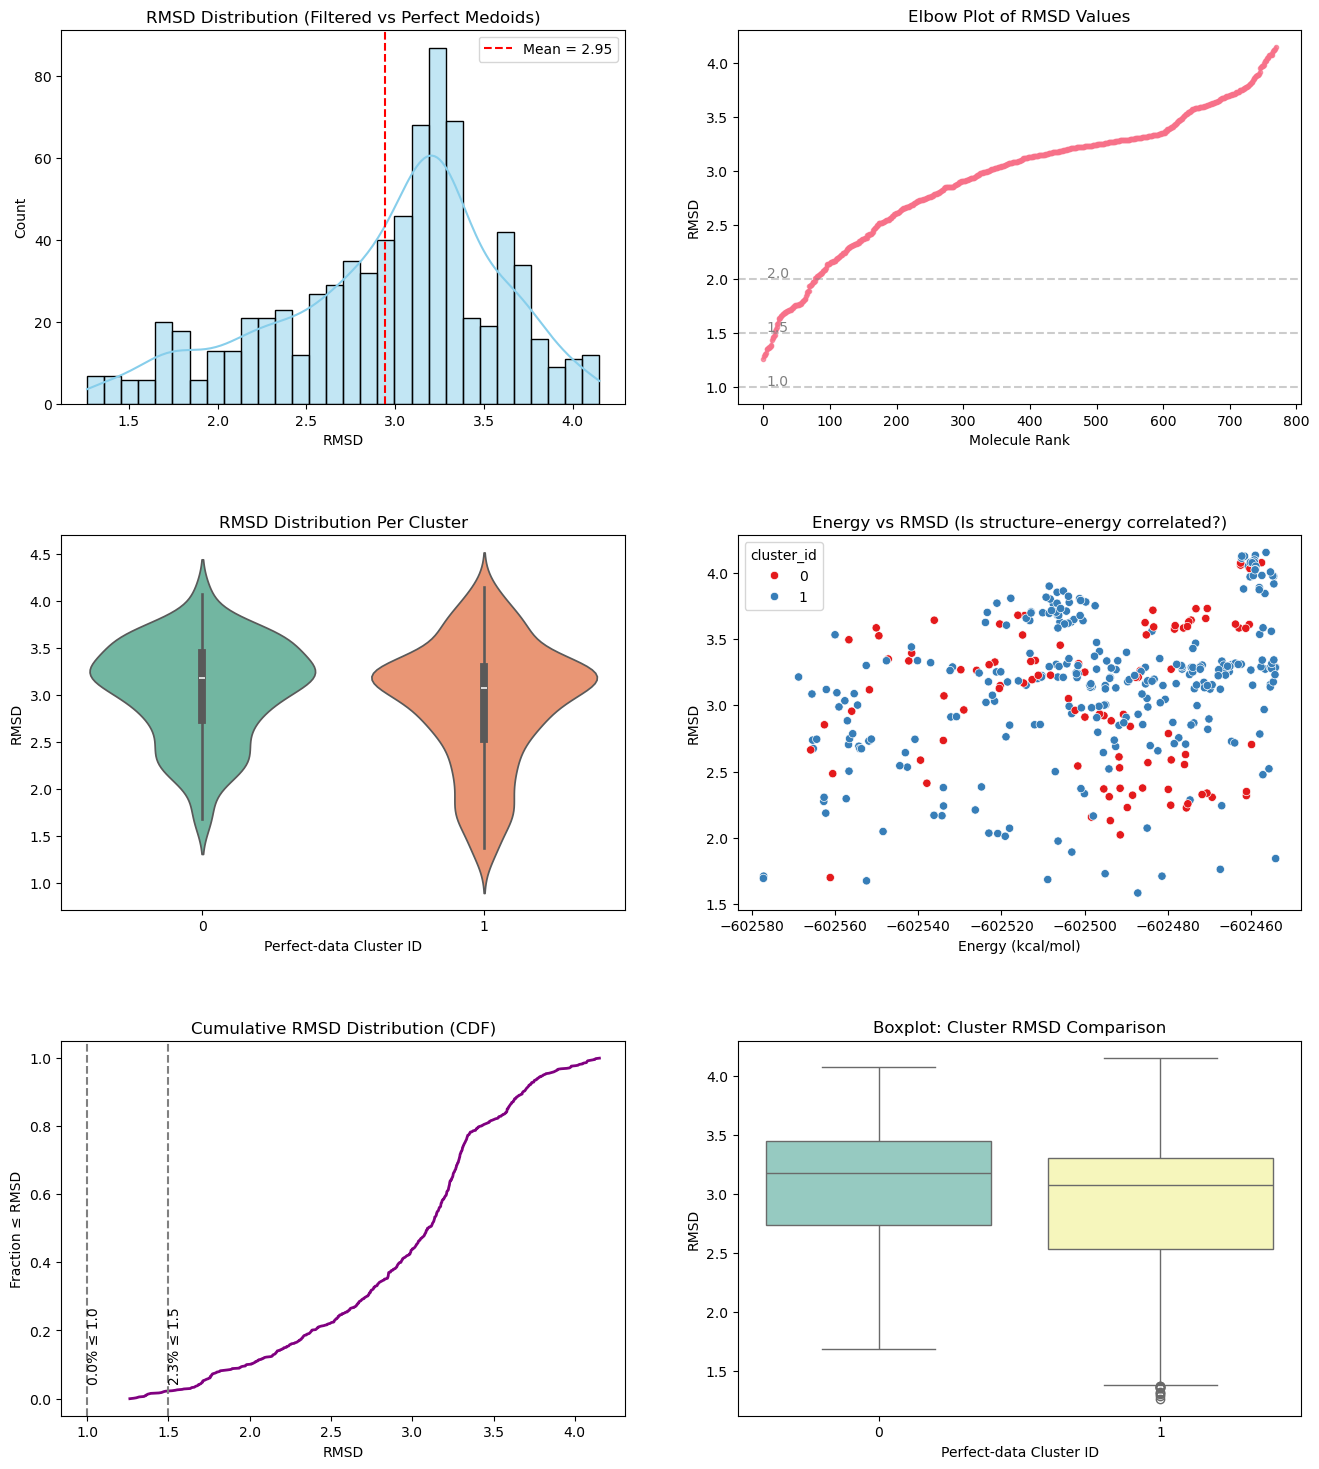

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------
# Load RMSD results and attach cluster IDs
# --------------------------------------------------------
df = pd.read_csv("filtered_vs_centroids.csv")

df = df.rename(columns={
    "mol_id": "filtered_molecule_id",
    "cluster": "cluster_id",
    "rmsd": "best_rmsd_corrected"
})

# Optional: also load energies for scatter plot
df_energy = pd.read_csv("molecular_data_filtered_chemistry.csv")
mol_energy = df_energy.groupby("molecule_id")["energy_kcal_mol"].first()
df["energy"] = df["filtered_molecule_id"].map(mol_energy)

# RMSD column
rmsd = df["best_rmsd_corrected"]

# --------------------------------------------------------
# Set up the 6-plot figure
# --------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
plt.subplots_adjust(hspace=0.35)

# --------------------------------------------------------
# 1. RMSD Histogram
# --------------------------------------------------------
ax = axes[0,0]
sns.histplot(rmsd, bins=30, kde=True, ax=ax, color="skyblue")
ax.set_title("RMSD Distribution (Filtered vs Perfect Medoids)")
ax.set_xlabel("RMSD")
ax.set_ylabel("Count")
ax.axvline(rmsd.mean(), color="red", linestyle="--", label=f"Mean = {rmsd.mean():.2f}")
ax.legend()

# --------------------------------------------------------
# 2. Elbow Plot (Sorted RMSD)
# --------------------------------------------------------
ax = axes[0,1]
sorted_rmsd = np.sort(rmsd.values)
ax.plot(sorted_rmsd, marker=".", alpha=0.7)
ax.set_title("Elbow Plot of RMSD Values")
ax.set_xlabel("Molecule Rank")
ax.set_ylabel("RMSD")

# Mark recommended cutoffs
for c in [1.0, 1.5, 2.0]:
    ax.axhline(c, color="gray", linestyle="--", alpha=0.4)
    ax.text(5, c+0.02, f"{c}", color="gray")

# --------------------------------------------------------
# 3. Violin Plot per Cluster
# --------------------------------------------------------
ax = axes[1,0]
sns.violinplot(data=df, x="cluster_id", y="best_rmsd_corrected", palette="Set2", ax=ax)
ax.set_title("RMSD Distribution Per Cluster")
ax.set_xlabel("Perfect-data Cluster ID")
ax.set_ylabel("RMSD")

# --------------------------------------------------------
# 4. Scatter: Energy vs RMSD
# --------------------------------------------------------
ax = axes[1,1]
sns.scatterplot(data=df, x="energy", y="best_rmsd_corrected",
                hue="cluster_id", palette="Set1", ax=ax)
ax.set_title("Energy vs RMSD (Is structure–energy correlated?)")
ax.set_xlabel("Energy (kcal/mol)")
ax.set_ylabel("RMSD")

# --------------------------------------------------------
# 5. Cumulative RMSD Distribution
# --------------------------------------------------------
ax = axes[2,0]
sorted_vals = sorted_rmsd
cdf = np.arange(len(sorted_vals)) / len(sorted_vals)
ax.plot(sorted_vals, cdf, color="purple", linewidth=2)
ax.set_title("Cumulative RMSD Distribution (CDF)")
ax.set_xlabel("RMSD")
ax.set_ylabel("Fraction ≤ RMSD")

# Common thresholds
for t in [1.0, 1.5]:
    frac = np.mean(sorted_vals <= t)
    ax.axvline(t, linestyle="--", color="gray")
    ax.text(t, 0.05, f"{frac*100:.1f}% ≤ {t}", rotation=90)

# --------------------------------------------------------
# 6. Boxplot comparison of clusters
# --------------------------------------------------------
ax = axes[2,1]
sns.boxplot(data=df, x="cluster_id", y="best_rmsd_corrected", palette="Set3", ax=ax)
ax.set_title("Boxplot: Cluster RMSD Comparison")
ax.set_xlabel("Perfect-data Cluster ID")
ax.set_ylabel("RMSD")

plt.show()



In [14]:
"""
3D Molecular Viewer for Individual Molecules
============================================
This cell allows you to select and visualize specific molecules in 3D using py3Dmol.
"""

import pandas as pd
import numpy as np
import py3Dmol
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def visualize_molecule_3d(csv_file, molecule_id, 
                         charge_type='cm5', style='sphere', 
                         show_charges=True, color_by_charge=True,
                         width=800, height=600):
    """
    Visualize a specific molecule in 3D with charge information.
    """

    print(f"🔍 3D VISUALIZATION: {molecule_id}")
    print("=" * 40)

    # Read the CSV file
    try:
        df = pd.read_csv(csv_file)
        print(f"Loaded dataset with {len(df):,} rows")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

    # Filter data for the specific molecule
    mol_data = df[df['molecule_id'] == molecule_id].copy()
    if mol_data.empty:
        print(f"❌ Molecule '{molecule_id}' not found in dataset")
        print(f"Available molecules: {sorted(df['molecule_id'].unique())[:10]}...")
        return None

    print(f"✅ Found molecule with {len(mol_data)} atoms")

    # Create XYZ format string for py3Dmol
    xyz_lines = [str(len(mol_data))]  # Number of atoms
    xyz_lines.append(f"{molecule_id} - Energy visualization")  # Comment line

    # Map atomic numbers to element symbols
    z_to_element = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F',
                   15: 'P', 16: 'S', 17: 'Cl', 35: 'Br', 53: 'I'}

    charges = []
    elements = []

    for _, atom in mol_data.iterrows():
        element = z_to_element.get(atom['Z'], f"Z{atom['Z']}")
        elements.append(element)

        charge_value = atom['charge']
        charges.append(charge_value)
        xyz_lines.append(f"{element} {atom['x']:.6f} {atom['y']:.6f} {atom['z']:.6f}")

    xyz_string = '\n'.join(xyz_lines)

    # Print charge statistics
    charges = np.array(charges)
    print(f"💡 Charge Statistics (CM5):")
    print(f"   Range: {charges.min():.3f} to {charges.max():.3f}")
    print(f"   Mean: {charges.mean():.3f}")
    print(f"   Total: {charges.sum():.3f}")
    print()

    # Create py3Dmol viewer
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(xyz_string, 'xyz')

    # Set visualization style
    if color_by_charge:
        for i, (charge, element) in enumerate(zip(charges, elements)):
            normalized_charge = np.clip(charge, -1.0, 1.0)
            if normalized_charge > 0:
                color = f"rgb({255}, {int(255*(1-normalized_charge))}, {int(255*(1-normalized_charge))})"
            elif normalized_charge < 0:
                color = f"rgb({int(255*(1+normalized_charge))}, {int(255*(1+normalized_charge))}, {255})"
            else:
                color = "white"

            if style == 'sphere':
                viewer.setStyle({'serial': i}, {'sphere': {'color': color, 'radius': 0.4}})
            elif style == 'stick':
                viewer.setStyle({'serial': i}, {'stick': {'color': color, 'radius': 0.3}})
            elif style == 'line':
                viewer.setStyle({'serial': i}, {'line': {'color': color}})
            else:
                viewer.setStyle({'serial': i}, {style: {'color': color}})
    else:
        if style == 'sphere':
            viewer.setStyle({}, {'sphere': {'radius': 0.4}})
        elif style == 'stick':
            viewer.setStyle({}, {'stick': {'radius': 0.3}})
        elif style == 'line':
            viewer.setStyle({}, {'line': {}})
        else:
            viewer.setStyle({}, {style: {}})

    if show_charges:
        for i, (x, y, z, charge, element) in enumerate(zip(
            mol_data['x'], mol_data['y'], mol_data['z'], charges, elements
        )):
            label_text = f"{element}{i+1}\\n{charge:.3f}"
            viewer.addLabel(label_text, {
                'position': {'x': x, 'y': y, 'z': z},
                'backgroundColor': 'white',
                'backgroundOpacity': 0.8,
                'fontColor': 'black',
                'fontSize': 10
            })

    viewer.addStyle({}, {'stick': {'radius': 0.1, 'color': 'grey'}})
    viewer.zoomTo()
    viewer.show()

    # Plot charge distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    atom_labels = [f"{elem}{i+1}" for i, elem in enumerate(elements)]
    colors = ['red' if c > 0 else 'blue' if c < 0 else 'gray' for c in charges]
    ax1.bar(range(len(charges)), charges, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Atom Index')
    ax1.set_ylabel('CM5 Charge (e)')
    ax1.set_title(f'Atomic Charges: {molecule_id}')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    if len(atom_labels) <= 20:
        ax1.set_xticks(range(len(charges)))
        ax1.set_xticklabels(atom_labels, rotation=45)

    ax2.hist(charges, bins=min(10, len(charges)//2 + 1),
             alpha=0.7, edgecolor='black', color='skyblue')
    ax2.axvline(charges.mean(), color='red', linestyle='--', label=f'Mean: {charges.mean():.3f}')
    ax2.set_xlabel('Charge (e)')
    ax2.set_ylabel('Number of Atoms')
    ax2.set_title('Charge Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("🔬 DETAILED ATOM INFORMATION")
    print("-" * 50)
    print(f"{'Atom':>6} {'Element':>8} {'X':>8} {'Y':>8} {'Z':>8} {'Charge':>8}")
    print("-" * 50)
    for i, (_, atom) in enumerate(mol_data.iterrows()):
        element = elements[i]
        print(f"{i+1:>6} {element:>8} {atom['x']:>8.3f} {atom['y']:>8.3f} {atom['z']:>8.3f} {charges[i]:>8.3f}")

    return viewer


# ================= Molecule Selection and Visualization =================

csv_file = 'molecular_data_cleaned.csv'

# Load dataset and get available molecule IDs
df = pd.read_csv(csv_file)
available = df['molecule_id'].unique()
print(f"✅ {len(available)} molecules found in {csv_file}")
print("Sample IDs:", list(available[:15]))  # show first 15 to help you pick

# -------- Molecule selection --------
# You can either manually type a molecule ID here:
molecule_to_view = 'molecule077'   # e.g. 'molecule0274'

# Or if you leave it as None, it will pick one randomly
if molecule_to_view is None:
    molecule_to_view = np.random.choice(available)
    print(f"\n🎯 Randomly selected molecule: {molecule_to_view}")
else:
    print(f"\n🎯 Manually selected molecule: {molecule_to_view}")

# -------- Visualization --------
viewer = visualize_molecule_3d(
    csv_file=csv_file,
    molecule_id=molecule_to_view,
    charge_type='cm5',
    style='sphere',   # or 'stick', 'line'
    show_charges=False,
    color_by_charge=False,
    width=800,
    height=600
)


import itertools

# Covalent radii (Å)
radii = {
    1: 0.31, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57,
    15: 1.07, 16: 1.05, 17: 0.99, 35: 1.20, 53: 1.39
}

# Function to check for atom clashes within a molecule
def detect_clashes(mol_df, s_threshold=0.6):
    coords = mol_df[['x','y','z']].values
    Z = mol_df['Z'].values
    bad_pairs = []
    for i, j in itertools.combinations(range(len(Z)), 2):
        d = np.linalg.norm(coords[i] - coords[j])
        r_sum = radii.get(Z[i],1.0) + radii.get(Z[j],1.0)
        s = d / r_sum if r_sum > 0 else np.inf
        if s < s_threshold:  # atoms unrealistically close
            bad_pairs.append((i,j,d,s,Z[i],Z[j]))
    return bad_pairs

# Scan dataset
df = pd.read_csv('molecular_data_cleaned.csv')
bad_molecules = []

for mol_id, mol_df in df.groupby('molecule_id'):
    clashes = detect_clashes(mol_df, s_threshold=0.6)
    if len(clashes) > 0:
        bad_molecules.append((mol_id, len(clashes)))

print(f"⚠️ Molecules with severe atomic clashes (<0.6× sum radii): {len(bad_molecules)} / {df['molecule_id'].nunique()}")
print("Examples:")
for mol_id, count in bad_molecules[:10]:
    print(f" - {mol_id}: {count} clash pairs")

# Optionally save list to CSV for inspection
# pd.DataFrame(bad_molecules, columns=['molecule_id','num_clashes']).to_csv('bad_molecules_clashes.csv', index=False)



✅ 168 molecules found in molecular_data_cleaned.csv
Sample IDs: ['molecule037', 'molecule039', 'molecule042', 'molecule051', 'molecule059', 'molecule060', 'molecule118', 'molecule145', 'molecule229', 'molecule269', 'molecule329', 'molecule350', 'molecule393', 'molecule406', 'molecule847']

🎯 Manually selected molecule: molecule077
🔍 3D VISUALIZATION: molecule077
Loaded dataset with 1,008 rows
❌ Molecule 'molecule077' not found in dataset
Available molecules: ['molecule037', 'molecule039', 'molecule042', 'molecule051', 'molecule059', 'molecule060', 'molecule1011', 'molecule1012', 'molecule1013', 'molecule1107']...
⚠️ Molecules with severe atomic clashes (<0.6× sum radii): 0 / 168
Examples:


In [15]:
# Step 4: Getting Data Smote Ready

import pandas as pd
import numpy as np

def coulomb_matrix(coords, Z):
    n = len(Z)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i, i] = 0.5 * Z[i] ** 2.4
            else:
                dist = np.linalg.norm(coords[i] - coords[j])
                M[i, j] = (Z[i] * Z[j]) / dist
    return M

def build_embeddings(df, k_eigs=20):
    rows = []
    
    for mol_id, mol in df.groupby("molecule_id"):
        coords = mol[['x','y','z']].values
        Z = mol['Z'].values
        
        M = coulomb_matrix(coords, Z)
        eigvals = np.linalg.eigvalsh(M)
        eigvals = np.sort(eigvals)[::-1]  # descending
        
        # pad to fixed size
        if len(eigvals) < k_eigs:
            eigvals = np.pad(eigvals, (0, k_eigs - len(eigvals)))
        eigvals = eigvals[:k_eigs]
        
        rows.append([mol_id] + eigvals.tolist())
    
    cols = ["molecule_id"] + [f"eig_{i+1}" for i in range(k_eigs)]
    return pd.DataFrame(rows, columns=cols)

# Load cleaned dataset
df = pd.read_csv("molecular_data_cleaned.csv")

# Build embeddings
embed_df = build_embeddings(df)

# Save
embed_df.to_csv("molecular_embeddings_SMOTE.csv", index=False)

print("✔ SMOTE-ready 20-dim embeddings created → molecular_embeddings_SMOTE.csv")
print(embed_df.head())


✔ SMOTE-ready 20-dim embeddings created → molecular_embeddings_SMOTE.csv
   molecule_id       eig_1       eig_2      eig_3     eig_4     eig_5  \
0  molecule037  527.765077  380.678183  28.558585 -0.039880 -0.086570   
1  molecule039  527.829357  380.637763  28.533157 -0.039202 -0.090278   
2  molecule042  528.066448  380.480904  28.470823 -0.053736 -0.082145   
3  molecule051  527.882822  380.605966  28.555713 -0.056353 -0.086041   
4  molecule059  527.667511  380.746053  28.554996 -0.037954 -0.082188   

      eig_6  eig_7  eig_8  eig_9  ...  eig_11  eig_12  eig_13  eig_14  eig_15  \
0 -0.928518    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
1 -0.923919    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
2 -0.935417    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
3 -0.955230    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
4 -0.901541    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   

 

## 3D Molecular Viewer for Individual Molecules For Balanced Data
============================================

* This cell allows you to select and visualize specific molecules in 3D using py3Dmol.
It reads the original CSV data and reconstructs the 3D structure for visualization.

Dependencies: py3Dmol, pandas, numpy

In [13]:
"""
3D Molecular Viewer for Individual Molecules
============================================
This cell allows you to select and visualize specific molecules in 3D using py3Dmol.
"""

import pandas as pd
import numpy as np
import py3Dmol
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def visualize_molecule_3d(csv_file, molecule_id, 
                         charge_type='cm5', style='sphere', 
                         show_charges=True, color_by_charge=True,
                         width=800, height=600):
    """
    Visualize a specific molecule in 3D with charge information.
    """

    print(f"🔍 3D VISUALIZATION: {molecule_id}")
    print("=" * 40)

    # Read the CSV file
    try:
        df = pd.read_csv(csv_file)
        print(f"Loaded dataset with {len(df):,} rows")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

    # Filter data for the specific molecule
    mol_data = df[df['molecule_id'] == molecule_id].copy()
    if mol_data.empty:
        print(f"❌ Molecule '{molecule_id}' not found in dataset")
        print(f"Available molecules: {sorted(df['molecule_id'].unique())[:10]}...")
        return None

    print(f"✅ Found molecule with {len(mol_data)} atoms")

    # Create XYZ format string for py3Dmol
    xyz_lines = [str(len(mol_data))]  # Number of atoms
    xyz_lines.append(f"{molecule_id} - Energy visualization")  # Comment line

    # Map atomic numbers to element symbols
    z_to_element = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F',
                   15: 'P', 16: 'S', 17: 'Cl', 35: 'Br', 53: 'I'}

    charges = []
    elements = []

    for _, atom in mol_data.iterrows():
        element = z_to_element.get(atom['Z'], f"Z{atom['Z']}")
        elements.append(element)

        charge_value = atom['charge']
        charges.append(charge_value)
        xyz_lines.append(f"{element} {atom['x']:.6f} {atom['y']:.6f} {atom['z']:.6f}")

    xyz_string = '\n'.join(xyz_lines)

    # Print charge statistics
    charges = np.array(charges)
    print(f"💡 Charge Statistics (CM5):")
    print(f"   Range: {charges.min():.3f} to {charges.max():.3f}")
    print(f"   Mean: {charges.mean():.3f}")
    print(f"   Total: {charges.sum():.3f}")
    print()

    # Create py3Dmol viewer
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(xyz_string, 'xyz')

    # Set visualization style
    if color_by_charge:
        for i, (charge, element) in enumerate(zip(charges, elements)):
            normalized_charge = np.clip(charge, -1.0, 1.0)
            if normalized_charge > 0:
                color = f"rgb({255}, {int(255*(1-normalized_charge))}, {int(255*(1-normalized_charge))})"
            elif normalized_charge < 0:
                color = f"rgb({int(255*(1+normalized_charge))}, {int(255*(1+normalized_charge))}, {255})"
            else:
                color = "white"

            if style == 'sphere':
                viewer.setStyle({'serial': i}, {'sphere': {'color': color, 'radius': 0.4}})
            elif style == 'stick':
                viewer.setStyle({'serial': i}, {'stick': {'color': color, 'radius': 0.3}})
            elif style == 'line':
                viewer.setStyle({'serial': i}, {'line': {'color': color}})
            else:
                viewer.setStyle({'serial': i}, {style: {'color': color}})
    else:
        if style == 'sphere':
            viewer.setStyle({}, {'sphere': {'radius': 0.4}})
        elif style == 'stick':
            viewer.setStyle({}, {'stick': {'radius': 0.3}})
        elif style == 'line':
            viewer.setStyle({}, {'line': {}})
        else:
            viewer.setStyle({}, {style: {}})

    if show_charges:
        for i, (x, y, z, charge, element) in enumerate(zip(
            mol_data['x'], mol_data['y'], mol_data['z'], charges, elements
        )):
            label_text = f"{element}{i+1}\\n{charge:.3f}"
            viewer.addLabel(label_text, {
                'position': {'x': x, 'y': y, 'z': z},
                'backgroundColor': 'white',
                'backgroundOpacity': 0.8,
                'fontColor': 'black',
                'fontSize': 10
            })

    viewer.addStyle({}, {'stick': {'radius': 0.1, 'color': 'grey'}})
    viewer.zoomTo()
    viewer.show()

    # Plot charge distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    atom_labels = [f"{elem}{i+1}" for i, elem in enumerate(elements)]
    colors = ['red' if c > 0 else 'blue' if c < 0 else 'gray' for c in charges]
    ax1.bar(range(len(charges)), charges, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Atom Index')
    ax1.set_ylabel('CM5 Charge (e)')
    ax1.set_title(f'Atomic Charges: {molecule_id}')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    if len(atom_labels) <= 20:
        ax1.set_xticks(range(len(charges)))
        ax1.set_xticklabels(atom_labels, rotation=45)

    ax2.hist(charges, bins=min(10, len(charges)//2 + 1),
             alpha=0.7, edgecolor='black', color='skyblue')
    ax2.axvline(charges.mean(), color='red', linestyle='--', label=f'Mean: {charges.mean():.3f}')
    ax2.set_xlabel('Charge (e)')
    ax2.set_ylabel('Number of Atoms')
    ax2.set_title('Charge Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("🔬 DETAILED ATOM INFORMATION")
    print("-" * 50)
    print(f"{'Atom':>6} {'Element':>8} {'X':>8} {'Y':>8} {'Z':>8} {'Charge':>8}")
    print("-" * 50)
    for i, (_, atom) in enumerate(mol_data.iterrows()):
        element = elements[i]
        print(f"{i+1:>6} {element:>8} {atom['x']:>8.3f} {atom['y']:>8.3f} {atom['z']:>8.3f} {charges[i]:>8.3f}")

    return viewer


# ================= Molecule Selection and Visualization =================

csv_file = 'molecular_data_filtered_chemistry.csv'

# Load dataset and get available molecule IDs
df = pd.read_csv(csv_file)
available = df['molecule_id'].unique()
print(f"✅ {len(available)} molecules found in {csv_file}")
print("Sample IDs:", list(available[:15]))  # show first 15 to help you pick

# -------- Molecule selection --------
# You can either manually type a molecule ID here:
molecule_to_view = 'molecule016'   # e.g. 'molecule0274'

# Or if you leave it as None, it will pick one randomly
if molecule_to_view is None:
    molecule_to_view = np.random.choice(available)
    print(f"\n🎯 Randomly selected molecule: {molecule_to_view}")
else:
    print(f"\n🎯 Manually selected molecule: {molecule_to_view}")

# -------- Visualization --------
viewer = visualize_molecule_3d(
    csv_file=csv_file,
    molecule_id=molecule_to_view,
    charge_type='cm5',
    style='sphere',   # or 'stick', 'line'
    show_charges=False,
    color_by_charge=False,
    width=800,
    height=600
)


import itertools

# Covalent radii (Å)
radii = {
    1: 0.31, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57,
    15: 1.07, 16: 1.05, 17: 0.99, 35: 1.20, 53: 1.39
}

# Function to check for atom clashes within a molecule
def detect_clashes(mol_df, s_threshold=0.6):
    coords = mol_df[['x','y','z']].values
    Z = mol_df['Z'].values
    bad_pairs = []
    for i, j in itertools.combinations(range(len(Z)), 2):
        d = np.linalg.norm(coords[i] - coords[j])
        r_sum = radii.get(Z[i],1.0) + radii.get(Z[j],1.0)
        s = d / r_sum if r_sum > 0 else np.inf
        if s < s_threshold:  # atoms unrealistically close
            bad_pairs.append((i,j,d,s,Z[i],Z[j]))
    return bad_pairs

# Scan dataset
df = pd.read_csv('molecular_data_filtered_chemistry.csv')
bad_molecules = []

for mol_id, mol_df in df.groupby('molecule_id'):
    clashes = detect_clashes(mol_df, s_threshold=0.6)
    if len(clashes) > 0:
        bad_molecules.append((mol_id, len(clashes)))

print(f"⚠️ Molecules with severe atomic clashes (<0.6× sum radii): {len(bad_molecules)} / {df['molecule_id'].nunique()}")
print("Examples:")
for mol_id, count in bad_molecules[:10]:
    print(f" - {mol_id}: {count} clash pairs")

# Optionally save list to CSV for inspection
pd.DataFrame(bad_molecules, columns=['molecule_id','num_clashes']).to_csv('bad_molecules_clashes.csv', index=False)



✅ 770 molecules found in molecular_data_filtered_chemistry.csv
Sample IDs: ['molecule023', 'molecule055', 'molecule060', 'molecule086', 'molecule136', 'molecule141', 'molecule144', 'molecule146', 'molecule195', 'molecule236', 'molecule249', 'molecule253', 'molecule254', 'molecule255', 'molecule282']

🎯 Manually selected molecule: molecule016
🔍 3D VISUALIZATION: molecule016
Loaded dataset with 4,620 rows
❌ Molecule 'molecule016' not found in dataset
Available molecules: ['molecule023', 'molecule055', 'molecule060', 'molecule086', 'molecule1011', 'molecule1012', 'molecule10146', 'molecule10147', 'molecule10148', 'molecule1015']...
⚠️ Molecules with severe atomic clashes (<0.6× sum radii): 0 / 770
Examples:


## Geometric SMOTE — Synthetic Molecular Generation for Energy-Bin Balancing
============================================

* Reads your current dataset & sparse-bin summary.
    For each under-populated bin:
        Looks at neighboring bins (±1 by default)
        Samples existing molecules nearby in energy
        Assigns each a small coordinate perturbation (±0.01–0.05 Å)
        Records it as a generation instruction
    Completely empty or isolated bins are skipped, since there’s no chemistry anchor.

✅ Loaded filtered dataset: 1,008 atoms across 168 molecules

📉 Sparse Energy Bins Identified:
   bin  count           mean            min            max  deficit
0    1     22 -602579.397785 -602580.837740 -602577.853213        3
1    2     19 -602576.679871 -602577.706583 -602574.963692        6
2    3     19 -602573.016102 -602574.744411 -602572.113795        6
3    4      5 -602570.781624 -602571.581622 -602569.097812       20
4    5      6 -602567.696201 -602568.742289 -602565.911958       19
5    6      7 -602564.937571 -602565.814010 -602562.906019       18
6    7      9 -602561.451930 -602562.775304 -602560.139030       16
7    8      2 -602557.793614 -602558.207294 -602557.379934       23
8    9      2 -602555.362740 -602556.565133 -602554.160346       23
9   10      3 -602552.957321 -602553.702086 -602552.485122       22

⚙️  Total synthetic molecules needed to balance bins: 807


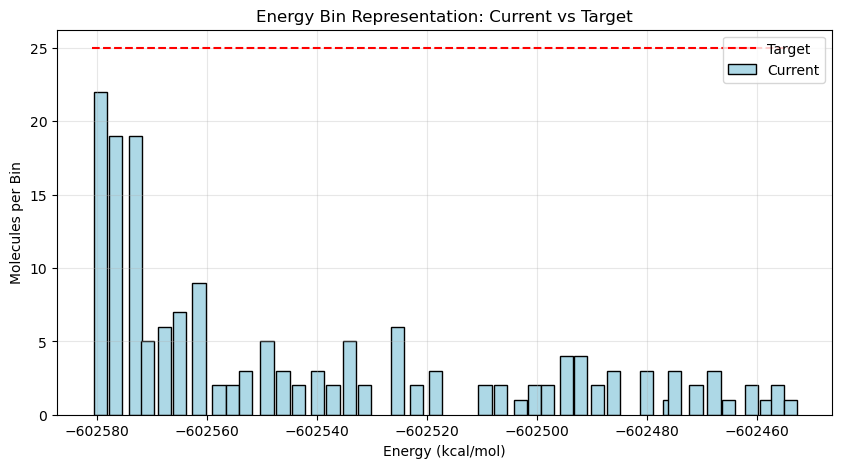

🧾 Saved sparse bin summary → sparse_bins_for_SMOTE.csv

✅ Ready for next step: Geometric SMOTE-based synthetic molecule generation


In [16]:
# 🧩 Step 1: Identify Sparse Energy Bins for Synthetic Molecule Generation
# ============================================================
# This cell analyzes the filtered dataset’s current energy distribution.
# It determines which bins are underrepresented and should receive 
# synthetic molecule generation using Geometric SMOTE.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
INPUT_FILE = "molecular_data_cleaned.csv"
ENERGY_COL = "energy_kcal_mol"
MOLECULE_COL = "molecule_id"
BIN_WIDTH = 3.0            # must match the value used during filtering
TARGET_BIN_SIZE = 25      # desired molecules per bin (target uniform density)

# --- LOAD FILTERED DATA ---
df = pd.read_csv(INPUT_FILE)
print(f"✅ Loaded filtered dataset: {len(df):,} atoms across {df[MOLECULE_COL].nunique():,} molecules")

# --- COMPUTE BIN COUNTS ---
energies_per_mol = df.groupby(MOLECULE_COL)[ENERGY_COL].first()
minE, maxE = np.min(energies_per_mol), np.max(energies_per_mol)
bins = np.arange(minE, maxE + BIN_WIDTH, BIN_WIDTH)
labels = np.digitize(energies_per_mol, bins)

bin_summary = (
    pd.DataFrame({"bin": labels, "energy": energies_per_mol})
    .groupby("bin")["energy"]
    .agg(["count", "mean", "min", "max"])
    .reset_index()
)

# --- IDENTIFY SPARSE BINS ---
bin_summary["deficit"] = TARGET_BIN_SIZE - bin_summary["count"]
sparse_bins = bin_summary[bin_summary["deficit"] > 0].copy()
sparse_bins["deficit"] = sparse_bins["deficit"].astype(int)

print("\n📉 Sparse Energy Bins Identified:")
print(sparse_bins.head(10))

total_needed = sparse_bins["deficit"].sum()
print(f"\n⚙️  Total synthetic molecules needed to balance bins: {total_needed:,}")

# --- VISUALIZE CURRENT VS TARGET DISTRIBUTION ---
plt.figure(figsize=(10,5))
plt.bar(bin_summary["mean"], bin_summary["count"], width=BIN_WIDTH*0.8,
        color="lightblue", edgecolor="black", label="Current")
plt.hlines(TARGET_BIN_SIZE, minE, maxE, color="red", linestyle="--", label="Target")
plt.xlabel("Energy (kcal/mol)")
plt.ylabel("Molecules per Bin")
plt.title("Energy Bin Representation: Current vs Target")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- OUTPUT PREPARED BIN LIST FOR SYNTHETIC GENERATION ---
sparse_bins.to_csv("sparse_bins_for_SMOTE.csv", index=False)
print(f"🧾 Saved sparse bin summary → sparse_bins_for_SMOTE.csv")

print("\n✅ Ready for next step: Geometric SMOTE-based synthetic molecule generation")

In [17]:
# 🧪 Step 2: Prepare Synthetic Molecule Generation via Geometric SMOTE
# ====================================================================
# This cell builds the generation plan:
# - Reads sparse bins from Step 7
# - Identifies valid neighbors for interpolation
# - Creates a "synthesis plan" of molecules and target energies
# - Ignores completely empty or isolated bins (unphysical zones)

import pandas as pd
import numpy as np
from itertools import combinations
import random

# --- CONFIGURATION ---
SPARSE_FILE = "sparse_bins_for_SMOTE.csv"
DATA_FILE   = "molecular_data_cleaned.csv"
ENERGY_COL  = "energy_kcal_mol"
MOLECULE_COL = "molecule_id"
BIN_WIDTH   = 3.0
NEIGHBOR_TOL = 1  # how many adjacent bins on each side can be used for interpolation
SAMPLES_PER_BIN = 10  # synthetic molecules per underfilled bin

# --- LOAD INPUTS ---
sparse_bins = pd.read_csv(SPARSE_FILE)
df = pd.read_csv(DATA_FILE)

energies_per_mol = df.groupby(MOLECULE_COL)[ENERGY_COL].first()
minE, maxE = np.min(energies_per_mol), np.max(energies_per_mol)
bins = np.arange(minE, maxE + BIN_WIDTH, BIN_WIDTH)
labels = np.digitize(energies_per_mol, bins)

bin_map = pd.DataFrame({
    "molecule_id": energies_per_mol.index,
    "energy": energies_per_mol.values,
    "bin": labels
})

# --- FUNCTION: get molecules near a bin ---
def get_neighbor_molecules(bin_index):
    """Return all molecules within ±NEIGHBOR_TOL bins."""
    valid_bins = [b for b in range(bin_index-NEIGHBOR_TOL, bin_index+NEIGHBOR_TOL+1)
                  if b in bin_map["bin"].unique()]
    return bin_map[bin_map["bin"].isin(valid_bins)]

# --- BUILD SYNTHESIS PLAN ---
synthetic_plan = []

for _, row in sparse_bins.iterrows():
    b = int(row["bin"])
    deficit = int(row["deficit"])
    
    # skip empty regions with no valid neighbors
    neighbors = get_neighbor_molecules(b)
    if len(neighbors) == 0:
        print(f"⚠️ Skipping empty bin {b} (no nearby molecules)")
        continue

    # sample real molecules from neighboring bins
    sampled = neighbors.sample(min(len(neighbors), SAMPLES_PER_BIN))
    for _, mol in sampled.iterrows():
        # small perturbation target energy ~ middle of sparse bin
        target_E = (row["min"] + row["max"]) / 2
        synthetic_plan.append({
            "template_molecule": mol["molecule_id"],
            "source_bin": mol["bin"],
            "target_bin": b,
            "target_energy": target_E,
            "perturbation": np.random.uniform(0.01, 0.05),  # small coordinate shift (Å)
        })

plan_df = pd.DataFrame(synthetic_plan)
print(f"✅ Prepared {len(plan_df):,} synthetic molecules for geometric SMOTE generation")

# --- SAVE SYNTHESIS PLAN ---
plan_df.to_csv("synthetic_generation_plan.csv", index=False)
print("🧾 Saved → synthetic_generation_plan.csv")

# --- OPTIONAL: Inspect a few planned entries ---
print("\nExample of planned SMOTE syntheses:")
display(plan_df.head(10))


✅ Prepared 295 synthetic molecules for geometric SMOTE generation
🧾 Saved → synthetic_generation_plan.csv

Example of planned SMOTE syntheses:


,template_molecule,source_bin,target_bin,target_energy,perturbation
0,molecule1724,1,1,-602579.345476,0.029886
1,molecule1738,1,1,-602579.345476,0.042374
2,molecule1736,1,1,-602579.345476,0.028822
3,molecule2076,2,1,-602579.345476,0.047959
4,molecule1317,1,1,-602579.345476,0.043900
5,molecule406,2,1,-602579.345476,0.023322
6,molecule1488,1,1,-602579.345476,0.025998
7,molecule1327,1,1,-602579.345476,0.026933
8,molecule1850,1,1,-602579.345476,0.035047
9,molecule1274,1,1,-602579.345476,0.021472


In [18]:
"""
Step 3 — Bin-Targeted SMOTE Balancing
=====================================
Fills each sparse energy bin to the desired uniform target count.
This version preserves original SMOTE logic and coordinate reuse.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import cdist

# ============================================================
# CONFIGURATION
# ============================================================
DATA_FILE = "molecular_data_cleaned.csv"
QUALITY_FILE = "molecular_quality_scores.csv"
SPARSE_FILE = "sparse_bins_for_SMOTE.csv"
OUTPUT_FILE = "molecular_embeddings_SMOTE.csv"

ENERGY_COL = "energy_kcal_mol"
MOLECULE_COL = "molecule_id"
BIN_WIDTH = 3.0
TARGET_BIN_SIZE = 25
NEIGHBOR_TOL = 1
MAX_K = 5  # SMOTE neighbor limit
QUALITY_WEIGHT = 0.7  # blend energy & quality for diversity weighting

# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(DATA_FILE)
try:
    q = pd.read_csv(QUALITY_FILE)
    df = df.merge(q, on="molecule_id", how="left")
    print(f"✅ Quality scores merged ({q['chem_quality'].mean():.2f} avg quality)")
except Exception as e:
    print(f"⚠️ Quality file missing ({e}); continuing without quality weighting.")
    df["chem_quality"] = 1.0

sparse_bins = pd.read_csv(SPARSE_FILE)

# ============================================================
# BUILD FEATURES
# ============================================================
energies = df.groupby(MOLECULE_COL)[ENERGY_COL].first()
bins = np.arange(energies.min(), energies.max() + BIN_WIDTH, BIN_WIDTH)
labels = np.digitize(energies, bins)

mol_features = (
    df.groupby(MOLECULE_COL)
      .agg(
          energy_mean=(ENERGY_COL, "mean"),
          num_atoms=("Z", "count"),
          mean_Z=("Z", "mean"),
          std_Z=("Z", "std"),
          mean_charge=("charge", "mean"),
          total_charge=("charge", "sum"),
          chem_quality=("chem_quality", "mean"),
      )
      .assign(bin=labels)
      .reset_index()
)

scaler = StandardScaler()
synthetic_records = []

# ============================================================
# MAIN LOOP — SMOTE PER BIN
# ============================================================
for _, row in sparse_bins.iterrows():
    b = int(row["bin"])
    deficit = int(row["deficit"])
    if deficit <= 0:
        continue

    print(f"\n⚙️  Filling bin {b} → need {deficit} new molecules")

    valid_bins = [x for x in range(b - NEIGHBOR_TOL, b + NEIGHBOR_TOL + 1)
                  if x in mol_features["bin"].unique()]
    subset = mol_features[mol_features["bin"].isin(valid_bins)].copy()

    if len(subset) < 3:
        print(f"⚠️  Bin {b} skipped (too few real molecules)")
        continue

    # --- Weighted resampling by quality (bias to high quality but keep variety)
    weights = (subset["chem_quality"] ** QUALITY_WEIGHT)
    subset = subset.sample(frac=1.0, weights=weights, replace=True, random_state=42)

    # --- Prepare SMOTE data
    X = subset[["energy_mean","num_atoms","mean_Z","std_Z","mean_charge","total_charge"]].values
    y = subset["bin"].values
    X_scaled = scaler.fit_transform(X)
    k = min(MAX_K, len(subset) - 1)

    # --- Run SMOTE safely (same logic as your original)
    try:
        sm = SMOTE(k_neighbors=k, sampling_strategy={b: deficit + (y == b).sum()})
        X_res, y_res = sm.fit_resample(X_scaled, y)
    except ValueError:
        print(f"⚠️  Skipping bin {b} — not enough samples for SMOTE.")
        continue

    # --- Synthetic-only vectors
    mask_new = np.arange(len(y_res)) >= len(y)
    X_new_scaled = X_res[mask_new]
    X_new = scaler.inverse_transform(X_new_scaled)

    # --- Map back to real geometry (coordinate reuse)
    dists = cdist(X_new_scaled, X_scaled)
    nearest_idx = np.argmin(dists, axis=1)

    for i, vec in enumerate(X_new):
        base_id = subset.iloc[nearest_idx[i]][MOLECULE_COL]
        new_id = f"SMOTE_bin{b}_{i:04d}"
        synthetic_records.append((base_id, new_id, b, *vec))

print(f"\n✅ Generated {len(synthetic_records)} synthetic entries")

# ============================================================
# BUILD SYNTHETIC GEOMETRIES
# ============================================================
synthetic_df = []
for base_id, new_id, b, *vals in synthetic_records:
    base_geom = df[df[MOLECULE_COL] == base_id].copy()
    if base_geom.empty:
        continue
    geom = base_geom.copy()
    geom[MOLECULE_COL] = new_id

    E_center = vals[0]
    E_min = bins[b-1] if b > 0 else bins[0]
    E_max = bins[b] if b < len(bins) else bins[-1]
    geom[ENERGY_COL] = np.clip(E_center + np.random.uniform(-0.05, 0.05),
                               E_min + 1e-3, E_max - 1e-3)

    # tiny physical jitter (~0.01 Å)
    geom[["x","y","z"]] += np.random.normal(0, 0.01, geom[["x","y","z"]].shape)
    synthetic_df.append(geom)

# ============================================================
# MERGE + SAVE FINAL
# ============================================================
if synthetic_df:
    synthetic_df = pd.concat(synthetic_df, ignore_index=True)
    balanced_df = pd.concat([df, synthetic_df], ignore_index=True)

    # --- Bin trimming (same as before)
    energies_final = balanced_df.groupby(MOLECULE_COL)[ENERGY_COL].first()
    bins = np.arange(energies_final.min(), energies_final.max() + BIN_WIDTH, BIN_WIDTH)
    labels = np.digitize(energies_final, bins)
    mol_to_bin = pd.DataFrame({"molecule_id": energies_final.index, "bin": labels})

    trim_keep = []
    for b in mol_to_bin["bin"].unique():
        mols = mol_to_bin[mol_to_bin["bin"] == b]["molecule_id"].tolist()
        if len(mols) > TARGET_BIN_SIZE:
            keep = np.random.choice(mols, TARGET_BIN_SIZE, replace=False)
            trim_keep.extend(keep)
        else:
            trim_keep.extend(mols)

    balanced_df = balanced_df[balanced_df["molecule_id"].isin(trim_keep)].reset_index(drop=True)
        # --- Final uniform bin enforcement ---
    print("\n🔧 Enforcing exact uniform bin sizes...")

    # Compute current counts per bin
    energies_final = balanced_df.groupby(MOLECULE_COL)[ENERGY_COL].first()
    bins = np.arange(energies_final.min(), energies_final.max() + BIN_WIDTH, BIN_WIDTH)
    labels = np.digitize(energies_final, bins)
    mol_to_bin = pd.DataFrame({"molecule_id": energies_final.index, "bin": labels})

    final_records = []
    for b in sorted(mol_to_bin["bin"].unique()):
        mols = mol_to_bin[mol_to_bin["bin"] == b]["molecule_id"].tolist()
        n = len(mols)

        if n < TARGET_BIN_SIZE:
            # Top up missing slots with random duplicates (slightly jittered)
            need = TARGET_BIN_SIZE - n
            extras = np.random.choice(mols, need, replace=True)

            for new_idx, dup_id in enumerate(extras):
                dup_geom = balanced_df[balanced_df[MOLECULE_COL] == dup_id].copy()
                new_id = f"{dup_id}_dup{new_idx:02d}"
                dup_geom[MOLECULE_COL] = new_id
                dup_geom[["x", "y", "z"]] += np.random.normal(0, 0.002, dup_geom[["x","y","z"]].shape)
                final_records.append(dup_geom)

        elif n > TARGET_BIN_SIZE:
            mols = np.random.choice(mols, TARGET_BIN_SIZE, replace=False)

        final_records.append(balanced_df[balanced_df[MOLECULE_COL].isin(mols)])

    balanced_df = pd.concat(final_records, ignore_index=True)
    print(f"✅ All bins now have exactly {TARGET_BIN_SIZE} molecules each.")

    # Save dataset
    balanced_df.to_csv(OUTPUT_FILE, index=False)
    print(f"💾 Saved perfectly balanced dataset → {OUTPUT_FILE}")

    balanced_df.to_csv(OUTPUT_FILE, index=False)
    print(f"💾 Saved balanced dataset → {OUTPUT_FILE}")
else:
    print("⚠️  No synthetic molecules generated — check bin coverage.")


✅ Quality scores merged (0.76 avg quality)

⚙️  Filling bin 1 → need 3 new molecules

⚙️  Filling bin 2 → need 6 new molecules

⚙️  Filling bin 3 → need 6 new molecules

⚙️  Filling bin 4 → need 20 new molecules

⚙️  Filling bin 5 → need 19 new molecules
⚠️  Skipping bin 5 — not enough samples for SMOTE.

⚙️  Filling bin 6 → need 18 new molecules

⚙️  Filling bin 7 → need 16 new molecules

⚙️  Filling bin 8 → need 23 new molecules
⚠️  Skipping bin 8 — not enough samples for SMOTE.

⚙️  Filling bin 9 → need 23 new molecules
⚠️  Skipping bin 9 — not enough samples for SMOTE.

⚙️  Filling bin 10 → need 22 new molecules
⚠️  Skipping bin 10 — not enough samples for SMOTE.

⚙️  Filling bin 11 → need 20 new molecules
⚠️  Skipping bin 11 — not enough samples for SMOTE.

⚙️  Filling bin 12 → need 22 new molecules
⚠️  Skipping bin 12 — not enough samples for SMOTE.

⚙️  Filling bin 13 → need 23 new molecules
⚠️  Skipping bin 13 — not enough samples for SMOTE.

⚙️  Filling bin 14 → need 22 new mo

✅ Loaded balanced dataset with 5,850 atoms
🧬 Synthetic molecules detected: 88

🎯 Example synthetic molecule IDs:
['SMOTE_bin1_0000', 'SMOTE_bin1_0001', 'SMOTE_bin1_0002', 'SMOTE_bin2_0000', 'SMOTE_bin2_0001', 'SMOTE_bin2_0002', 'SMOTE_bin2_0003', 'SMOTE_bin2_0004', 'SMOTE_bin2_0005', 'SMOTE_bin3_0000']

📈 Synthetic molecule energy range: -602580.19 → -602524.52 kcal/mol

🔍 Visualizing SMOTE-generated molecule: SMOTE_bin2_0002
🔍 3D VISUALIZATION: SMOTE_bin2_0002
Loaded dataset with 5,850 rows
✅ Found molecule with 6 atoms
💡 Charge Statistics (CM5):
   Range: -0.772 to 0.094
   Mean: -0.167
   Total: -1.000



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

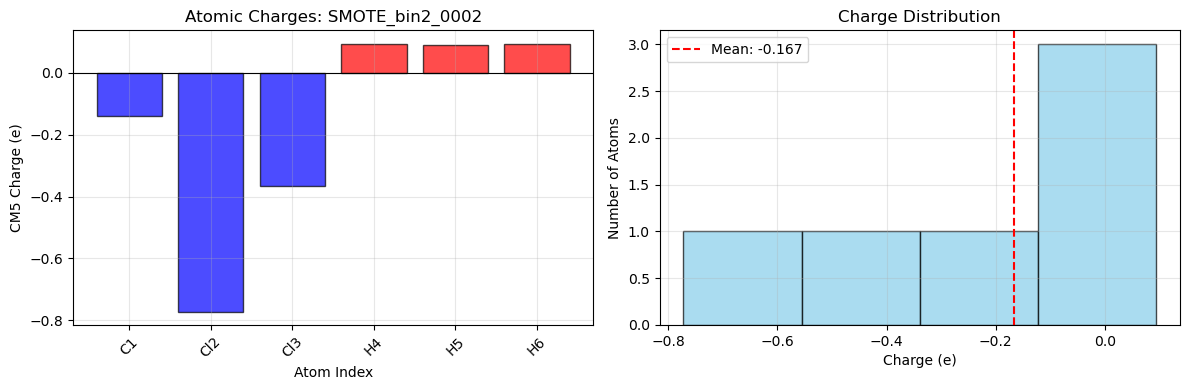

🔬 DETAILED ATOM INFORMATION
--------------------------------------------------
  Atom  Element        X        Y        Z   Charge
--------------------------------------------------
     1        C    0.028    0.042    0.060   -0.141
     2       Cl    1.032   -0.974    2.234   -0.772
     3       Cl   -0.692    0.793   -1.660   -0.365
     4        H    1.108    0.097   -0.009    0.093
     5        H   -0.440    0.818    0.673    0.091
     6        H   -0.407   -0.910    0.087    0.094

🔍 Visualizing SMOTE-generated molecule: SMOTE_bin2_0005
🔍 3D VISUALIZATION: SMOTE_bin2_0005
Loaded dataset with 5,850 rows
✅ Found molecule with 6 atoms
💡 Charge Statistics (CM5):
   Range: -0.799 to 0.088
   Mean: -0.167
   Total: -1.000



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

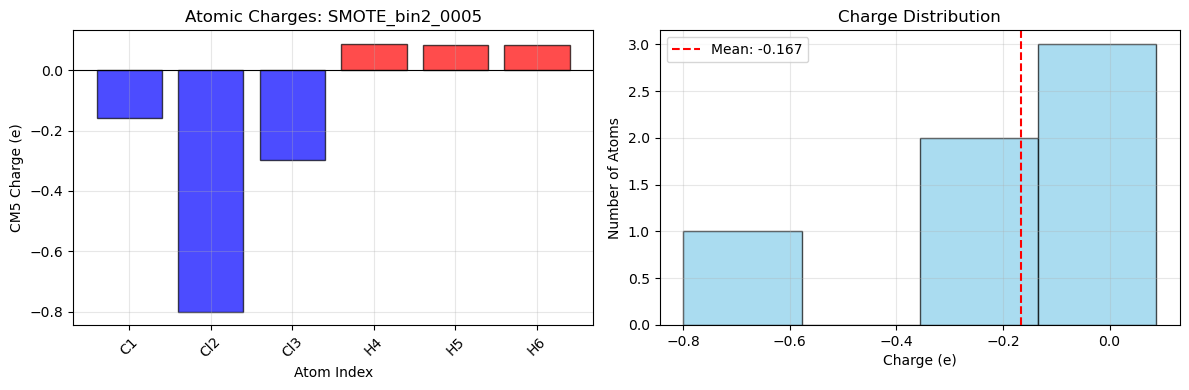

🔬 DETAILED ATOM INFORMATION
--------------------------------------------------
  Atom  Element        X        Y        Z   Charge
--------------------------------------------------
     1        C    0.118    0.258    0.014   -0.158
     2       Cl    1.587   -0.420    2.084   -0.799
     3       Cl   -0.883    0.548   -1.519   -0.297
     4        H   -0.070    1.136    0.684    0.088
     5        H   -0.240   -0.704    0.375    0.083
     6        H    1.147    0.093   -0.266    0.084

🔍 Visualizing SMOTE-generated molecule: SMOTE_bin19_0006
🔍 3D VISUALIZATION: SMOTE_bin19_0006
Loaded dataset with 5,850 rows
✅ Found molecule with 6 atoms
💡 Charge Statistics (CM5):
   Range: -0.981 to 0.127
   Mean: -0.167
   Total: -1.000



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

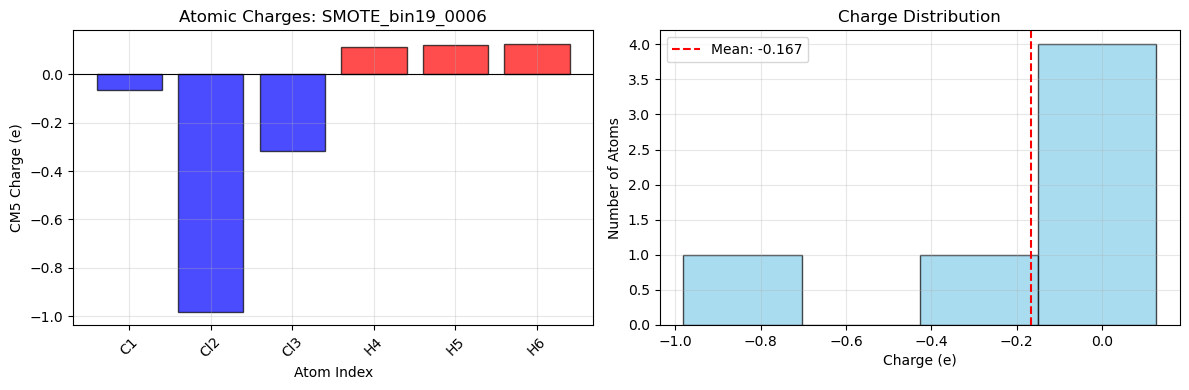

🔬 DETAILED ATOM INFORMATION
--------------------------------------------------
  Atom  Element        X        Y        Z   Charge
--------------------------------------------------
     1        C    0.437    0.445    0.469   -0.063
     2       Cl    0.885    2.318    4.548   -0.981
     3       Cl    0.209   -1.002   -1.132   -0.318
     4        H   -0.696    0.578    0.254    0.112
     5        H    0.700   -0.612    0.764    0.123
     6        H    1.099    1.150    0.042    0.127


In [19]:
# ====================================================================
# 🧩 Step 4 — Visualize SMOTE-Generated Synthetic Molecules
# ====================================================================
# Visualizes several of the newly created SMOTE molecules in 3D
# using the same py3Dmol visualization system you used before.
# ====================================================================

import numpy as np
import pandas as pd

# --- Load the new balanced dataset ---
balanced_df = pd.read_csv("molecular_embeddings_SMOTE.csv")

# Identify which molecules were generated synthetically
synthetic_ids = [m for m in balanced_df["molecule_id"].unique() if m.startswith("SMOTE_")]

print(f"✅ Loaded balanced dataset with {len(balanced_df):,} atoms")
print(f"🧬 Synthetic molecules detected: {len(synthetic_ids)}")

# Display a few examples for manual inspection
if len(synthetic_ids) > 0:
    print("\n🎯 Example synthetic molecule IDs:")
    print(synthetic_ids[:10])
else:
    print("\n⚠️ No SMOTE-generated molecules found — check previous step.")

# Optionally, show the total energy range for synthetic molecules
synthetic_energies = (
    balanced_df[balanced_df["molecule_id"].isin(synthetic_ids)]
    .groupby("molecule_id")["energy_kcal_mol"]
    .first()
)
print(f"\n📈 Synthetic molecule energy range: {synthetic_energies.min():.2f} → {synthetic_energies.max():.2f} kcal/mol")

# ====================================================================
# 🧠 Visualize One or More Synthetic Molecules
# ====================================================================
# You can loop through a few to inspect geometry and charges.
# ====================================================================

# Choose a few to visualize
# Options: 
    # molecules_to_view = synthetic_ids[:5] <-- visualize the first 5 molecules
    # import random
    # molecules_to_view = random.sample(synthetic_ids, 5) <-- visualize 5 random molecules
import random
molecules_to_view = random.sample(synthetic_ids, 3)

for mol_id in molecules_to_view:
    print("\n" + "="*60)
    print(f"🔍 Visualizing SMOTE-generated molecule: {mol_id}")
    print("="*60)
    
    viewer = visualize_molecule_3d(
        csv_file="molecular_embeddings_SMOTE.csv",
        molecule_id=mol_id,
        charge_type='cm5',
        style='sphere',        # can also use 'stick' or 'line'
        show_charges=False,    # can toggle on to verify charge symmetry
        color_by_charge=False, # keep simple coloring
        width=800,
        height=600
    )


📈 Dataset Summary After SMOTE Balancing
Real molecules:       168
Synthetic molecules:  807
Total molecules:      975
Energy range:         -602580.84 → -602453.99 kcal/mol



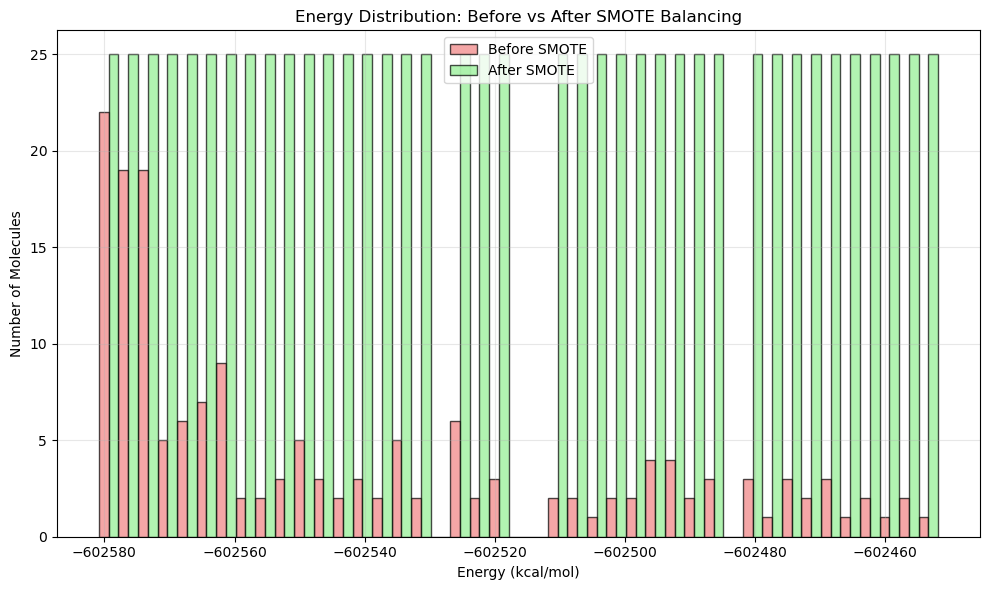

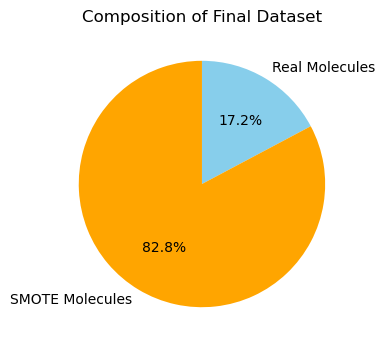

,Bin Center (kcal/mol),Count Before,Count After,Change
0,-602579.33774,22,25,3
1,-602576.33774,19,25,6
2,-602573.33774,19,25,6
3,-602570.33774,5,25,20
4,-602567.33774,6,25,19
5,-602564.33774,7,25,18
6,-602561.33774,9,25,16
7,-602558.33774,2,25,23
8,-602555.33774,2,25,23
9,-602552.33774,3,25,22



✅ Energy-bin balance visualization complete.


In [20]:
# ====================================================================
# 📊 Step 5 — Data Visualization After SMOTE Balancing
# ====================================================================
# Visualizes how SMOTE affected energy-bin balance and molecule counts.
# ====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BIN_WIDTH = 3.0
ENERGY_COL = "energy_kcal_mol"
MOLECULE_COL = "molecule_id"

# --- LOAD PRE-SMOTE AND POST-SMOTE DATA ---
df_before = pd.read_csv("molecular_data_cleaned.csv")
df_after  = pd.read_csv("molecular_embeddings_SMOTE.csv")

# --- Aggregate energy per molecule ---
energies_before = df_before.groupby(MOLECULE_COL)[ENERGY_COL].first()
energies_after  = df_after.groupby(MOLECULE_COL)[ENERGY_COL].first()

# --- Compute bins ---
minE = min(energies_before.min(), energies_after.min())
maxE = max(energies_before.max(), energies_after.max())
bins = np.arange(minE, maxE + BIN_WIDTH, BIN_WIDTH)

# --- Count molecules per bin ---
counts_before, _ = np.histogram(energies_before, bins=bins)
counts_after,  _ = np.histogram(energies_after,  bins=bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# --- Compute synthetic vs. real fraction ---
original_ids = set(df_before[MOLECULE_COL].unique())
final_ids    = set(df_after[MOLECULE_COL].unique())

real_ids      = final_ids & original_ids
synthetic_ids = final_ids - original_ids

n_real  = len(real_ids)
n_synth = len(synthetic_ids)



print("========================================")
print("📈 Dataset Summary After SMOTE Balancing")
print("========================================")
print(f"Real molecules:       {n_real:,}")
print(f"Synthetic molecules:  {n_synth:,}")
print(f"Total molecules:      {n_real + n_synth:,}")
print(f"Energy range:         {minE:.2f} → {maxE:.2f} kcal/mol")
print()

# --- PLOT: before vs after energy distributions ---
plt.figure(figsize=(10,6))
plt.bar(bin_centers - BIN_WIDTH/4, counts_before, 
        width=BIN_WIDTH/2, label="Before SMOTE", 
        color="lightcoral", edgecolor="black", alpha=0.7)
plt.bar(bin_centers + BIN_WIDTH/4, counts_after, 
        width=BIN_WIDTH/2, label="After SMOTE", 
        color="lightgreen", edgecolor="black", alpha=0.7)
plt.xlabel("Energy (kcal/mol)")
plt.ylabel("Number of Molecules")
plt.title("Energy Distribution: Before vs After SMOTE Balancing")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Optional secondary plot: real vs synthetic fraction ---
labels = ['Real Molecules', 'SMOTE Molecules']
sizes = [n_real, n_synth]
colors = ['skyblue', 'orange']

plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, counterclock=False)
plt.title("Composition of Final Dataset")
plt.show()

# --- Summary table of bins ---
summary_df = pd.DataFrame({
    "Bin Center (kcal/mol)": bin_centers,
    "Count Before": counts_before,
    "Count After": counts_after,
    "Change": counts_after - counts_before
})
display(summary_df.head(15))

print("\n✅ Energy-bin balance visualization complete.")


In [21]:
# ================================================================
# 🚨 FULL SMOTE MOLECULE QUALITY CHECK PIPELINE (One Cell)
# ================================================================
# Checks ALL SMOTE-generated molecules for:
#   - atomic clashes
#   - distorted geometries
#   - impossible coordinates
#   - incorrect total charge
#   - atom count mismatches
#
# Outputs created:
#   ✔ smote_QC_report.csv
#   ✔ bad_smote_molecules.csv
#   ✔ automatic visualization of bad molecules (optional)
# ================================================================

import numpy as np
import pandas as pd
import itertools

# ------------------------------------------------
# Covalent radii (Å) used for clash detection
# ------------------------------------------------
covalent_radii = {
    1: 0.31, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57,
    15: 1.07, 16: 1.05, 17: 0.99, 35: 1.20, 53: 1.39
}

def detect_clashes(df_mol, s_threshold=0.65):
    """
    Detect atomic clashes using scaled distance d / (r1+r2).
    If < threshold → atoms too close.
    """
    coords = df_mol[['x','y','z']].values
    Z = df_mol['Z'].values
    bad_pairs = []

    for i, j in itertools.combinations(range(len(Z)), 2):
        d = np.linalg.norm(coords[i] - coords[j])
        rsum = covalent_radii.get(Z[i],1.0) + covalent_radii.get(Z[j],1.0)
        s = d / rsum
        if s < s_threshold:
            bad_pairs.append((i, j, d, s, Z[i], Z[j]))

    return bad_pairs

# ------------------------------------------------
# Load SMOTE-balanced dataset
# ------------------------------------------------
DATA_FILE = "molecular_embeddings_SMOTE.csv"
df = pd.read_csv(DATA_FILE)

# Identify SMOTE molecules
smote_ids = [mid for mid in df["molecule_id"].unique() if mid.startswith("SMOTE_")]
print(f"🧬 Total SMOTE molecules to check: {len(smote_ids)}")

qc_rows = []
bad_molecules = []

# ------------------------------------------------
# Main QC loop
# ------------------------------------------------
for mol_id in smote_ids:
    mol = df[df["molecule_id"] == mol_id]

    # Run clash detection
    clashes = detect_clashes(mol)
    n_clashes = len(clashes)

    # Charge sanity (total should be close to 0)
    total_charge = mol["charge"].sum()

    # Geometry distortion check
    geom_std = mol[["x","y","z"]].std().mean()
    distorted = geom_std > 3.0   # extremely spread-out or collapsed geometry

    # QC logic
    passes = (n_clashes == 0 and not distorted)

    qc_rows.append({
        "molecule_id": mol_id,
        "num_atoms": len(mol),
        "num_clashes": n_clashes,
        "geom_std": geom_std,
        "distorted_geom": distorted,
        "total_charge": total_charge,
        "passes_QC": passes
    })

    if not passes:
        bad_molecules.append(mol_id)

# ------------------------------------------------
# Save QC output
# ------------------------------------------------
qc_df = pd.DataFrame(qc_rows)
qc_df.to_csv("smote_QC_report.csv", index=False)

pd.DataFrame({"bad_molecule_id": bad_molecules}).to_csv("bad_smote_molecules.csv", index=False)

print("\n================ QC SUMMARY ================")
print(f"❌ Bad SMOTE molecules: {len(bad_molecules)}")
print(f"✔ Good SMOTE molecules: {len(smote_ids) - len(bad_molecules)}")
print("Saved QC report → smote_QC_report.csv")
print("Saved bad list → bad_smote_molecules.csv")
print("============================================\n")

# ------------------------------------------------
# OPTIONAL — Visualize bad molecules in 3D
# ------------------------------------------------
from IPython.display import display
import random

try:
    from py3Dmol import view
    VIS = True
except:
    VIS = False
    print("⚠️ py3Dmol not found — skipping visualization.")

if VIS and len(bad_molecules) > 0:
    print("🔍 Visualizing a few bad molecules...")
    sample_bad = bad_molecules[:5]

    for mol_id in sample_bad:
        print("\n====================================================")
        print(f"⚠️ BAD SMOTE MOLECULE: {mol_id}")
        print("====================================================")

        visualize_molecule_3d(
            csv_file=DATA_FILE,
            molecule_id=mol_id,
            style='stick',
            show_charges=False,
            color_by_charge=False,
            width=600,
            height=450
        )




🧬 Total SMOTE molecules to check: 88

================ QC SUMMARY ================
❌ Bad SMOTE molecules: 0
✔ Good SMOTE molecules: 88
Saved QC report → smote_QC_report.csv
Saved bad list → bad_smote_molecules.csv

